In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/CIRUGÍA DE TORAX.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 4:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]),
                          len(answer_positions["C"]), len(answer_positions["D"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 11 questions
Page 1, Q1 - A: Detected box: x0=56.6, y0=89.4, x1=204.2, y1=102.1
Page 1, Q1, A: Yellow pixels: 199
Page 1, Q1, A: Total non-white pixels: 905
Page 1, Q1, A: Yellow percentage: 22.0%


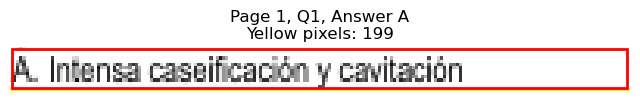

Page 1, Q1 - B: Detected box: x0=56.6, y0=102.0, x1=242.9, y1=114.7
Page 1, Q1, B: Yellow pixels: 2208
Page 1, Q1, B: Total non-white pixels: 2938
Page 1, Q1, B: Yellow percentage: 75.2%


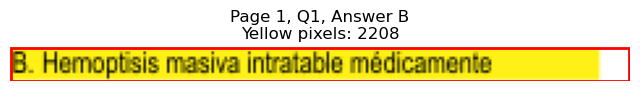

Page 1, Q1 - C: Detected box: x0=315.4, y0=89.4, x1=491.0, y1=102.1
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 883
Page 1, Q1, C: Yellow percentage: 0.0%


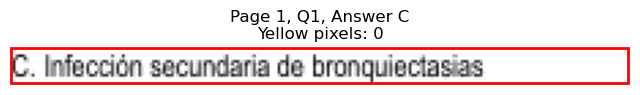

Page 1, Q1 - D: Detected box: x0=315.4, y0=102.0, x1=471.5, y1=114.7
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 779
Page 1, Q1, D: Yellow percentage: 0.0%


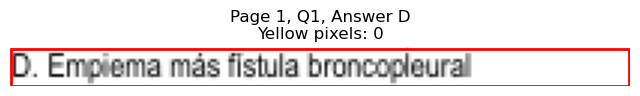


Page 1, Q1 - Selected Answer: B (based on yellow pixel count)
Page 1, Q2 - A: Detected box: x0=56.6, y0=177.7, x1=142.0, y1=190.4
Page 1, Q2, A: Yellow pixels: 136
Page 1, Q2, A: Total non-white pixels: 536
Page 1, Q2, A: Yellow percentage: 25.4%


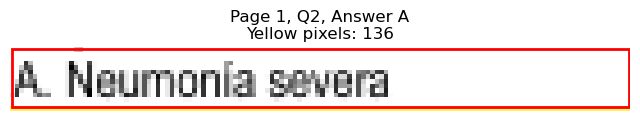

Page 1, Q2 - B: Detected box: x0=56.6, y0=190.3, x1=235.8, y1=203.0
Page 1, Q2, B: Yellow pixels: 2221
Page 1, Q2, B: Total non-white pixels: 2938
Page 1, Q2, B: Yellow percentage: 75.6%


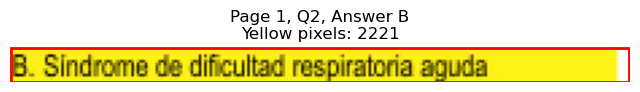

Page 1, Q2 - C: Detected box: x0=315.4, y0=177.7, x1=391.7, y1=190.4
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 369
Page 1, Q2, C: Yellow percentage: 0.0%


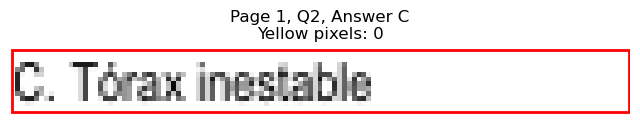

Page 1, Q2 - D: Detected box: x0=315.4, y0=190.3, x1=425.8, y1=203.0
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 569
Page 1, Q2, D: Yellow percentage: 0.0%


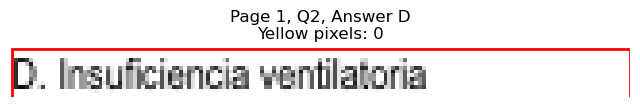


Page 1, Q2 - Selected Answer: B (based on yellow pixel count)
Page 1, Q3 - A: Detected box: x0=56.6, y0=228.2, x1=178.6, y1=240.9
Page 1, Q3, A: Yellow pixels: 1778
Page 1, Q3, A: Total non-white pixels: 2249
Page 1, Q3, A: Yellow percentage: 79.1%


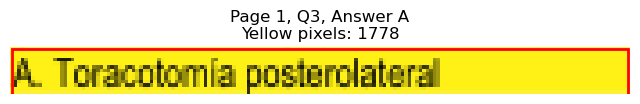

Page 1, Q3 - B: Detected box: x0=56.6, y0=240.8, x1=145.6, y1=253.5
Page 1, Q3, B: Yellow pixels: 139
Page 1, Q3, B: Total non-white pixels: 565
Page 1, Q3, B: Yellow percentage: 24.6%


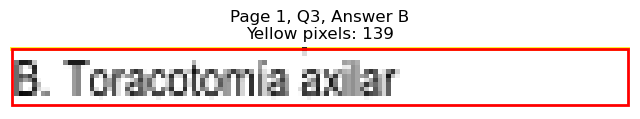

Page 1, Q3 - C: Detected box: x0=315.4, y0=228.2, x1=391.7, y1=240.9
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 356
Page 1, Q3, C: Yellow percentage: 0.0%


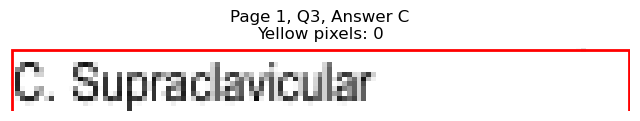

Page 1, Q3 - D: Detected box: x0=315.4, y0=240.8, x1=383.7, y1=253.5
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 334
Page 1, Q3, D: Yellow percentage: 0.0%


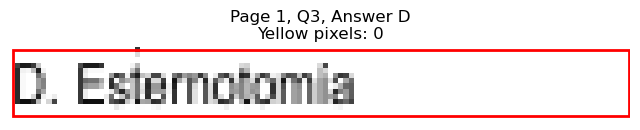


Page 1, Q3 - Selected Answer: A (based on yellow pixel count)
Page 1, Q4 - A: Detected box: x0=56.6, y0=304.0, x1=75.9, y1=316.6
Page 1, Q4, A: Yellow pixels: 861
Page 1, Q4, A: Total non-white pixels: 910
Page 1, Q4, A: Yellow percentage: 94.6%


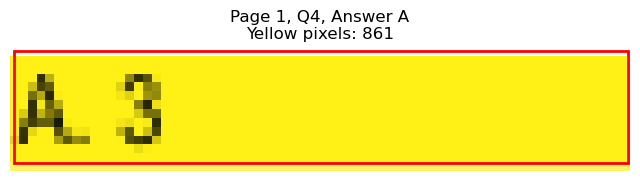

Page 1, Q4 - B: Detected box: x0=56.6, y0=316.6, x1=75.9, y1=329.2
Page 1, Q4, B: Yellow pixels: 70
Page 1, Q4, B: Total non-white pixels: 136
Page 1, Q4, B: Yellow percentage: 51.5%


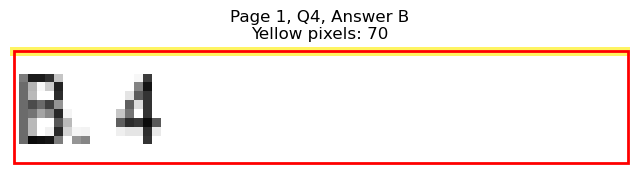

Page 1, Q4 - C: Detected box: x0=315.4, y0=304.0, x1=335.1, y1=316.6
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 62
Page 1, Q4, C: Yellow percentage: 0.0%


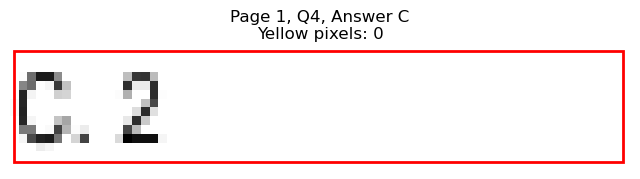

Page 1, Q4 - D: Detected box: x0=315.4, y0=316.6, x1=335.1, y1=329.2
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 53
Page 1, Q4, D: Yellow percentage: 0.0%


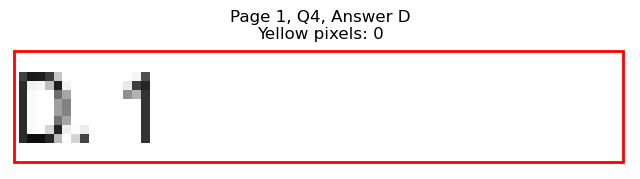


Page 1, Q4 - Selected Answer: A (based on yellow pixel count)
Page 1, Q5 - A: Detected box: x0=56.6, y0=367.1, x1=133.5, y1=379.8
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 375
Page 1, Q5, A: Yellow percentage: 0.0%


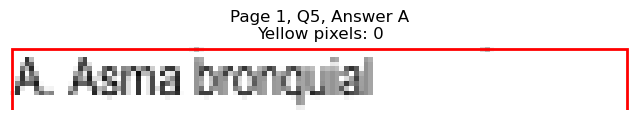

Page 1, Q5 - B: Detected box: x0=56.6, y0=379.7, x1=142.5, y1=392.4
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 391
Page 1, Q5, B: Yellow percentage: 0.0%


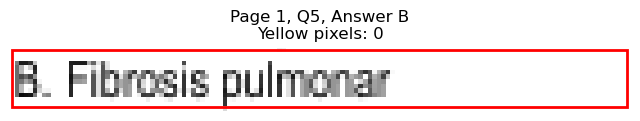

Page 1, Q5 - C: Detected box: x0=315.4, y0=367.1, x1=497.0, y1=379.8
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 1101
Page 1, Q5, C: Yellow percentage: 0.0%


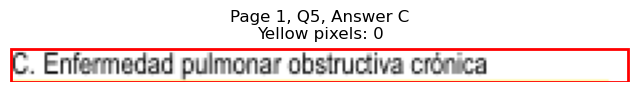

Page 1, Q5 - D: Detected box: x0=315.4, y0=379.7, x1=404.3, y1=392.4
Page 1, Q5, D: Yellow pixels: 1362
Page 1, Q5, D: Total non-white pixels: 1960
Page 1, Q5, D: Yellow percentage: 69.5%


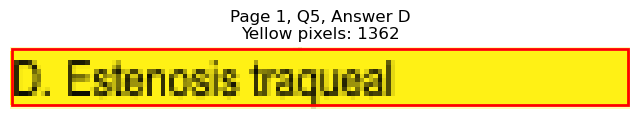


Page 1, Q5 - Selected Answer: D (based on yellow pixel count)
Page 1, Q6 - A: Detected box: x0=56.6, y0=430.2, x1=132.0, y1=442.9
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 368
Page 1, Q6, A: Yellow percentage: 0.0%


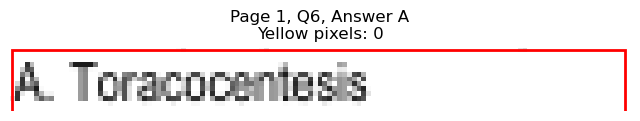

Page 1, Q6 - B: Detected box: x0=56.6, y0=442.8, x1=138.5, y1=455.5
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 389
Page 1, Q6, B: Yellow percentage: 0.0%


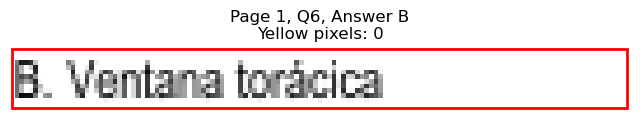

Page 1, Q6 - C: Detected box: x0=315.4, y0=430.2, x1=405.3, y1=442.9
Page 1, Q6, C: Yellow pixels: 1487
Page 1, Q6, C: Total non-white pixels: 1833
Page 1, Q6, C: Yellow percentage: 81.1%


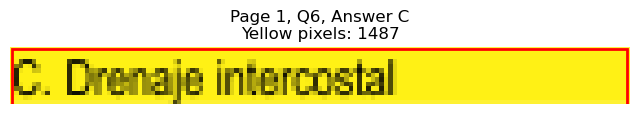

Page 1, Q6 - D: Detected box: x0=315.4, y0=442.8, x1=430.4, y1=455.5
Page 1, Q6, D: Yellow pixels: 164
Page 1, Q6, D: Total non-white pixels: 730
Page 1, Q6, D: Yellow percentage: 22.5%


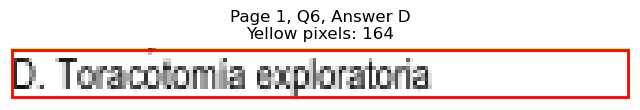


Page 1, Q6 - Selected Answer: C (based on yellow pixel count)
Page 1, Q7 - A: Detected box: x0=56.6, y0=480.8, x1=137.5, y1=493.4
Page 1, Q7, A: Yellow pixels: 1277
Page 1, Q7, A: Total non-white pixels: 1848
Page 1, Q7, A: Yellow percentage: 69.1%


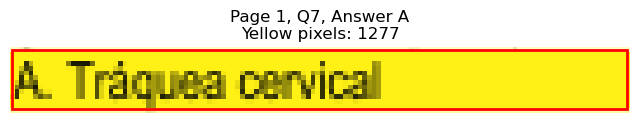

Page 1, Q7 - B: Detected box: x0=56.6, y0=493.4, x1=160.6, y1=506.0
Page 1, Q7, B: Yellow pixels: 1
Page 1, Q7, B: Total non-white pixels: 586
Page 1, Q7, B: Yellow percentage: 0.2%


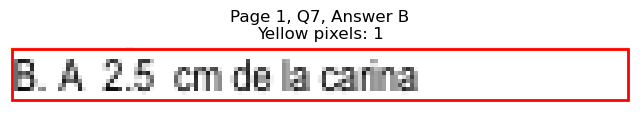

Page 1, Q7 - C: Detected box: x0=315.4, y0=480.8, x1=521.3, y1=493.4
Page 1, Q7, C: Yellow pixels: 0
Page 1, Q7, C: Total non-white pixels: 905
Page 1, Q7, C: Yellow percentage: 0.0%


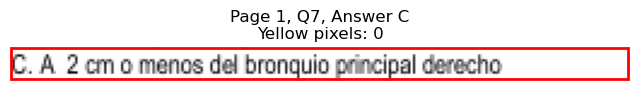

Page 1, Q7 - D: Detected box: x0=315.4, y0=493.4, x1=400.3, y1=506.0
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 393
Page 1, Q7, D: Yellow percentage: 0.0%


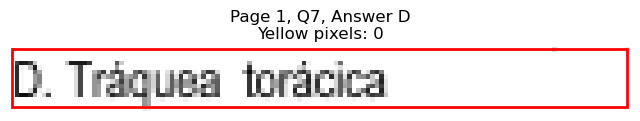


Page 1, Q7 - Selected Answer: A (based on yellow pixel count)
Page 1, Q8 - A: Detected box: x0=56.6, y0=531.2, x1=282.4, y1=543.8
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 1149
Page 1, Q8, A: Yellow percentage: 0.0%


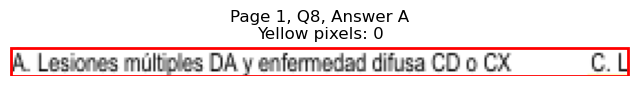

Page 1, Q8 - B: Detected box: x0=56.6, y0=543.8, x1=240.9, y1=556.4
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 913
Page 1, Q8, B: Yellow percentage: 0.0%


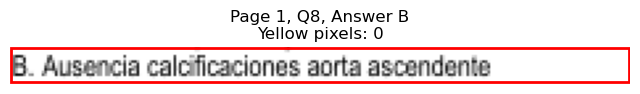

Page 1, Q8 - C: Detected box: x0=315.4, y0=531.2, x1=488.6, y1=543.8
Page 1, Q8, C: Yellow pixels: 0
Page 1, Q8, C: Total non-white pixels: 1034
Page 1, Q8, C: Yellow percentage: 0.0%


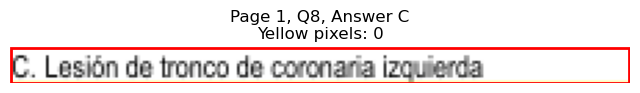

Page 1, Q8 - D: Detected box: x0=315.4, y0=543.8, x1=503.7, y1=556.4
Page 1, Q8, D: Yellow pixels: 2209
Page 1, Q8, D: Total non-white pixels: 3164
Page 1, Q8, D: Yellow percentage: 69.8%


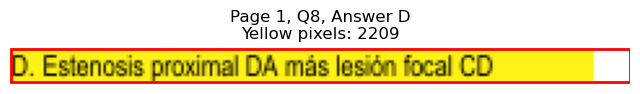


Page 1, Q8 - Selected Answer: D (based on yellow pixel count)
Page 1, Q9 - A: Detected box: x0=56.6, y0=581.7, x1=123.0, y1=594.3
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 299
Page 1, Q9, A: Yellow percentage: 0.0%


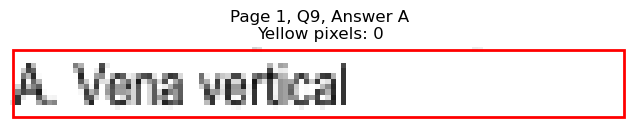

Page 1, Q9 - B: Detected box: x0=56.6, y0=594.3, x1=175.6, y1=606.9
Page 1, Q9, B: Yellow pixels: 0
Page 1, Q9, B: Total non-white pixels: 557
Page 1, Q9, B: Yellow percentage: 0.0%


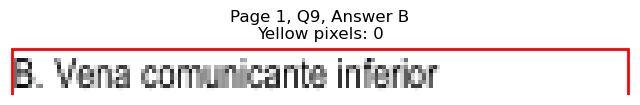

Page 1, Q9 - C: Detected box: x0=315.4, y0=581.7, x1=396.8, y1=594.3
Page 1, Q9, C: Yellow pixels: 132
Page 1, Q9, C: Total non-white pixels: 515
Page 1, Q9, C: Yellow percentage: 25.6%


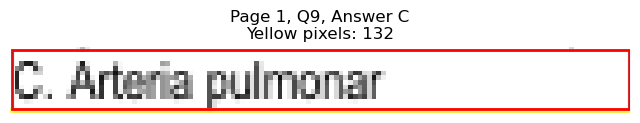

Page 1, Q9 - D: Detected box: x0=315.4, y0=594.3, x1=391.3, y1=606.9
Page 1, Q9, D: Yellow pixels: 1404
Page 1, Q9, D: Total non-white pixels: 1651
Page 1, Q9, D: Yellow percentage: 85.0%


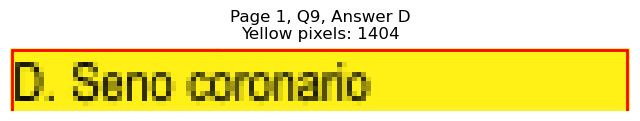


Page 1, Q9 - Selected Answer: D (based on yellow pixel count)
Page 1, Q10 - A: Detected box: x0=56.6, y0=632.2, x1=82.8, y1=644.9
Page 1, Q10, A: Yellow pixels: 0
Page 1, Q10, A: Total non-white pixels: 112
Page 1, Q10, A: Yellow percentage: 0.0%


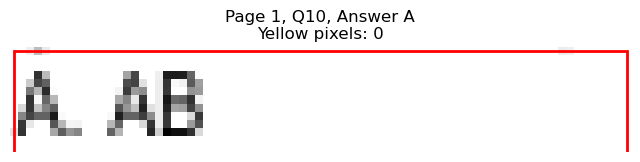

Page 1, Q10 - B: Detected box: x0=56.6, y0=644.8, x1=76.8, y1=657.5
Page 1, Q10, B: Yellow pixels: 0
Page 1, Q10, B: Total non-white pixels: 74
Page 1, Q10, B: Yellow percentage: 0.0%


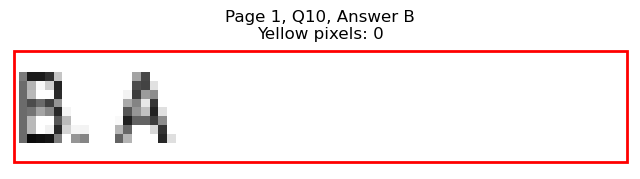

Page 1, Q10 - C: Detected box: x0=315.4, y0=632.2, x1=341.1, y1=644.9
Page 1, Q10, C: Yellow pixels: 927
Page 1, Q10, C: Total non-white pixels: 1001
Page 1, Q10, C: Yellow percentage: 92.6%


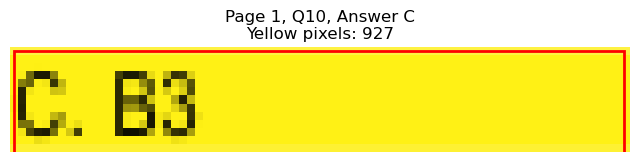

Page 1, Q10 - D: Detected box: x0=315.4, y0=644.8, x1=341.1, y1=657.5
Page 1, Q10, D: Yellow pixels: 0
Page 1, Q10, D: Total non-white pixels: 90
Page 1, Q10, D: Yellow percentage: 0.0%


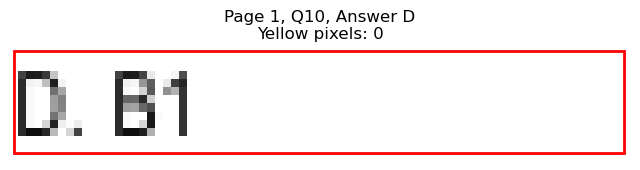


Page 1, Q10 - Selected Answer: C (based on yellow pixel count)
Page 1, Q11 - A: Detected box: x0=56.6, y0=695.4, x1=169.6, y1=708.0
Page 1, Q11, A: Yellow pixels: 0
Page 1, Q11, A: Total non-white pixels: 529
Page 1, Q11, A: Yellow percentage: 0.0%


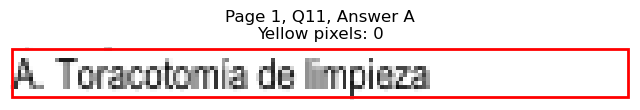

Page 1, Q11 - B: Detected box: x0=56.6, y0=708.0, x1=181.1, y1=720.6
Page 1, Q11, B: Yellow pixels: 0
Page 1, Q11, B: Total non-white pixels: 586
Page 1, Q11, B: Yellow percentage: 0.0%


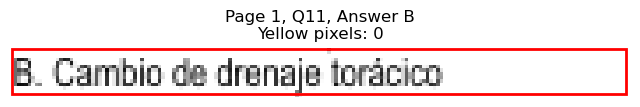

Page 1, Q11 - C: Detected box: x0=315.4, y0=695.4, x1=432.9, y1=708.0
Page 1, Q11, C: Yellow pixels: 168
Page 1, Q11, C: Total non-white pixels: 939
Page 1, Q11, C: Yellow percentage: 17.9%


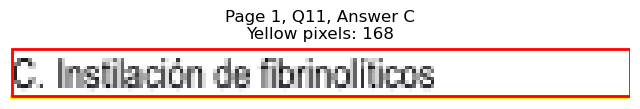

Page 1, Q11 - D: Detected box: x0=315.4, y0=708.0, x1=436.9, y1=720.6
Page 1, Q11, D: Yellow pixels: 1769
Page 1, Q11, D: Total non-white pixels: 2408
Page 1, Q11, D: Yellow percentage: 73.5%


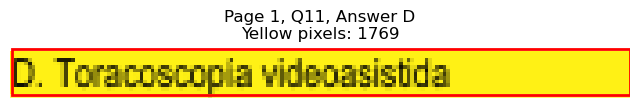


Page 1, Q11 - Selected Answer: D (based on yellow pixel count)

Page 2: Found 11 questions
Page 2, Q1 - A: Detected box: x0=56.6, y0=102.0, x1=160.6, y1=114.7
Page 2, Q1, A: Yellow pixels: 4
Page 2, Q1, A: Total non-white pixels: 677
Page 2, Q1, A: Yellow percentage: 0.6%


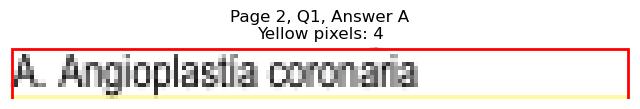

Page 2, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=159.0, y1=127.3
Page 2, Q1, B: Yellow pixels: 1429
Page 2, Q1, B: Total non-white pixels: 2156
Page 2, Q1, B: Yellow percentage: 66.3%


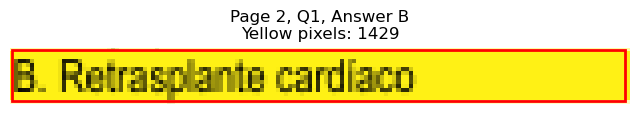

Page 2, Q1 - C: Detected box: x0=315.4, y0=102.0, x1=422.8, y1=114.7
Page 2, Q1, C: Yellow pixels: 0
Page 2, Q1, C: Total non-white pixels: 490
Page 2, Q1, C: Yellow percentage: 0.0%


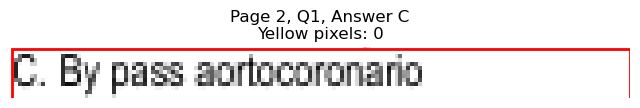

Page 2, Q1 - D: Detected box: x0=315.4, y0=114.6, x1=433.4, y1=127.3
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 595
Page 2, Q1, D: Yellow percentage: 0.0%


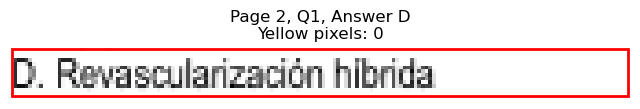


Page 2, Q1 - Selected Answer: B (based on yellow pixel count)
Page 2, Q2 - A: Detected box: x0=56.6, y0=177.7, x1=187.1, y1=190.4
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 611
Page 2, Q2, A: Yellow percentage: 0.0%


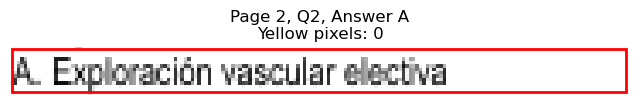

Page 2, Q2 - B: Detected box: x0=56.6, y0=190.3, x1=120.5, y1=203.0
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 325
Page 2, Q2, B: Yellow percentage: 0.0%


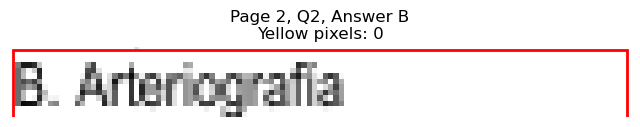

Page 2, Q2 - C: Detected box: x0=315.4, y0=177.7, x1=475.5, y1=190.4
Page 2, Q2, C: Yellow pixels: 1943
Page 2, Q2, C: Total non-white pixels: 2954
Page 2, Q2, C: Yellow percentage: 65.8%


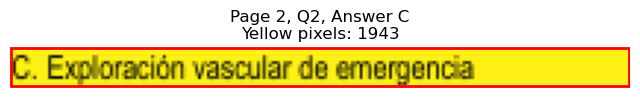

Page 2, Q2 - D: Detected box: x0=315.4, y0=190.3, x1=368.2, y1=203.0
Page 2, Q2, D: Yellow pixels: 1
Page 2, Q2, D: Total non-white pixels: 341
Page 2, Q2, D: Yellow percentage: 0.3%


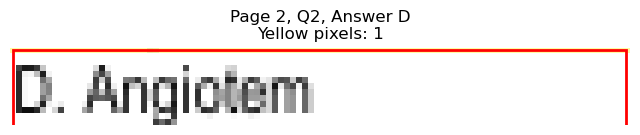


Page 2, Q2 - Selected Answer: C (based on yellow pixel count)
Page 2, Q3 - A: Detected box: x0=56.6, y0=253.4, x1=132.0, y1=266.1
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 365
Page 2, Q3, A: Yellow percentage: 0.0%


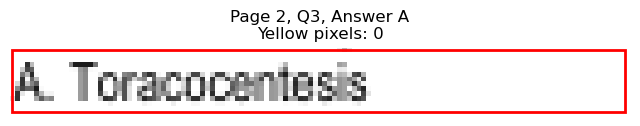

Page 2, Q3 - B: Detected box: x0=56.6, y0=266.0, x1=171.1, y1=278.7
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 569
Page 2, Q3, B: Yellow percentage: 0.0%


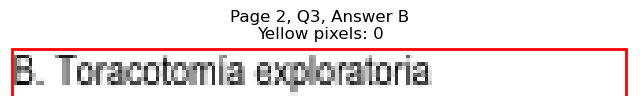

Page 2, Q3 - C: Detected box: x0=315.4, y0=253.4, x1=405.3, y1=266.1
Page 2, Q3, C: Yellow pixels: 1487
Page 2, Q3, C: Total non-white pixels: 1974
Page 2, Q3, C: Yellow percentage: 75.3%


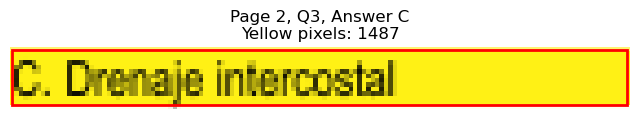

Page 2, Q3 - D: Detected box: x0=315.4, y0=266.0, x1=387.2, y1=278.7
Page 2, Q3, D: Yellow pixels: 0
Page 2, Q3, D: Total non-white pixels: 470
Page 2, Q3, D: Yellow percentage: 0.0%


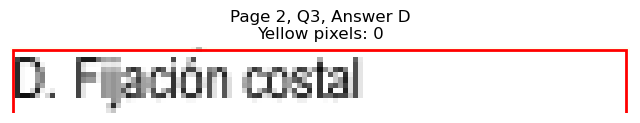


Page 2, Q3 - Selected Answer: C (based on yellow pixel count)
Page 2, Q4 - A: Detected box: x0=56.6, y0=304.0, x1=112.0, y1=316.6
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 253
Page 2, Q4, A: Yellow percentage: 0.0%


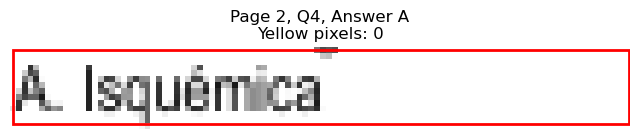

Page 2, Q4 - B: Detected box: x0=56.6, y0=316.6, x1=161.5, y1=329.2
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 510
Page 2, Q4, B: Yellow percentage: 0.0%


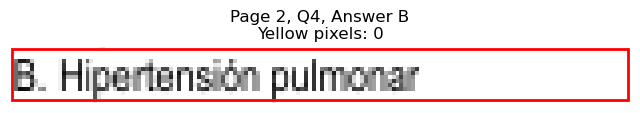

Page 2, Q4 - C: Detected box: x0=315.4, y0=304.0, x1=393.8, y1=316.6
Page 2, Q4, C: Yellow pixels: 1385
Page 2, Q4, C: Total non-white pixels: 1683
Page 2, Q4, C: Yellow percentage: 82.3%


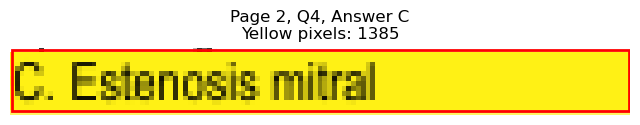

Page 2, Q4 - D: Detected box: x0=315.4, y0=316.6, x1=426.3, y1=329.2
Page 2, Q4, D: Yellow pixels: 162
Page 2, Q4, D: Total non-white pixels: 729
Page 2, Q4, D: Yellow percentage: 22.2%


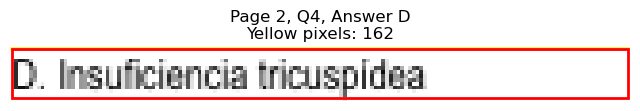


Page 2, Q4 - Selected Answer: C (based on yellow pixel count)
Page 2, Q5 - A: Detected box: x0=56.6, y0=392.3, x1=168.1, y1=405.0
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 710
Page 2, Q5, A: Yellow percentage: 0.0%


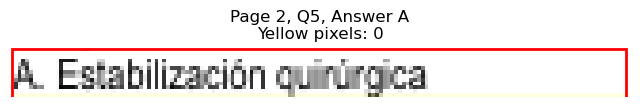

Page 2, Q5 - B: Detected box: x0=56.6, y0=404.9, x1=136.5, y1=417.6
Page 2, Q5, B: Yellow pixels: 1399
Page 2, Q5, B: Total non-white pixels: 1834
Page 2, Q5, B: Yellow percentage: 76.3%


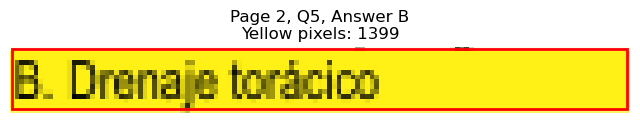

Page 2, Q5 - C: Detected box: x0=315.4, y0=556.5, x1=391.4, y1=569.1
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 609
Page 2, Q5, C: Yellow percentage: 0.0%


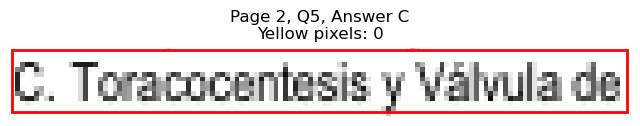

Page 2, Q5 - D: Detected box: x0=315.4, y0=404.9, x1=386.7, y1=417.6
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 333
Page 2, Q5, D: Yellow percentage: 0.0%


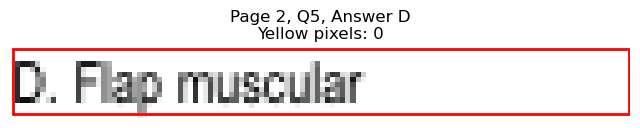


Page 2, Q5 - Selected Answer: B (based on yellow pixel count)
Page 2, Q6 - A: Detected box: x0=56.6, y0=442.8, x1=136.5, y1=455.5
Page 2, Q6, A: Yellow pixels: 131
Page 2, Q6, A: Total non-white pixels: 533
Page 2, Q6, A: Yellow percentage: 24.6%


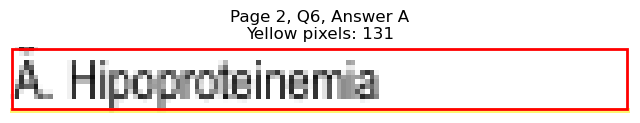

Page 2, Q6 - B: Detected box: x0=56.6, y0=455.5, x1=143.5, y1=468.1
Page 2, Q6, B: Yellow pixels: 1411
Page 2, Q6, B: Total non-white pixels: 1932
Page 2, Q6, B: Yellow percentage: 73.0%


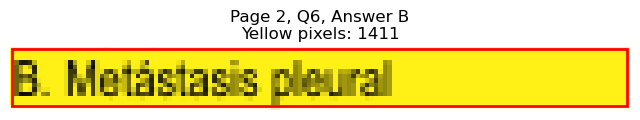

Page 2, Q6 - C: Detected box: x0=315.4, y0=442.8, x1=438.4, y1=455.5
Page 2, Q6, C: Yellow pixels: 0
Page 2, Q6, C: Total non-white pixels: 630
Page 2, Q6, C: Yellow percentage: 0.0%


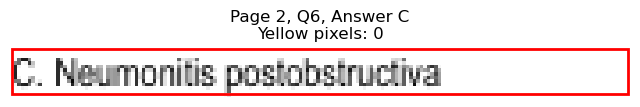

Page 2, Q6 - D: Detected box: x0=315.4, y0=455.5, x1=402.8, y1=468.1
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 426
Page 2, Q6, D: Yellow percentage: 0.0%


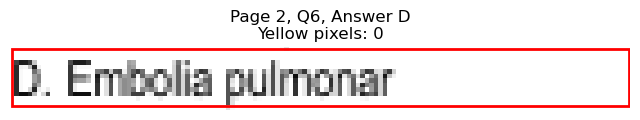


Page 2, Q6 - Selected Answer: B (based on yellow pixel count)
Page 2, Q7 - A: Detected box: x0=56.6, y0=493.4, x1=170.7, y1=506.0
Page 2, Q7, A: Yellow pixels: 1700
Page 2, Q7, A: Total non-white pixels: 2147
Page 2, Q7, A: Yellow percentage: 79.2%


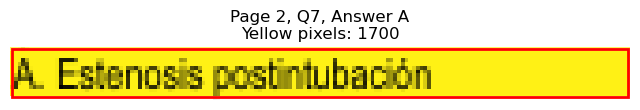

Page 2, Q7 - B: Detected box: x0=56.6, y0=506.0, x1=193.7, y1=518.6
Page 2, Q7, B: Yellow pixels: 186
Page 2, Q7, B: Total non-white pixels: 903
Page 2, Q7, B: Yellow percentage: 20.6%


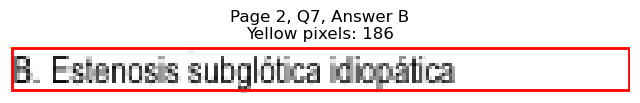

Page 2, Q7 - C: Detected box: x0=315.4, y0=493.4, x1=444.9, y1=506.0
Page 2, Q7, C: Yellow pixels: 0
Page 2, Q7, C: Total non-white pixels: 631
Page 2, Q7, C: Yellow percentage: 0.0%


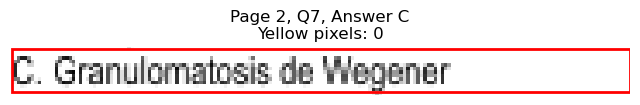

Page 2, Q7 - D: Detected box: x0=315.4, y0=506.0, x1=446.9, y1=518.6
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 648
Page 2, Q7, D: Yellow percentage: 0.0%


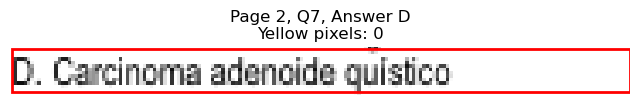


Page 2, Q7 - Selected Answer: A (based on yellow pixel count)
Page 2, Q8 - A: Detected box: x0=56.6, y0=556.5, x1=228.3, y1=569.1
Page 2, Q8, A: Yellow pixels: 223
Page 2, Q8, A: Total non-white pixels: 1052
Page 2, Q8, A: Yellow percentage: 21.2%


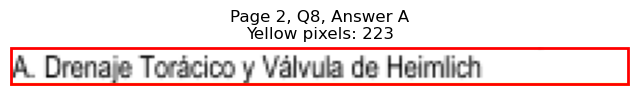

Page 2, Q8 - B: Detected box: x0=56.6, y0=569.1, x1=255.3, y1=581.7
Page 2, Q8, B: Yellow pixels: 2195
Page 2, Q8, B: Total non-white pixels: 2938
Page 2, Q8, B: Yellow percentage: 74.7%


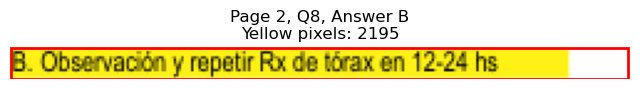

Page 2, Q8 - C: Detected box: x0=315.4, y0=556.5, x1=480.0, y1=569.1
Page 2, Q8, C: Yellow pixels: 0
Page 2, Q8, C: Total non-white pixels: 800
Page 2, Q8, C: Yellow percentage: 0.0%


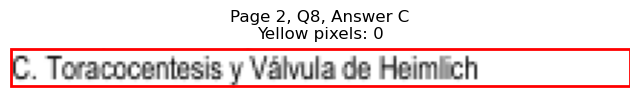

Page 2, Q8 - D: Detected box: x0=315.4, y0=569.1, x1=464.0, y1=581.7
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 713
Page 2, Q8, D: Yellow percentage: 0.0%


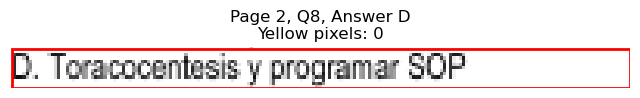


Page 2, Q8 - Selected Answer: B (based on yellow pixel count)
Page 2, Q9 - A: Detected box: x0=56.6, y0=619.6, x1=187.7, y1=632.3
Page 2, Q9, A: Yellow pixels: 1722
Page 2, Q9, A: Total non-white pixels: 2548
Page 2, Q9, A: Yellow percentage: 67.6%


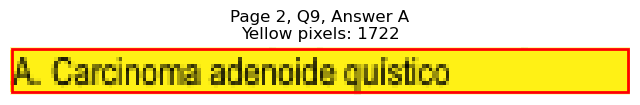

Page 2, Q9 - B: Detected box: x0=56.6, y0=632.2, x1=166.6, y1=644.9
Page 2, Q9, B: Yellow pixels: 0
Page 2, Q9, B: Total non-white pixels: 683
Page 2, Q9, B: Yellow percentage: 0.0%


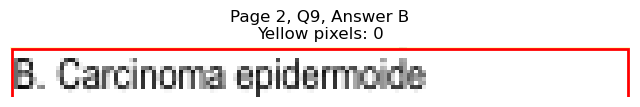

Page 2, Q9 - C: Detected box: x0=315.4, y0=619.6, x1=366.3, y1=632.3
Page 2, Q9, C: Yellow pixels: 0
Page 2, Q9, C: Total non-white pixels: 231
Page 2, Q9, C: Yellow percentage: 0.0%


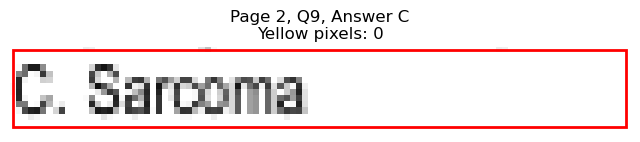

Page 2, Q9 - D: Detected box: x0=315.4, y0=632.2, x1=383.7, y1=644.9
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 314
Page 2, Q9, D: Yellow percentage: 0.0%


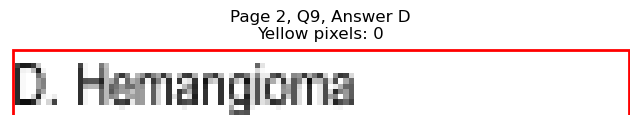


Page 2, Q9 - Selected Answer: A (based on yellow pixel count)
Page 2, Q10 - A: Detected box: x0=56.6, y0=670.0, x1=213.8, y1=682.7
Page 2, Q10, A: Yellow pixels: 1
Page 2, Q10, A: Total non-white pixels: 985
Page 2, Q10, A: Yellow percentage: 0.1%


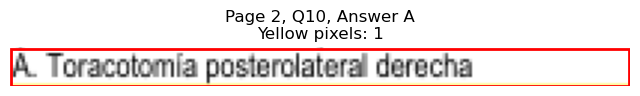

Page 2, Q10 - B: Detected box: x0=56.6, y0=682.6, x1=217.7, y1=695.3
Page 2, Q10, B: Yellow pixels: 1895
Page 2, Q10, B: Total non-white pixels: 2968
Page 2, Q10, B: Yellow percentage: 63.8%


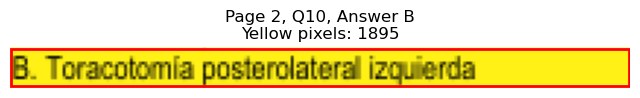

Page 2, Q10 - C: Detected box: x0=315.4, y0=670.0, x1=410.9, y1=682.7
Page 2, Q10, C: Yellow pixels: 0
Page 2, Q10, C: Total non-white pixels: 465
Page 2, Q10, C: Yellow percentage: 0.0%


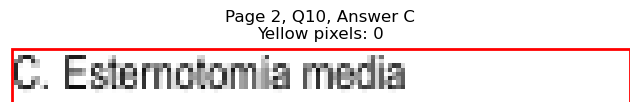

Page 2, Q10 - D: Detected box: x0=315.4, y0=682.6, x1=404.8, y1=695.3
Page 2, Q10, D: Yellow pixels: 0
Page 2, Q10, D: Total non-white pixels: 422
Page 2, Q10, D: Yellow percentage: 0.0%


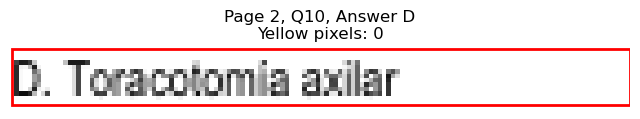


Page 2, Q10 - Selected Answer: B (based on yellow pixel count)
Page 2, Q11 - A: Detected box: x0=56.6, y0=720.6, x1=135.0, y1=733.2
Page 2, Q11, A: Yellow pixels: 0
Page 2, Q11, A: Total non-white pixels: 361
Page 2, Q11, A: Yellow percentage: 0.0%


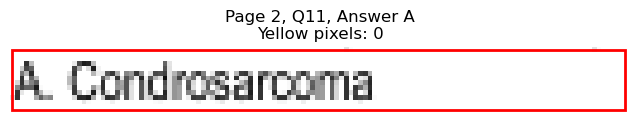

Page 2, Q11 - B: Detected box: x0=56.6, y0=733.2, x1=126.0, y1=745.8
Page 2, Q11, B: Yellow pixels: 0
Page 2, Q11, B: Total non-white pixels: 321
Page 2, Q11, B: Yellow percentage: 0.0%


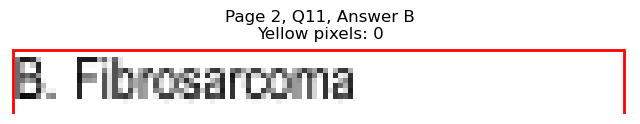

Page 2, Q11 - C: Detected box: x0=315.4, y0=720.6, x1=381.7, y1=733.2
Page 2, Q11, C: Yellow pixels: 117
Page 2, Q11, C: Total non-white pixels: 397
Page 2, Q11, C: Yellow percentage: 29.5%


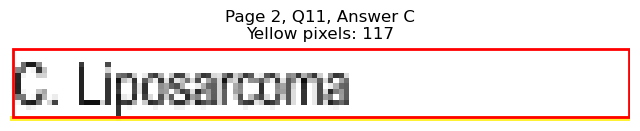

Page 2, Q11 - D: Detected box: x0=315.4, y0=733.2, x1=396.3, y1=745.8
Page 2, Q11, D: Yellow pixels: 1432
Page 2, Q11, D: Total non-white pixels: 1716
Page 2, Q11, D: Yellow percentage: 83.4%


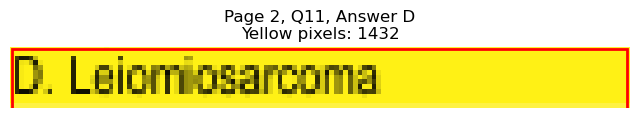


Page 2, Q11 - Selected Answer: D (based on yellow pixel count)

Page 3: Found 12 questions
Page 3, Q1 - A: Detected box: x0=56.6, y0=89.4, x1=162.6, y1=102.1
Page 3, Q1, A: Yellow pixels: 0
Page 3, Q1, A: Total non-white pixels: 487
Page 3, Q1, A: Yellow percentage: 0.0%


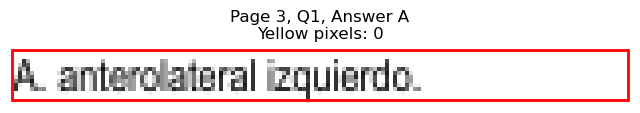

Page 3, Q1 - B: Detected box: x0=56.6, y0=102.0, x1=157.1, y1=114.7
Page 3, Q1, B: Yellow pixels: 0
Page 3, Q1, B: Total non-white pixels: 480
Page 3, Q1, B: Yellow percentage: 0.0%


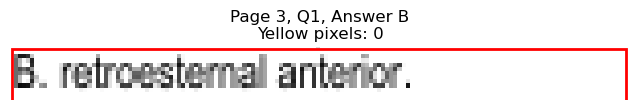

Page 3, Q1 - C: Detected box: x0=315.4, y0=89.4, x1=426.3, y1=102.1
Page 3, Q1, C: Yellow pixels: 1677
Page 3, Q1, C: Total non-white pixels: 2268
Page 3, Q1, C: Yellow percentage: 73.9%


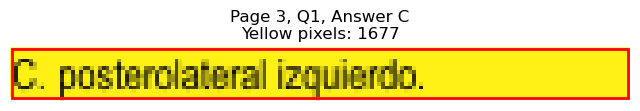

Page 3, Q1 - D: Detected box: x0=315.4, y0=102.0, x1=389.2, y1=114.7
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 471
Page 3, Q1, D: Yellow percentage: 0.0%


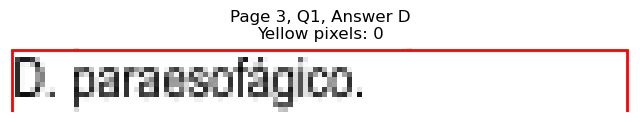


Page 3, Q1 - Selected Answer: C (based on yellow pixel count)
Page 3, Q2 - A: Detected box: x0=56.6, y0=152.5, x1=115.0, y1=165.2
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 272
Page 3, Q2, A: Yellow percentage: 0.0%


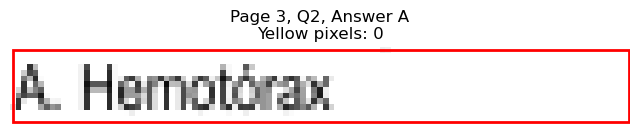

Page 3, Q2 - B: Detected box: x0=56.6, y0=165.1, x1=140.1, y1=177.8
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 416
Page 3, Q2, B: Yellow percentage: 0.0%


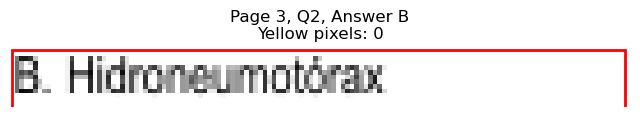

Page 3, Q2 - C: Detected box: x0=315.4, y0=152.5, x1=423.8, y1=165.2
Page 3, Q2, C: Yellow pixels: 159
Page 3, Q2, C: Total non-white pixels: 676
Page 3, Q2, C: Yellow percentage: 23.5%


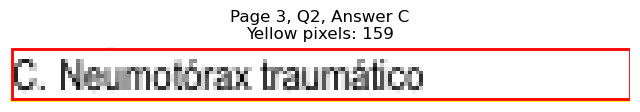

Page 3, Q2 - D: Detected box: x0=315.4, y0=165.1, x1=425.3, y1=177.8
Page 3, Q2, D: Yellow pixels: 1662
Page 3, Q2, D: Total non-white pixels: 2093
Page 3, Q2, D: Yellow percentage: 79.4%


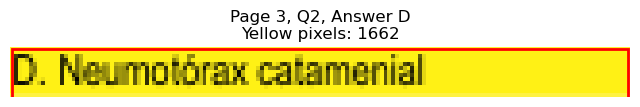


Page 3, Q2 - Selected Answer: D (based on yellow pixel count)
Page 3, Q3 - A: Detected box: x0=56.6, y0=202.9, x1=92.4, y1=215.6
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 159
Page 3, Q3, A: Yellow percentage: 0.0%


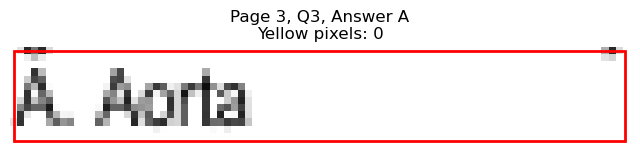

Page 3, Q3 - B: Detected box: x0=56.6, y0=215.6, x1=115.1, y1=228.3
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 277
Page 3, Q3, B: Yellow percentage: 0.0%


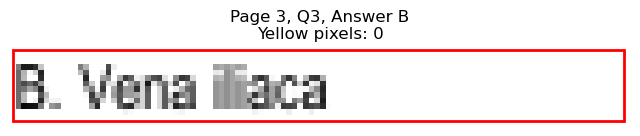

Page 3, Q3 - C: Detected box: x0=315.4, y0=202.9, x1=402.8, y1=215.6
Page 3, Q3, C: Yellow pixels: 1498
Page 3, Q3, C: Total non-white pixels: 1932
Page 3, Q3, C: Yellow percentage: 77.5%


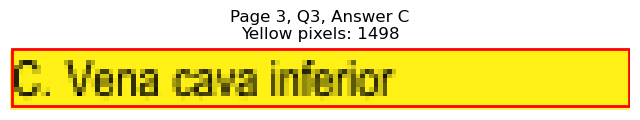

Page 3, Q3 - D: Detected box: x0=315.4, y0=215.6, x1=379.7, y1=228.3
Page 3, Q3, D: Yellow pixels: 115
Page 3, Q3, D: Total non-white pixels: 422
Page 3, Q3, D: Yellow percentage: 27.3%


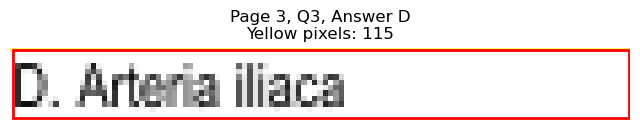


Page 3, Q3 - Selected Answer: C (based on yellow pixel count)
Page 3, Q4 - A: Detected box: x0=56.6, y0=253.4, x1=147.0, y1=266.1
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 398
Page 3, Q4, A: Yellow percentage: 0.0%


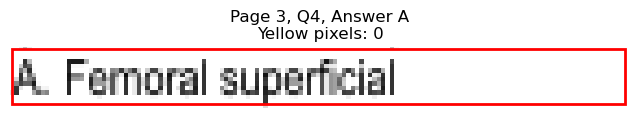

Page 3, Q4 - B: Detected box: x0=56.6, y0=266.0, x1=151.1, y1=278.7
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 426
Page 3, Q4, B: Yellow percentage: 0.0%


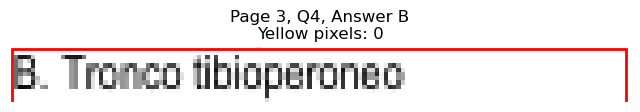

Page 3, Q4 - C: Detected box: x0=315.4, y0=253.4, x1=401.2, y1=266.1
Page 3, Q4, C: Yellow pixels: 137
Page 3, Q4, C: Total non-white pixels: 534
Page 3, Q4, C: Yellow percentage: 25.7%


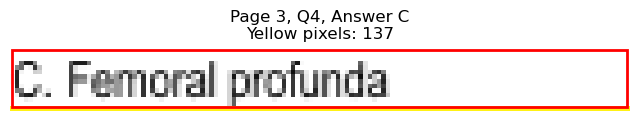

Page 3, Q4 - D: Detected box: x0=315.4, y0=266.0, x1=363.2, y1=278.7
Page 3, Q4, D: Yellow pixels: 1123
Page 3, Q4, D: Total non-white pixels: 1287
Page 3, Q4, D: Yellow percentage: 87.3%


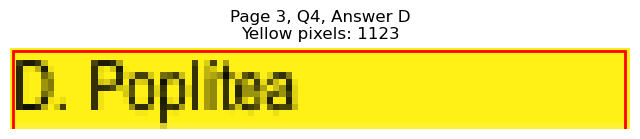


Page 3, Q4 - Selected Answer: D (based on yellow pixel count)
Page 3, Q5 - A: Detected box: x0=56.6, y0=329.2, x1=78.4, y1=341.8
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 67
Page 3, Q5, A: Yellow percentage: 0.0%


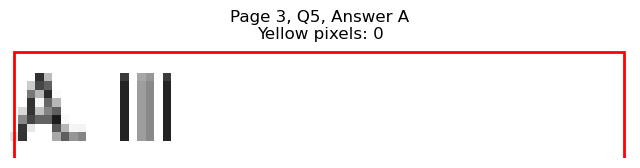

Page 3, Q5 - B: Detected box: x0=56.6, y0=341.9, x1=79.3, y1=354.6
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 78
Page 3, Q5, B: Yellow percentage: 0.0%


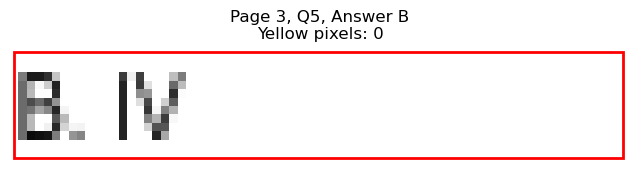

Page 3, Q5 - C: Detected box: x0=315.4, y0=329.2, x1=332.6, y1=341.8
Page 3, Q5, C: Yellow pixels: 0
Page 3, Q5, C: Total non-white pixels: 52
Page 3, Q5, C: Yellow percentage: 0.0%


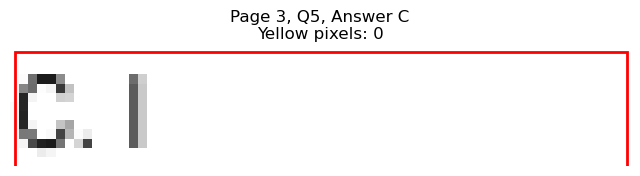

Page 3, Q5 - D: Detected box: x0=315.4, y0=341.9, x1=335.1, y1=354.6
Page 3, Q5, D: Yellow pixels: 869
Page 3, Q5, D: Total non-white pixels: 994
Page 3, Q5, D: Yellow percentage: 87.4%


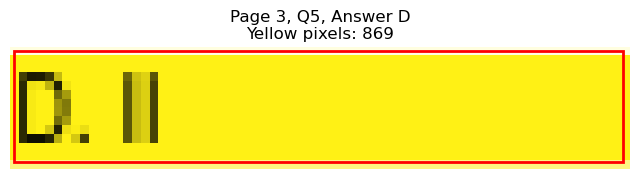


Page 3, Q5 - Selected Answer: D (based on yellow pixel count)
Page 3, Q6 - A: Detected box: x0=56.6, y0=379.7, x1=103.3, y1=392.4
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 200
Page 3, Q6, A: Yellow percentage: 0.0%


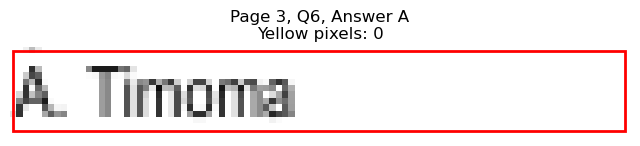

Page 3, Q6 - B: Detected box: x0=56.6, y0=392.3, x1=109.5, y1=405.0
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 242
Page 3, Q6, B: Yellow percentage: 0.0%


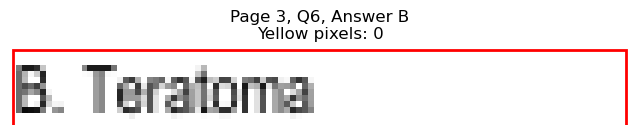

Page 3, Q6 - C: Detected box: x0=315.4, y0=379.7, x1=408.3, y1=392.4
Page 3, Q6, C: Yellow pixels: 1383
Page 3, Q6, C: Total non-white pixels: 2016
Page 3, Q6, C: Yellow percentage: 68.6%


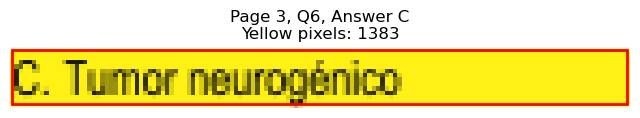

Page 3, Q6 - D: Detected box: x0=315.4, y0=392.3, x1=362.1, y1=405.0
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 284
Page 3, Q6, D: Yellow percentage: 0.0%


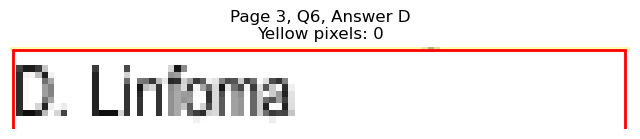


Page 3, Q6 - Selected Answer: C (based on yellow pixel count)
Page 3, Q7 - A: Detected box: x0=56.6, y0=430.2, x1=151.1, y1=442.9
Page 3, Q7, A: Yellow pixels: 1557
Page 3, Q7, A: Total non-white pixels: 1898
Page 3, Q7, A: Yellow percentage: 82.0%


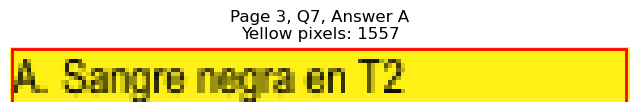

Page 3, Q7 - B: Detected box: x0=56.6, y0=442.8, x1=151.1, y1=455.5
Page 3, Q7, B: Yellow pixels: 138
Page 3, Q7, B: Total non-white pixels: 582
Page 3, Q7, B: Yellow percentage: 23.7%


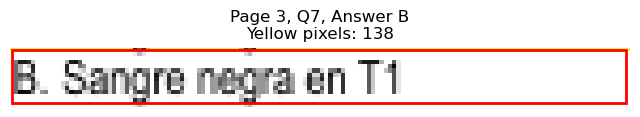

Page 3, Q7 - C: Detected box: x0=315.4, y0=430.2, x1=383.7, y1=442.9
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 320
Page 3, Q7, C: Yellow percentage: 0.0%


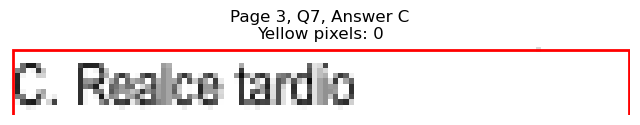

Page 3, Q7 - D: Detected box: x0=315.4, y0=442.8, x1=418.4, y1=455.5
Page 3, Q7, D: Yellow pixels: 0
Page 3, Q7, D: Total non-white pixels: 516
Page 3, Q7, D: Yellow percentage: 0.0%


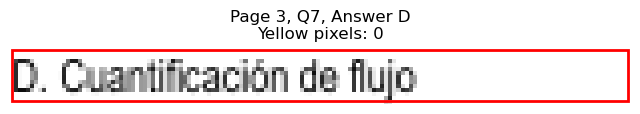


Page 3, Q7 - Selected Answer: A (based on yellow pixel count)
Page 3, Q8 - A: Detected box: x0=56.6, y0=493.4, x1=220.4, y1=506.0
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 815
Page 3, Q8, A: Yellow percentage: 0.0%


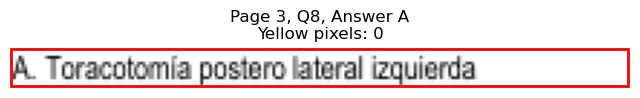

Page 3, Q8 - B: Detected box: x0=56.6, y0=506.0, x1=151.6, y1=518.6
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 470
Page 3, Q8, B: Yellow percentage: 0.0%


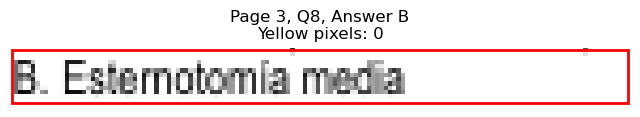

Page 3, Q8 - C: Detected box: x0=315.4, y0=493.4, x1=446.3, y1=506.0
Page 3, Q8, C: Yellow pixels: 182
Page 3, Q8, C: Total non-white pixels: 984
Page 3, Q8, C: Yellow percentage: 18.5%


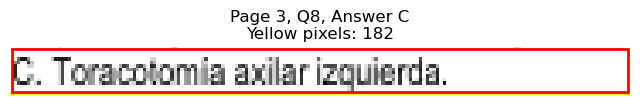

Page 3, Q8 - D: Detected box: x0=315.4, y0=506.0, x1=475.5, y1=518.6
Page 3, Q8, D: Yellow pixels: 2121
Page 3, Q8, D: Total non-white pixels: 2954
Page 3, Q8, D: Yellow percentage: 71.8%


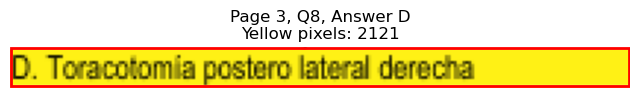


Page 3, Q8 - Selected Answer: D (based on yellow pixel count)
Page 3, Q9 - A: Detected box: x0=56.6, y0=556.5, x1=130.6, y1=569.1
Page 3, Q9, A: Yellow pixels: 1347
Page 3, Q9, A: Total non-white pixels: 1750
Page 3, Q9, A: Yellow percentage: 77.0%


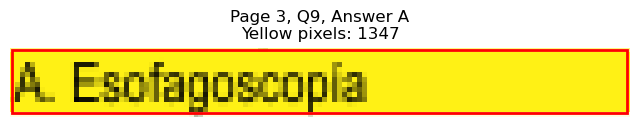

Page 3, Q9 - B: Detected box: x0=56.6, y0=569.1, x1=127.0, y1=581.7
Page 3, Q9, B: Yellow pixels: 0
Page 3, Q9, B: Total non-white pixels: 479
Page 3, Q9, B: Yellow percentage: 0.0%


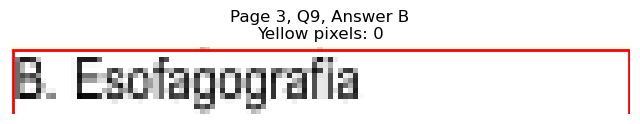

Page 3, Q9 - C: Detected box: x0=315.4, y0=556.5, x1=389.2, y1=569.1
Page 3, Q9, C: Yellow pixels: 0
Page 3, Q9, C: Total non-white pixels: 330
Page 3, Q9, C: Yellow percentage: 0.0%


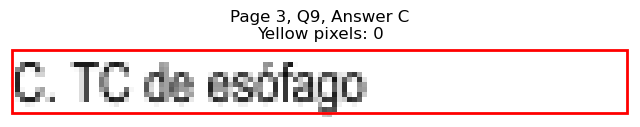

Page 3, Q9 - D: Detected box: x0=315.4, y0=569.1, x1=368.7, y1=581.7
Page 3, Q9, D: Yellow pixels: 0
Page 3, Q9, D: Total non-white pixels: 262
Page 3, Q9, D: Yellow percentage: 0.0%


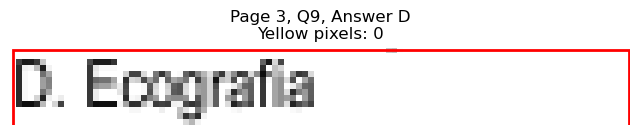


Page 3, Q9 - Selected Answer: A (based on yellow pixel count)
Page 3, Q10 - A: Detected box: x0=56.6, y0=606.9, x1=196.7, y1=619.5
Page 3, Q10, A: Yellow pixels: 0
Page 3, Q10, A: Total non-white pixels: 704
Page 3, Q10, A: Yellow percentage: 0.0%


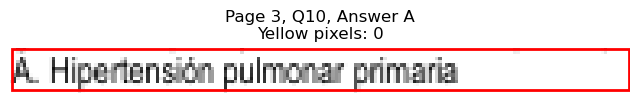

Page 3, Q10 - B: Detected box: x0=56.6, y0=619.6, x1=237.8, y1=632.3
Page 3, Q10, B: Yellow pixels: 0
Page 3, Q10, B: Total non-white pixels: 887
Page 3, Q10, B: Yellow percentage: 0.0%


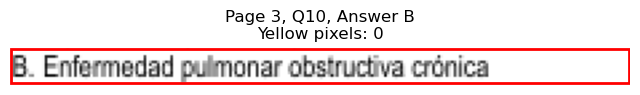

Page 3, Q10 - C: Detected box: x0=315.4, y0=606.9, x1=389.7, y1=619.5
Page 3, Q10, C: Yellow pixels: 0
Page 3, Q10, C: Total non-white pixels: 354
Page 3, Q10, C: Yellow percentage: 0.0%


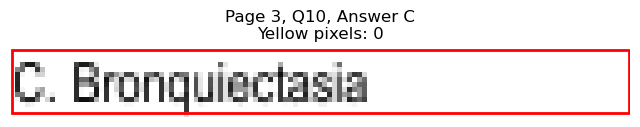

Page 3, Q10 - D: Detected box: x0=315.4, y0=619.6, x1=442.4, y1=632.3
Page 3, Q10, D: Yellow pixels: 1663
Page 3, Q10, D: Total non-white pixels: 2492
Page 3, Q10, D: Yellow percentage: 66.7%


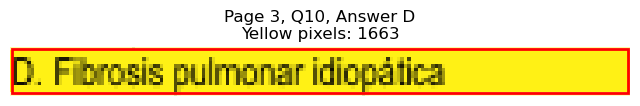


Page 3, Q10 - Selected Answer: D (based on yellow pixel count)
Page 3, Q11 - A: Detected box: x0=56.6, y0=670.0, x1=167.7, y1=682.7
Page 3, Q11, A: Yellow pixels: 0
Page 3, Q11, A: Total non-white pixels: 564
Page 3, Q11, A: Yellow percentage: 0.0%


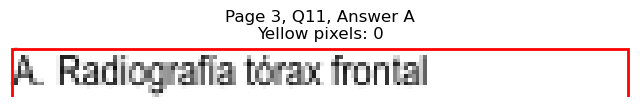

Page 3, Q11 - B: Detected box: x0=56.6, y0=682.6, x1=197.7, y1=695.3
Page 3, Q11, B: Yellow pixels: 0
Page 3, Q11, B: Total non-white pixels: 704
Page 3, Q11, B: Yellow percentage: 0.0%


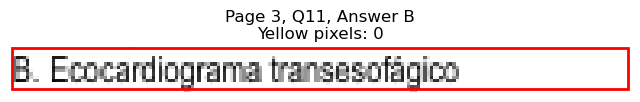

Page 3, Q11 - C: Detected box: x0=315.4, y0=670.0, x1=483.0, y1=682.7
Page 3, Q11, C: Yellow pixels: 2217
Page 3, Q11, C: Total non-white pixels: 2834
Page 3, Q11, C: Yellow percentage: 78.2%


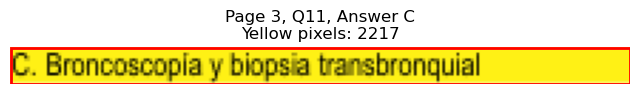

Page 3, Q11 - D: Detected box: x0=315.4, y0=682.6, x1=411.3, y1=695.3
Page 3, Q11, D: Yellow pixels: 146
Page 3, Q11, D: Total non-white pixels: 590
Page 3, Q11, D: Yellow percentage: 24.7%


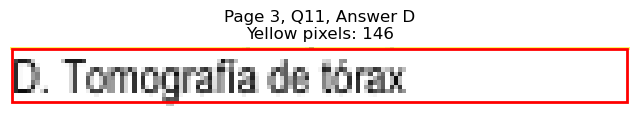


Page 3, Q11 - Selected Answer: C (based on yellow pixel count)
Page 3, Q12 - A: Detected box: x0=56.6, y0=720.6, x1=178.6, y1=733.2
Page 3, Q12, A: Yellow pixels: 173
Page 3, Q12, A: Total non-white pixels: 777
Page 3, Q12, A: Yellow percentage: 22.3%


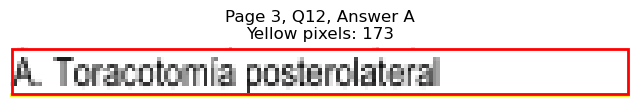

Page 3, Q12 - B: Detected box: x0=56.6, y0=506.0, x1=151.6, y1=518.6
Page 3, Q12, B: Yellow pixels: 0
Page 3, Q12, B: Total non-white pixels: 470
Page 3, Q12, B: Yellow percentage: 0.0%


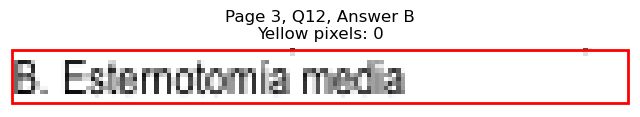

Page 3, Q12 - C: Detected box: x0=315.4, y0=720.6, x1=404.8, y1=733.2
Page 3, Q12, C: Yellow pixels: 0
Page 3, Q12, C: Total non-white pixels: 421
Page 3, Q12, C: Yellow percentage: 0.0%


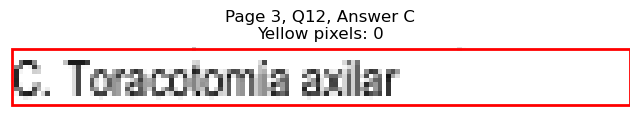

Page 3, Q12 - D: Detected box: x0=315.4, y0=733.2, x1=433.4, y1=745.8
Page 3, Q12, D: Yellow pixels: 0
Page 3, Q12, D: Total non-white pixels: 587
Page 3, Q12, D: Yellow percentage: 0.0%


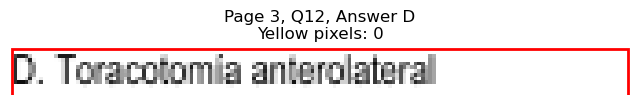


Page 3, Q12 - Selected Answer: A (based on yellow pixel count)

Page 4: Found 11 questions
Page 4, Q1 - A: Detected box: x0=56.6, y0=102.0, x1=93.9, y1=114.7
Page 4, Q1, A: Yellow pixels: 0
Page 4, Q1, A: Total non-white pixels: 154
Page 4, Q1, A: Yellow percentage: 0.0%


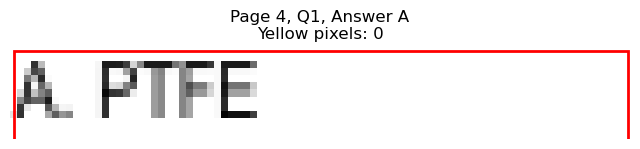

Page 4, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=190.7, y1=127.3
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 650
Page 4, Q1, B: Yellow percentage: 0.0%


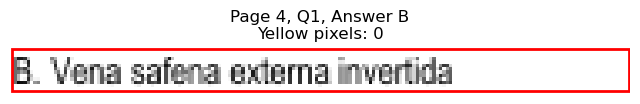

Page 4, Q1 - C: Detected box: x0=315.4, y0=102.0, x1=447.4, y1=114.7
Page 4, Q1, C: Yellow pixels: 1914
Page 4, Q1, C: Total non-white pixels: 2379
Page 4, Q1, C: Yellow percentage: 80.5%


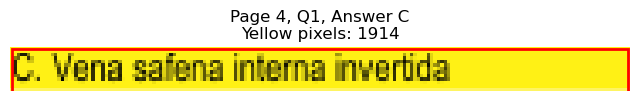

Page 4, Q1 - D: Detected box: x0=315.4, y0=114.6, x1=384.2, y1=127.3
Page 4, Q1, D: Yellow pixels: 120
Page 4, Q1, D: Total non-white pixels: 443
Page 4, Q1, D: Yellow percentage: 27.1%


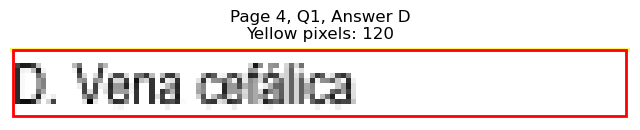


Page 4, Q1 - Selected Answer: C (based on yellow pixel count)
Page 4, Q2 - A: Detected box: x0=56.6, y0=152.5, x1=140.5, y1=165.2
Page 4, Q2, A: Yellow pixels: 135
Page 4, Q2, A: Total non-white pixels: 526
Page 4, Q2, A: Yellow percentage: 25.7%


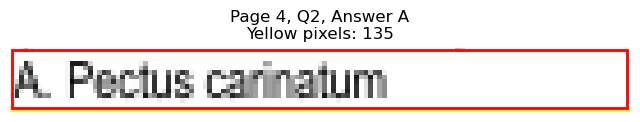

Page 4, Q2 - B: Detected box: x0=56.6, y0=165.1, x1=144.5, y1=177.8
Page 4, Q2, B: Yellow pixels: 1491
Page 4, Q2, B: Total non-white pixels: 1807
Page 4, Q2, B: Yellow percentage: 82.5%


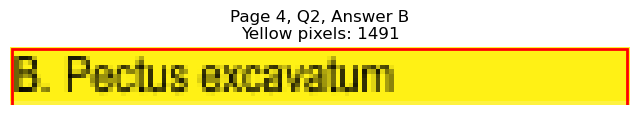

Page 4, Q2 - C: Detected box: x0=315.4, y0=152.5, x1=412.3, y1=165.2
Page 4, Q2, C: Yellow pixels: 0
Page 4, Q2, C: Total non-white pixels: 466
Page 4, Q2, C: Yellow percentage: 0.0%


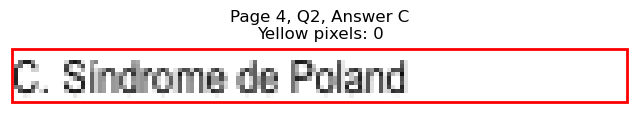

Page 4, Q2 - D: Detected box: x0=315.4, y0=165.1, x1=400.7, y1=177.8
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 419
Page 4, Q2, D: Yellow percentage: 0.0%


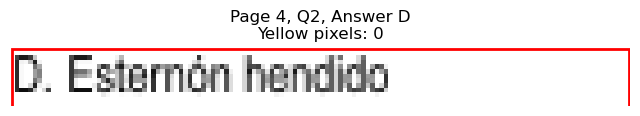


Page 4, Q2 - Selected Answer: B (based on yellow pixel count)
Page 4, Q3 - A: Detected box: x0=56.6, y0=202.9, x1=109.5, y1=215.6
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 280
Page 4, Q3, A: Yellow percentage: 0.0%


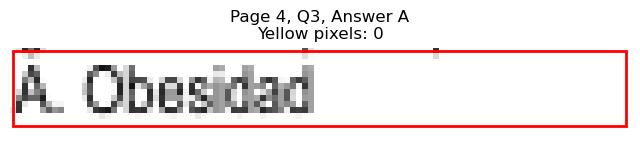

Page 4, Q3 - B: Detected box: x0=56.6, y0=215.6, x1=134.5, y1=228.3
Page 4, Q3, B: Yellow pixels: 0
Page 4, Q3, B: Total non-white pixels: 374
Page 4, Q3, B: Yellow percentage: 0.0%


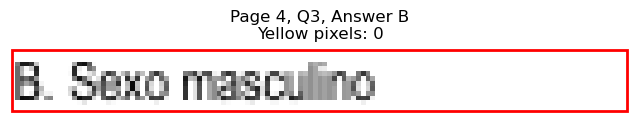

Page 4, Q3 - C: Detected box: x0=315.4, y0=202.9, x1=379.7, y1=215.6
Page 4, Q3, C: Yellow pixels: 1259
Page 4, Q3, C: Total non-white pixels: 1610
Page 4, Q3, C: Yellow percentage: 78.2%


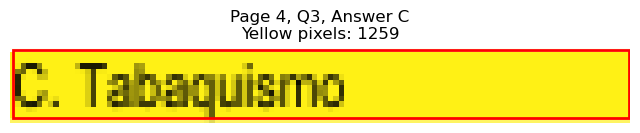

Page 4, Q3 - D: Detected box: x0=315.4, y0=215.6, x1=392.8, y1=228.3
Page 4, Q3, D: Yellow pixels: 128
Page 4, Q3, D: Total non-white pixels: 482
Page 4, Q3, D: Yellow percentage: 26.6%


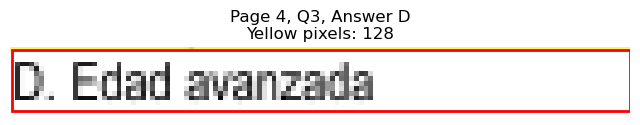


Page 4, Q3 - Selected Answer: C (based on yellow pixel count)
Page 4, Q4 - A: Detected box: x0=56.6, y0=253.4, x1=84.4, y1=266.1
Page 4, Q4, A: Yellow pixels: 0
Page 4, Q4, A: Total non-white pixels: 97
Page 4, Q4, A: Yellow percentage: 0.0%


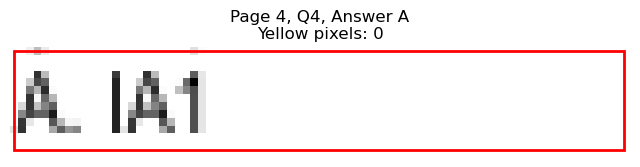

Page 4, Q4 - B: Detected box: x0=56.6, y0=266.0, x1=84.4, y1=278.7
Page 4, Q4, B: Yellow pixels: 0
Page 4, Q4, B: Total non-white pixels: 107
Page 4, Q4, B: Yellow percentage: 0.0%


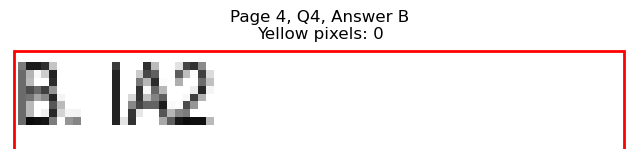

Page 4, Q4 - C: Detected box: x0=315.4, y0=253.4, x1=335.1, y1=266.1
Page 4, Q4, C: Yellow pixels: 877
Page 4, Q4, C: Total non-white pixels: 994
Page 4, Q4, C: Yellow percentage: 88.2%


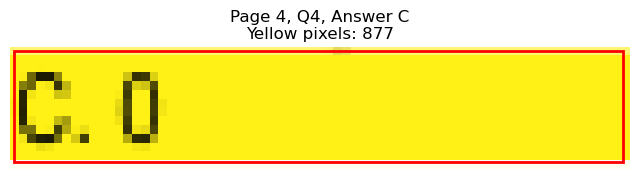

Page 4, Q4 - D: Detected box: x0=315.4, y0=266.0, x1=343.6, y1=278.7
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 195
Page 4, Q4, D: Yellow percentage: 0.0%


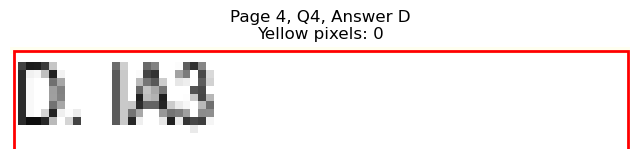


Page 4, Q4 - Selected Answer: C (based on yellow pixel count)
Page 4, Q5 - A: Detected box: x0=56.6, y0=316.6, x1=81.9, y1=329.2
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 102
Page 4, Q5, A: Yellow percentage: 0.0%


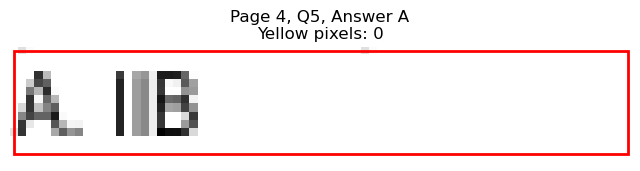

Page 4, Q5 - B: Detected box: x0=56.6, y0=329.2, x1=84.4, y1=341.8
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 112
Page 4, Q5, B: Yellow percentage: 0.0%


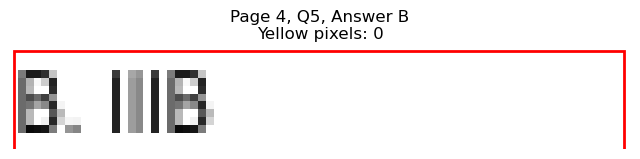

Page 4, Q5 - C: Detected box: x0=315.4, y0=316.6, x1=341.1, y1=329.2
Page 4, Q5, C: Yellow pixels: 77
Page 4, Q5, C: Total non-white pixels: 176
Page 4, Q5, C: Yellow percentage: 43.8%


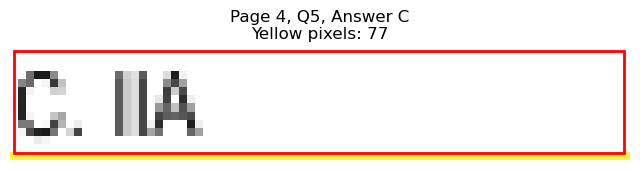

Page 4, Q5 - D: Detected box: x0=315.4, y0=329.2, x1=343.6, y1=341.8
Page 4, Q5, D: Yellow pixels: 929
Page 4, Q5, D: Total non-white pixels: 1027
Page 4, Q5, D: Yellow percentage: 90.5%


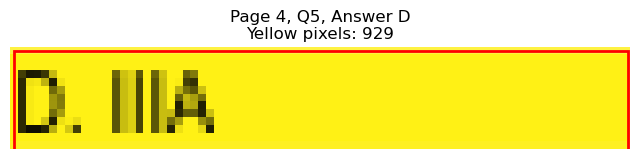


Page 4, Q5 - Selected Answer: D (based on yellow pixel count)
Page 4, Q6 - A: Detected box: x0=56.6, y0=367.1, x1=126.5, y1=379.8
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 465
Page 4, Q6, A: Yellow percentage: 0.0%


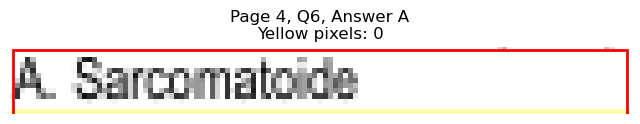

Page 4, Q6 - B: Detected box: x0=56.6, y0=379.7, x1=102.4, y1=392.4
Page 4, Q6, B: Yellow pixels: 962
Page 4, Q6, B: Total non-white pixels: 1358
Page 4, Q6, B: Yellow percentage: 70.8%


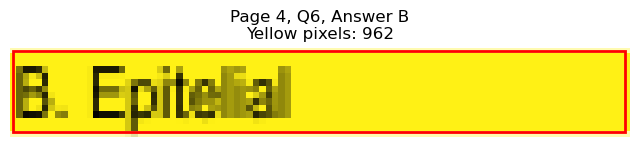

Page 4, Q6 - C: Detected box: x0=315.4, y0=367.1, x1=351.7, y1=379.8
Page 4, Q6, C: Yellow pixels: 0
Page 4, Q6, C: Total non-white pixels: 165
Page 4, Q6, C: Yellow percentage: 0.0%


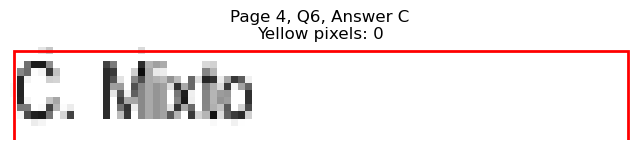

Page 4, Q6 - D: Detected box: x0=315.4, y0=379.7, x1=368.7, y1=392.4
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 247
Page 4, Q6, D: Yellow percentage: 0.0%


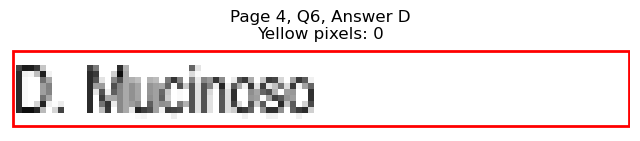


Page 4, Q6 - Selected Answer: B (based on yellow pixel count)
Page 4, Q7 - A: Detected box: x0=56.6, y0=430.2, x1=169.1, y1=442.9
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 541
Page 4, Q7, A: Yellow percentage: 0.0%


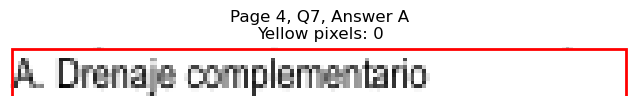

Page 4, Q7 - B: Detected box: x0=56.6, y0=442.8, x1=150.0, y1=455.5
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 431
Page 4, Q7, B: Yellow percentage: 0.0%


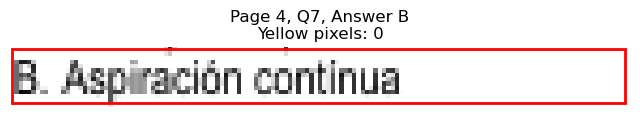

Page 4, Q7 - C: Detected box: x0=315.4, y0=430.2, x1=440.3, y1=442.9
Page 4, Q7, C: Yellow pixels: 0
Page 4, Q7, C: Total non-white pixels: 759
Page 4, Q7, C: Yellow percentage: 0.0%


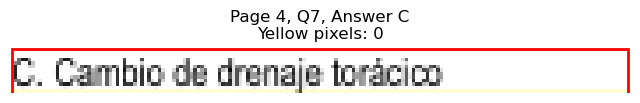

Page 4, Q7 - D: Detected box: x0=315.4, y0=442.8, x1=430.9, y1=455.5
Page 4, Q7, D: Yellow pixels: 1706
Page 4, Q7, D: Total non-white pixels: 2324
Page 4, Q7, D: Yellow percentage: 73.4%


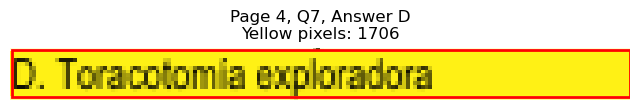


Page 4, Q7 - Selected Answer: D (based on yellow pixel count)
Page 4, Q8 - A: Detected box: x0=56.6, y0=506.0, x1=136.5, y1=518.6
Page 4, Q8, A: Yellow pixels: 1408
Page 4, Q8, A: Total non-white pixels: 1834
Page 4, Q8, A: Yellow percentage: 76.8%


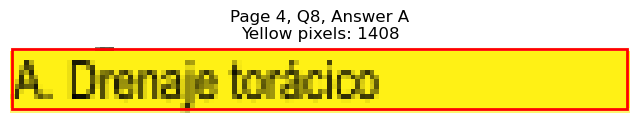

Page 4, Q8 - B: Detected box: x0=56.6, y0=518.6, x1=138.5, y1=531.2
Page 4, Q8, B: Yellow pixels: 132
Page 4, Q8, B: Total non-white pixels: 522
Page 4, Q8, B: Yellow percentage: 25.3%


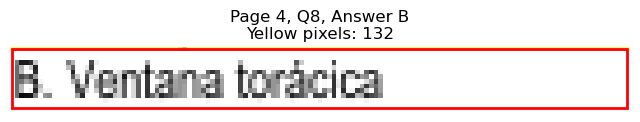

Page 4, Q8 - C: Detected box: x0=315.4, y0=506.0, x1=380.8, y1=518.6
Page 4, Q8, C: Yellow pixels: 0
Page 4, Q8, C: Total non-white pixels: 300
Page 4, Q8, C: Yellow percentage: 0.0%


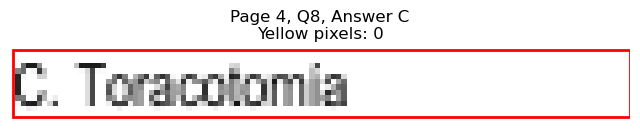

Page 4, Q8 - D: Detected box: x0=315.4, y0=518.6, x1=404.8, y1=531.2
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 436
Page 4, Q8, D: Yellow percentage: 0.0%


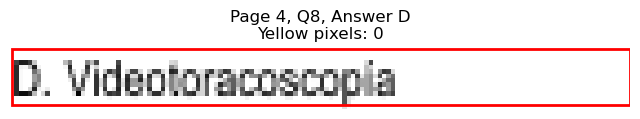


Page 4, Q8 - Selected Answer: A (based on yellow pixel count)
Page 4, Q9 - A: Detected box: x0=56.6, y0=556.5, x1=196.7, y1=569.1
Page 4, Q9, A: Yellow pixels: 1910
Page 4, Q9, A: Total non-white pixels: 2674
Page 4, Q9, A: Yellow percentage: 71.4%


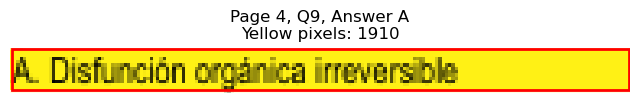

Page 4, Q9 - B: Detected box: x0=56.6, y0=569.1, x1=161.5, y1=581.7
Page 4, Q9, B: Yellow pixels: 0
Page 4, Q9, B: Total non-white pixels: 647
Page 4, Q9, B: Yellow percentage: 0.0%


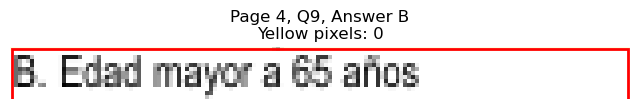

Page 4, Q9 - C: Detected box: x0=315.4, y0=556.5, x1=433.4, y1=569.1
Page 4, Q9, C: Yellow pixels: 0
Page 4, Q9, C: Total non-white pixels: 551
Page 4, Q9, C: Yellow percentage: 0.0%


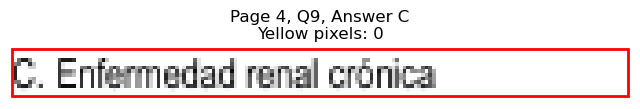

Page 4, Q9 - D: Detected box: x0=315.4, y0=569.1, x1=414.8, y1=581.7
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 489
Page 4, Q9, D: Yellow percentage: 0.0%


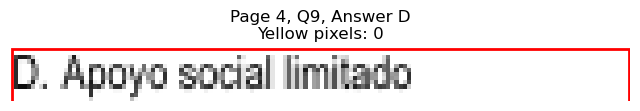


Page 4, Q9 - Selected Answer: A (based on yellow pixel count)
Page 4, Q10 - A: Detected box: x0=56.6, y0=619.6, x1=291.5, y1=632.3
Page 4, Q10, A: Yellow pixels: 0
Page 4, Q10, A: Total non-white pixels: 1165
Page 4, Q10, A: Yellow percentage: 0.0%


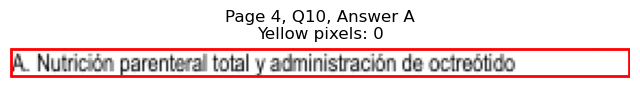

Page 4, Q10 - B: Detected box: x0=56.6, y0=632.2, x1=346.3, y1=644.9
Page 4, Q10, B: Yellow pixels: 0
Page 4, Q10, B: Total non-white pixels: 1707
Page 4, Q10, B: Yellow percentage: 0.0%


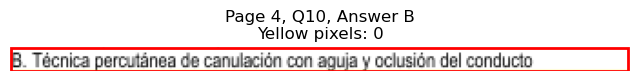

Page 4, Q10 - C: Detected box: x0=56.6, y0=644.8, x1=301.0, y1=657.5
Page 4, Q10, C: Yellow pixels: 2933
Page 4, Q10, C: Total non-white pixels: 4144
Page 4, Q10, C: Yellow percentage: 70.8%


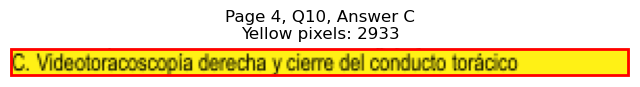

Page 4, Q10 - D: Detected box: x0=56.6, y0=657.4, x1=254.3, y1=670.1
Page 4, Q10, D: Yellow pixels: 248
Page 4, Q10, D: Total non-white pixels: 1239
Page 4, Q10, D: Yellow percentage: 20.0%


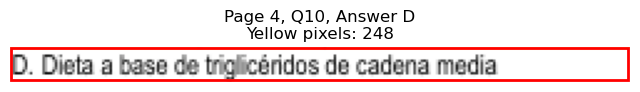


Page 4, Q10 - Selected Answer: C (based on yellow pixel count)
Page 4, Q11 - A: Detected box: x0=56.6, y0=695.4, x1=192.6, y1=708.0
Page 4, Q11, A: Yellow pixels: 0
Page 4, Q11, A: Total non-white pixels: 609
Page 4, Q11, A: Yellow percentage: 0.0%


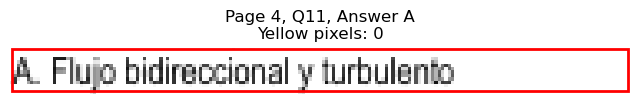

Page 4, Q11 - B: Detected box: x0=56.6, y0=708.0, x1=202.7, y1=720.6
Page 4, Q11, B: Yellow pixels: 0
Page 4, Q11, B: Total non-white pixels: 759
Page 4, Q11, B: Yellow percentage: 0.0%


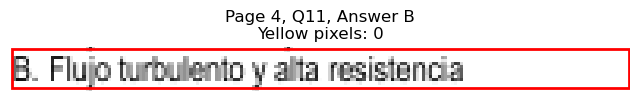

Page 4, Q11 - C: Detected box: x0=56.6, y0=720.6, x1=289.5, y1=733.2
Page 4, Q11, C: Yellow pixels: 284
Page 4, Q11, C: Total non-white pixels: 1391
Page 4, Q11, C: Yellow percentage: 20.4%


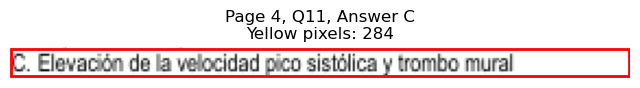

Page 4, Q11 - D: Detected box: x0=56.6, y0=733.2, x1=220.7, y1=745.8
Page 4, Q11, D: Yellow pixels: 2172
Page 4, Q11, D: Total non-white pixels: 2795
Page 4, Q11, D: Yellow percentage: 77.7%


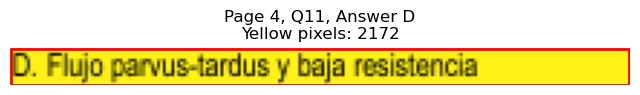


Page 4, Q11 - Selected Answer: D (based on yellow pixel count)

Page 5: Found 12 questions
Page 5, Q1 - A: Detected box: x0=56.6, y0=102.0, x1=111.4, y1=114.7
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 276
Page 5, Q1, A: Yellow percentage: 0.0%


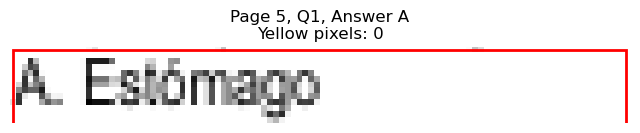

Page 5, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=100.9, y1=127.3
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 195
Page 5, Q1, B: Yellow percentage: 0.0%


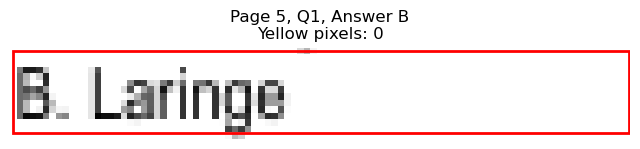

Page 5, Q1 - C: Detected box: x0=315.4, y0=102.0, x1=363.7, y1=114.7
Page 5, Q1, C: Yellow pixels: 0
Page 5, Q1, C: Total non-white pixels: 316
Page 5, Q1, C: Yellow percentage: 0.0%


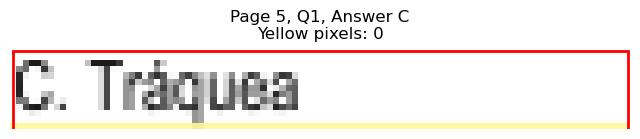

Page 5, Q1 - D: Detected box: x0=315.4, y0=114.6, x1=363.2, y1=127.3
Page 5, Q1, D: Yellow pixels: 1021
Page 5, Q1, D: Total non-white pixels: 1386
Page 5, Q1, D: Yellow percentage: 73.7%


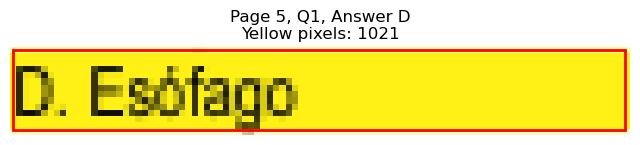


Page 5, Q1 - Selected Answer: D (based on yellow pixel count)
Page 5, Q2 - A: Detected box: x0=56.6, y0=152.5, x1=138.5, y1=165.2
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 391
Page 5, Q2, A: Yellow percentage: 0.0%


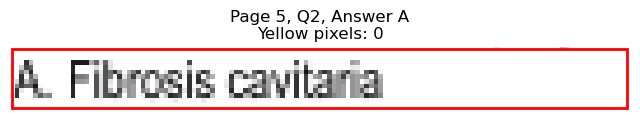

Page 5, Q2 - B: Detected box: x0=56.6, y0=165.1, x1=175.6, y1=177.8
Page 5, Q2, B: Yellow pixels: 0
Page 5, Q2, B: Total non-white pixels: 617
Page 5, Q2, B: Yellow percentage: 0.0%


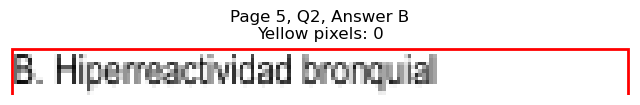

Page 5, Q2 - C: Detected box: x0=315.4, y0=152.5, x1=449.5, y1=165.2
Page 5, Q2, C: Yellow pixels: 1905
Page 5, Q2, C: Total non-white pixels: 2590
Page 5, Q2, C: Yellow percentage: 73.6%


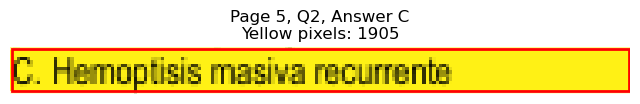

Page 5, Q2 - D: Detected box: x0=315.4, y0=165.1, x1=421.4, y1=177.8
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 676
Page 5, Q2, D: Yellow percentage: 0.0%


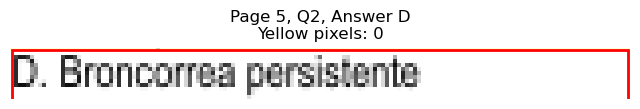


Page 5, Q2 - Selected Answer: C (based on yellow pixel count)
Page 5, Q3 - A: Detected box: x0=56.6, y0=215.6, x1=240.4, y1=228.3
Page 5, Q3, A: Yellow pixels: 2022
Page 5, Q3, A: Total non-white pixels: 3164
Page 5, Q3, A: Yellow percentage: 63.9%


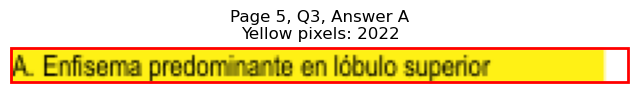

Page 5, Q3 - B: Detected box: x0=56.6, y0=228.2, x1=196.0, y1=240.9
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 820
Page 5, Q3, B: Yellow percentage: 0.0%


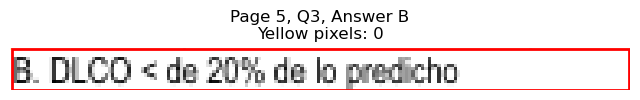

Page 5, Q3 - C: Detected box: x0=315.4, y0=215.6, x1=440.1, y1=228.3
Page 5, Q3, C: Yellow pixels: 0
Page 5, Q3, C: Total non-white pixels: 553
Page 5, Q3, C: Yellow percentage: 0.0%


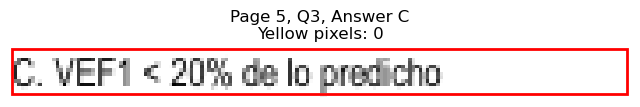

Page 5, Q3 - D: Detected box: x0=315.4, y0=228.2, x1=394.3, y1=240.9
Page 5, Q3, D: Yellow pixels: 0
Page 5, Q3, D: Total non-white pixels: 377
Page 5, Q3, D: Yellow percentage: 0.0%


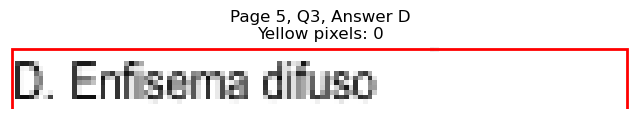


Page 5, Q3 - Selected Answer: A (based on yellow pixel count)
Page 5, Q4 - A: Detected box: x0=56.6, y0=266.0, x1=142.0, y1=278.7
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 388
Page 5, Q4, A: Yellow percentage: 0.0%


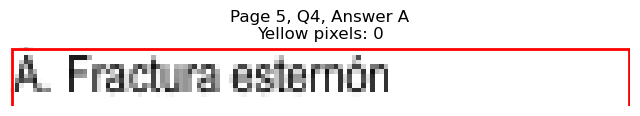

Page 5, Q4 - B: Detected box: x0=56.6, y0=278.8, x1=151.6, y1=291.4
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 444
Page 5, Q4, B: Yellow percentage: 0.0%


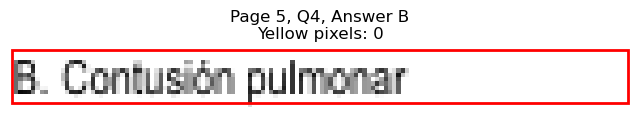

Page 5, Q4 - C: Detected box: x0=315.4, y0=266.0, x1=379.1, y1=278.7
Page 5, Q4, C: Yellow pixels: 0
Page 5, Q4, C: Total non-white pixels: 298
Page 5, Q4, C: Yellow percentage: 0.0%


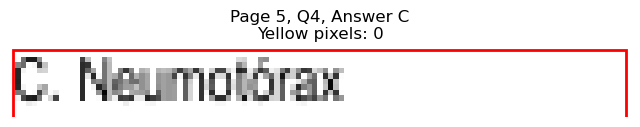

Page 5, Q4 - D: Detected box: x0=315.4, y0=278.8, x1=389.7, y1=291.4
Page 5, Q4, D: Yellow pixels: 1341
Page 5, Q4, D: Total non-white pixels: 1750
Page 5, Q4, D: Yellow percentage: 76.6%


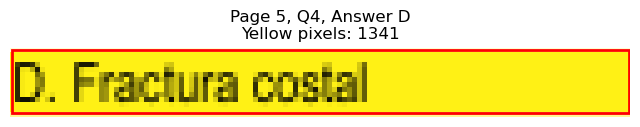


Page 5, Q4 - Selected Answer: D (based on yellow pixel count)
Page 5, Q5 - A: Detected box: x0=56.6, y0=316.6, x1=124.9, y1=329.2
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 313
Page 5, Q5, A: Yellow percentage: 0.0%


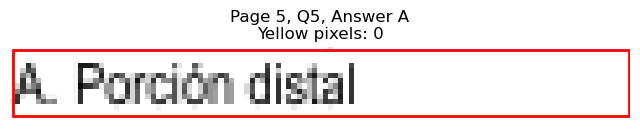

Page 5, Q5 - B: Detected box: x0=56.6, y0=329.2, x1=160.6, y1=341.8
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 523
Page 5, Q5, B: Yellow percentage: 0.0%


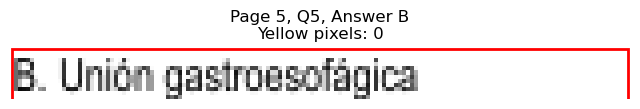

Page 5, Q5 - C: Detected box: x0=315.4, y0=316.6, x1=449.5, y1=329.2
Page 5, Q5, C: Yellow pixels: 185
Page 5, Q5, C: Total non-white pixels: 878
Page 5, Q5, C: Yellow percentage: 21.1%


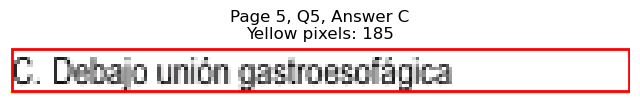

Page 5, Q5 - D: Detected box: x0=315.4, y0=329.2, x1=431.3, y1=341.8
Page 5, Q5, D: Yellow pixels: 1767
Page 5, Q5, D: Total non-white pixels: 2171
Page 5, Q5, D: Yellow percentage: 81.4%


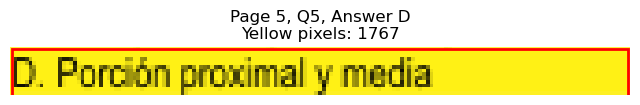


Page 5, Q5 - Selected Answer: D (based on yellow pixel count)
Page 5, Q6 - A: Detected box: x0=56.6, y0=367.1, x1=129.5, y1=379.8
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 482
Page 5, Q6, A: Yellow percentage: 0.0%


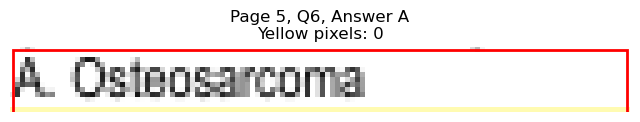

Page 5, Q6 - B: Detected box: x0=56.6, y0=379.7, x1=135.0, y1=392.4
Page 5, Q6, B: Yellow pixels: 1283
Page 5, Q6, B: Total non-white pixels: 1820
Page 5, Q6, B: Yellow percentage: 70.5%


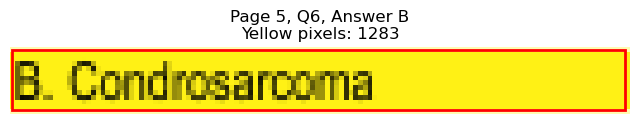

Page 5, Q6 - C: Detected box: x0=315.4, y0=367.1, x1=420.3, y1=379.8
Page 5, Q6, C: Yellow pixels: 0
Page 5, Q6, C: Total non-white pixels: 500
Page 5, Q6, C: Yellow percentage: 0.0%


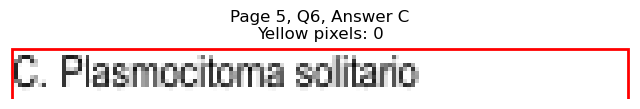

Page 5, Q6 - D: Detected box: x0=315.4, y0=379.7, x1=405.8, y1=392.4
Page 5, Q6, D: Yellow pixels: 0
Page 5, Q6, D: Total non-white pixels: 429
Page 5, Q6, D: Yellow percentage: 0.0%


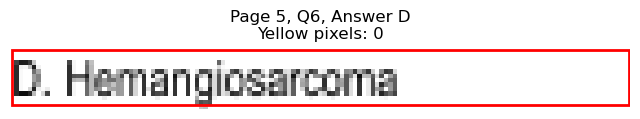


Page 5, Q6 - Selected Answer: B (based on yellow pixel count)
Page 5, Q7 - A: Detected box: x0=56.6, y0=417.6, x1=168.1, y1=430.3
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 532
Page 5, Q7, A: Yellow percentage: 0.0%


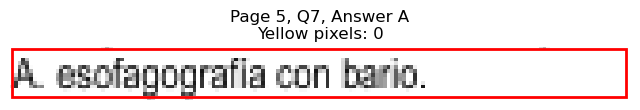

Page 5, Q7 - B: Detected box: x0=56.6, y0=430.2, x1=116.4, y1=442.9
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 273
Page 5, Q7, B: Yellow percentage: 0.0%


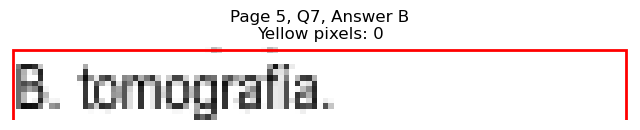

Page 5, Q7 - C: Detected box: x0=315.4, y0=417.6, x1=414.3, y1=430.3
Page 5, Q7, C: Yellow pixels: 1452
Page 5, Q7, C: Total non-white pixels: 2100
Page 5, Q7, C: Yellow percentage: 69.1%


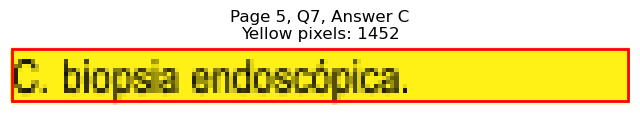

Page 5, Q7 - D: Detected box: x0=315.4, y0=430.2, x1=370.1, y1=442.9
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 360
Page 5, Q7, D: Yellow percentage: 0.0%


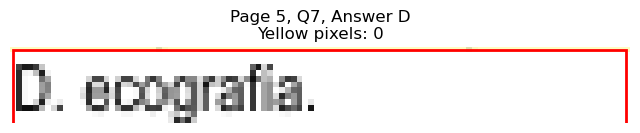


Page 5, Q7 - Selected Answer: C (based on yellow pixel count)
Page 5, Q8 - A: Detected box: x0=56.6, y0=468.1, x1=137.1, y1=480.7
Page 5, Q8, A: Yellow pixels: 0
Page 5, Q8, A: Total non-white pixels: 353
Page 5, Q8, A: Yellow percentage: 0.0%


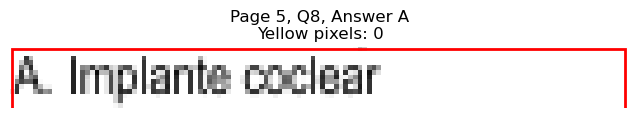

Page 5, Q8 - B: Detected box: x0=56.6, y0=480.8, x1=205.5, y1=493.4
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 722
Page 5, Q8, B: Yellow percentage: 0.0%


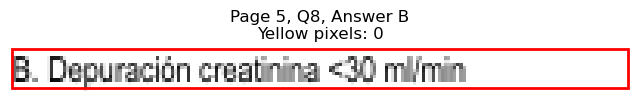

Page 5, Q8 - C: Detected box: x0=315.4, y0=468.1, x1=437.8, y1=480.7
Page 5, Q8, C: Yellow pixels: 0
Page 5, Q8, C: Total non-white pixels: 581
Page 5, Q8, C: Yellow percentage: 0.0%


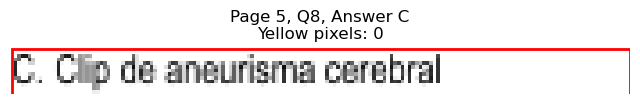

Page 5, Q8 - D: Detected box: x0=315.4, y0=480.8, x1=464.7, y1=493.4
Page 5, Q8, D: Yellow pixels: 1830
Page 5, Q8, D: Total non-white pixels: 2800
Page 5, Q8, D: Yellow percentage: 65.4%


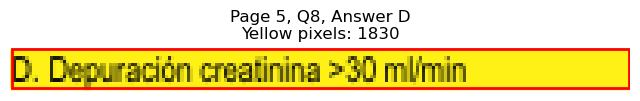


Page 5, Q8 - Selected Answer: D (based on yellow pixel count)
Page 5, Q9 - A: Detected box: x0=56.6, y0=543.8, x1=161.1, y1=556.4
Page 5, Q9, A: Yellow pixels: 0
Page 5, Q9, A: Total non-white pixels: 523
Page 5, Q9, A: Yellow percentage: 0.0%


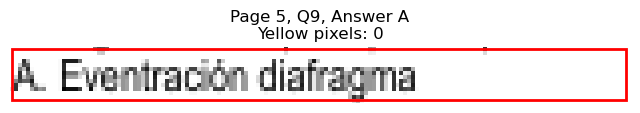

Page 5, Q9 - B: Detected box: x0=56.6, y0=556.5, x1=154.1, y1=569.1
Page 5, Q9, B: Yellow pixels: 1557
Page 5, Q9, B: Total non-white pixels: 2086
Page 5, Q9, B: Yellow percentage: 74.6%


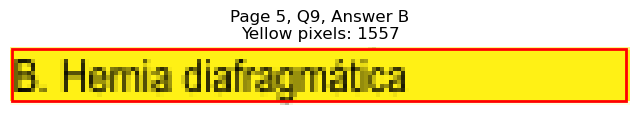

Page 5, Q9 - C: Detected box: x0=315.4, y0=543.8, x1=408.3, y1=556.4
Page 5, Q9, C: Yellow pixels: 0
Page 5, Q9, C: Total non-white pixels: 443
Page 5, Q9, C: Yellow percentage: 0.0%


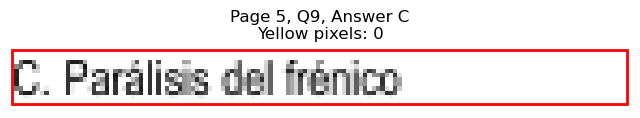

Page 5, Q9 - D: Detected box: x0=315.4, y0=556.5, x1=401.7, y1=569.1
Page 5, Q9, D: Yellow pixels: 0
Page 5, Q9, D: Total non-white pixels: 396
Page 5, Q9, D: Yellow percentage: 0.0%


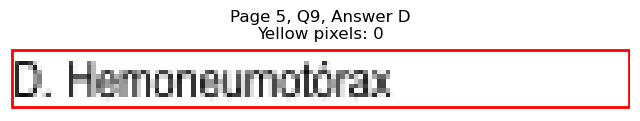


Page 5, Q9 - Selected Answer: B (based on yellow pixel count)
Page 5, Q10 - A: Detected box: x0=56.6, y0=594.3, x1=126.0, y1=606.9
Page 5, Q10, A: Yellow pixels: 1301
Page 5, Q10, A: Total non-white pixels: 1573
Page 5, Q10, A: Yellow percentage: 82.7%


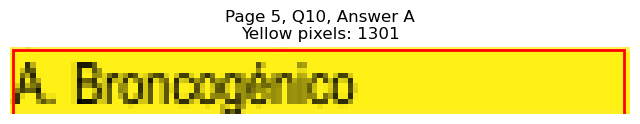

Page 5, Q10 - B: Detected box: x0=56.6, y0=606.9, x1=115.9, y1=619.5
Page 5, Q10, B: Yellow pixels: 106
Page 5, Q10, B: Total non-white pixels: 412
Page 5, Q10, B: Yellow percentage: 25.7%


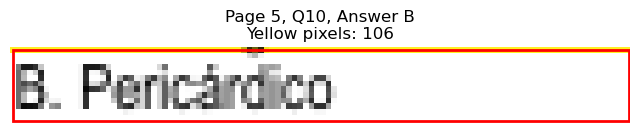

Page 5, Q10 - C: Detected box: x0=315.4, y0=594.3, x1=363.2, y1=606.9
Page 5, Q10, C: Yellow pixels: 0
Page 5, Q10, C: Total non-white pixels: 208
Page 5, Q10, C: Yellow percentage: 0.0%


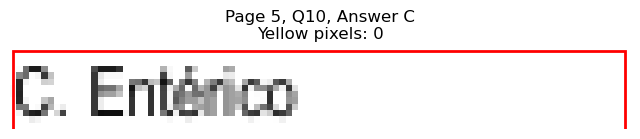

Page 5, Q10 - D: Detected box: x0=315.4, y0=606.9, x1=357.2, y1=619.5
Page 5, Q10, D: Yellow pixels: 0
Page 5, Q10, D: Total non-white pixels: 175
Page 5, Q10, D: Yellow percentage: 0.0%


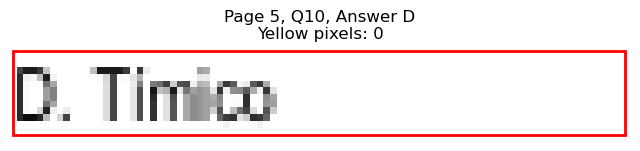


Page 5, Q10 - Selected Answer: A (based on yellow pixel count)
Page 5, Q11 - A: Detected box: x0=56.6, y0=657.4, x1=177.1, y1=670.1
Page 5, Q11, A: Yellow pixels: 0
Page 5, Q11, A: Total non-white pixels: 606
Page 5, Q11, A: Yellow percentage: 0.0%


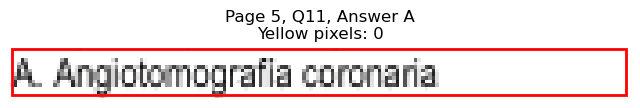

Page 5, Q11 - B: Detected box: x0=56.6, y0=670.0, x1=190.7, y1=682.7
Page 5, Q11, B: Yellow pixels: 0
Page 5, Q11, B: Total non-white pixels: 651
Page 5, Q11, B: Yellow percentage: 0.0%


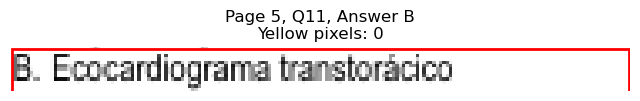

Page 5, Q11 - C: Detected box: x0=315.4, y0=657.4, x1=414.3, y1=670.1
Page 5, Q11, C: Yellow pixels: 150
Page 5, Q11, C: Total non-white pixels: 637
Page 5, Q11, C: Yellow percentage: 23.5%


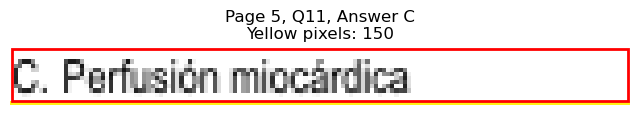

Page 5, Q11 - D: Detected box: x0=315.4, y0=670.0, x1=415.9, y1=682.7
Page 5, Q11, D: Yellow pixels: 1586
Page 5, Q11, D: Total non-white pixels: 1963
Page 5, Q11, D: Yellow percentage: 80.8%


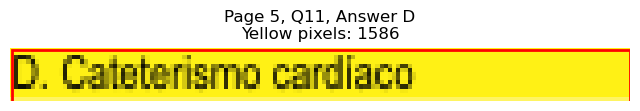


Page 5, Q11 - Selected Answer: D (based on yellow pixel count)
Page 5, Q12 - A: Detected box: x0=56.6, y0=708.0, x1=161.1, y1=720.6
Page 5, Q12, A: Yellow pixels: 1624
Page 5, Q12, A: Total non-white pixels: 2184
Page 5, Q12, A: Yellow percentage: 74.4%


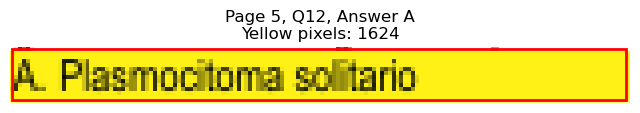

Page 5, Q12 - B: Detected box: x0=56.6, y0=720.6, x1=131.5, y1=733.2
Page 5, Q12, B: Yellow pixels: 126
Page 5, Q12, B: Total non-white pixels: 499
Page 5, Q12, B: Yellow percentage: 25.3%


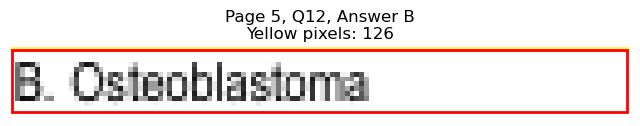

Page 5, Q12 - C: Detected box: x0=315.4, y0=708.0, x1=394.3, y1=720.6
Page 5, Q12, C: Yellow pixels: 0
Page 5, Q12, C: Total non-white pixels: 367
Page 5, Q12, C: Yellow percentage: 0.0%


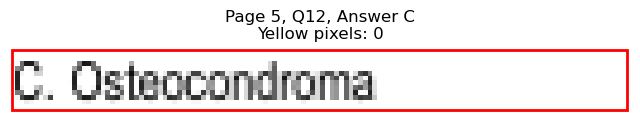

Page 5, Q12 - D: Detected box: x0=315.4, y0=720.6, x1=396.3, y1=733.2
Page 5, Q12, D: Yellow pixels: 0
Page 5, Q12, D: Total non-white pixels: 413
Page 5, Q12, D: Yellow percentage: 0.0%


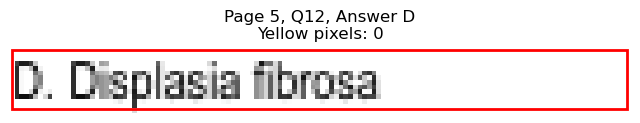


Page 5, Q12 - Selected Answer: A (based on yellow pixel count)

Page 6: Found 11 questions
Page 6, Q1 - A: Detected box: x0=56.6, y0=89.4, x1=146.1, y1=102.1
Page 6, Q1, A: Yellow pixels: 1499
Page 6, Q1, A: Total non-white pixels: 1974
Page 6, Q1, A: Yellow percentage: 75.9%


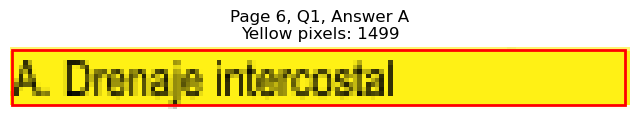

Page 6, Q1 - B: Detected box: x0=56.6, y0=102.0, x1=171.1, y1=114.7
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 735
Page 6, Q1, B: Yellow percentage: 0.0%


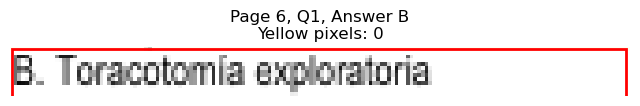

Page 6, Q1 - C: Detected box: x0=315.4, y0=89.4, x1=397.7, y1=102.1
Page 6, Q1, C: Yellow pixels: 0
Page 6, Q1, C: Total non-white pixels: 389
Page 6, Q1, C: Yellow percentage: 0.0%


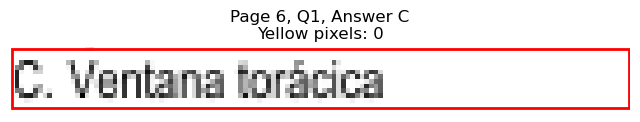

Page 6, Q1 - D: Detected box: x0=315.4, y0=102.0, x1=404.8, y1=114.7
Page 6, Q1, D: Yellow pixels: 0
Page 6, Q1, D: Total non-white pixels: 441
Page 6, Q1, D: Yellow percentage: 0.0%


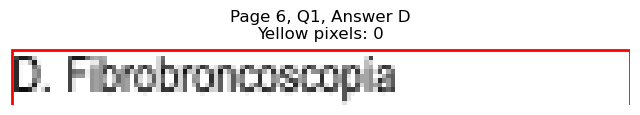


Page 6, Q1 - Selected Answer: A (based on yellow pixel count)
Page 6, Q2 - A: Detected box: x0=56.6, y0=139.9, x1=334.1, y1=152.6
Page 6, Q2, A: Yellow pixels: 3268
Page 6, Q2, A: Total non-white pixels: 4606
Page 6, Q2, A: Yellow percentage: 71.0%


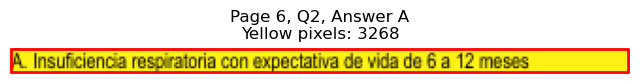

Page 6, Q2 - B: Detected box: x0=56.6, y0=152.5, x1=298.1, y1=165.2
Page 6, Q2, B: Yellow pixels: 293
Page 6, Q2, B: Total non-white pixels: 1506
Page 6, Q2, B: Yellow percentage: 19.5%


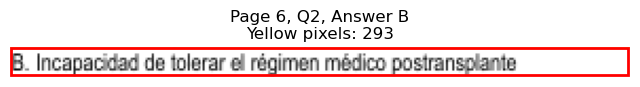

Page 6, Q2 - C: Detected box: x0=56.6, y0=165.1, x1=329.6, y1=177.8
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 1390
Page 6, Q2, C: Yellow percentage: 0.0%


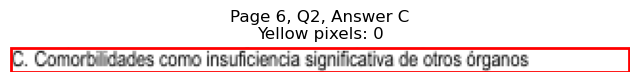

Page 6, Q2 - D: Detected box: x0=56.6, y0=177.7, x1=342.1, y1=190.4
Page 6, Q2, D: Yellow pixels: 0
Page 6, Q2, D: Total non-white pixels: 1382
Page 6, Q2, D: Yellow percentage: 0.0%


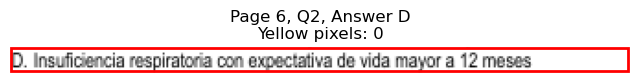


Page 6, Q2 - Selected Answer: A (based on yellow pixel count)
Page 6, Q3 - A: Detected box: x0=56.6, y0=240.8, x1=120.5, y1=253.5
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 350
Page 6, Q3, A: Yellow percentage: 0.0%


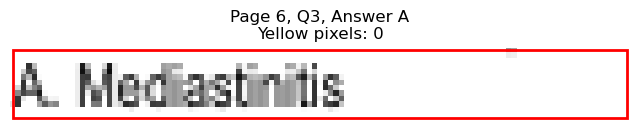

Page 6, Q3 - B: Detected box: x0=56.6, y0=506.0, x1=120.0, y1=518.6
Page 6, Q3, B: Yellow pixels: 114
Page 6, Q3, B: Total non-white pixels: 635
Page 6, Q3, B: Yellow percentage: 18.0%


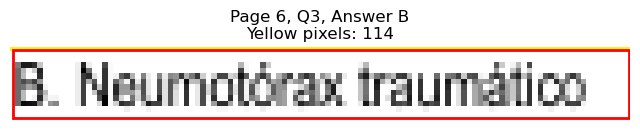

Page 6, Q3 - C: Detected box: x0=315.4, y0=240.8, x1=402.8, y1=253.5
Page 6, Q3, C: Yellow pixels: 1445
Page 6, Q3, C: Total non-white pixels: 1932
Page 6, Q3, C: Yellow percentage: 74.8%


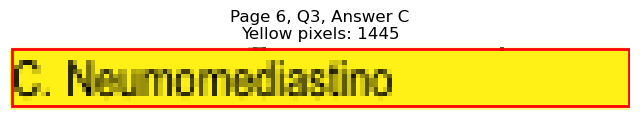

Page 6, Q3 - D: Detected box: x0=315.4, y0=253.4, x1=398.2, y1=266.1
Page 6, Q3, D: Yellow pixels: 134
Page 6, Q3, D: Total non-white pixels: 541
Page 6, Q3, D: Yellow percentage: 24.8%


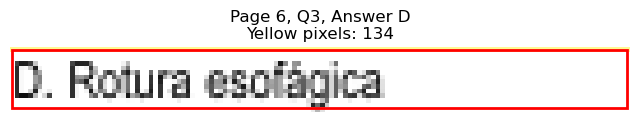


Page 6, Q3 - Selected Answer: C (based on yellow pixel count)
Page 6, Q4 - A: Detected box: x0=56.6, y0=291.4, x1=153.5, y1=304.0
Page 6, Q4, A: Yellow pixels: 0
Page 6, Q4, A: Total non-white pixels: 439
Page 6, Q4, A: Yellow percentage: 0.0%


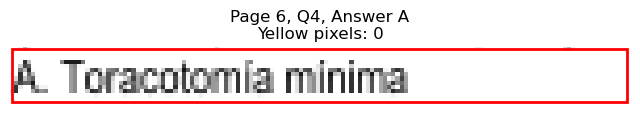

Page 6, Q4 - B: Detected box: x0=56.6, y0=304.0, x1=150.0, y1=316.6
Page 6, Q4, B: Yellow pixels: 0
Page 6, Q4, B: Total non-white pixels: 443
Page 6, Q4, B: Yellow percentage: 0.0%


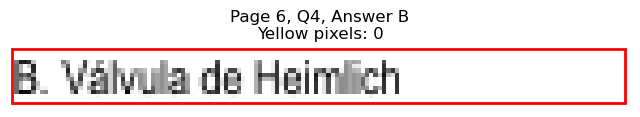

Page 6, Q4 - C: Detected box: x0=315.4, y0=291.4, x1=497.6, y1=304.0
Page 6, Q4, C: Yellow pixels: 2222
Page 6, Q4, C: Total non-white pixels: 3163
Page 6, Q4, C: Yellow percentage: 70.2%


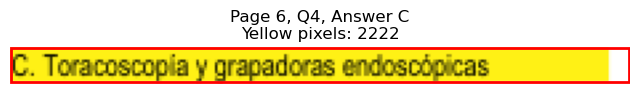

Page 6, Q4 - D: Detected box: x0=315.4, y0=304.0, x1=395.7, y1=316.6
Page 6, Q4, D: Yellow pixels: 123
Page 6, Q4, D: Total non-white pixels: 658
Page 6, Q4, D: Yellow percentage: 18.7%


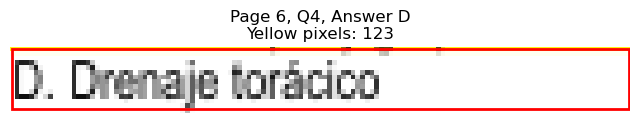


Page 6, Q4 - Selected Answer: C (based on yellow pixel count)
Page 6, Q5 - A: Detected box: x0=56.6, y0=367.1, x1=84.4, y1=379.8
Page 6, Q5, A: Yellow pixels: 0
Page 6, Q5, A: Total non-white pixels: 183
Page 6, Q5, A: Yellow percentage: 0.0%


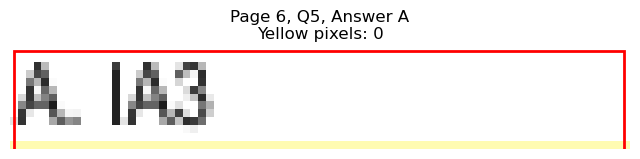

Page 6, Q5 - B: Detected box: x0=56.6, y0=379.7, x1=79.3, y1=392.4
Page 6, Q5, B: Yellow pixels: 808
Page 6, Q5, B: Total non-white pixels: 1036
Page 6, Q5, B: Yellow percentage: 78.0%


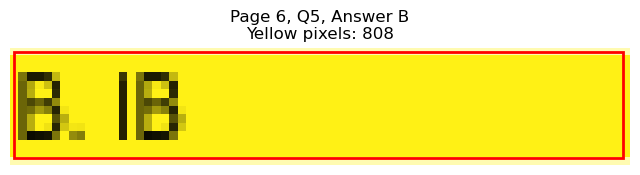

Page 6, Q5 - C: Detected box: x0=315.4, y0=367.1, x1=341.1, y1=379.8
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 99
Page 6, Q5, C: Yellow percentage: 0.0%


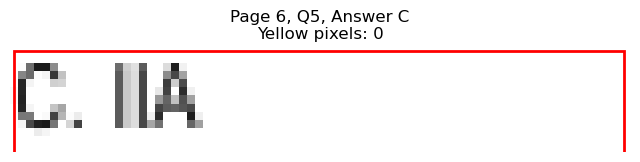

Page 6, Q5 - D: Detected box: x0=315.4, y0=379.7, x1=341.1, y1=392.4
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 109
Page 6, Q5, D: Yellow percentage: 0.0%


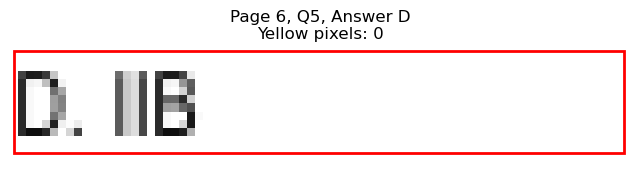


Page 6, Q5 - Selected Answer: B (based on yellow pixel count)
Page 6, Q6 - A: Detected box: x0=56.6, y0=417.6, x1=263.0, y1=430.3
Page 6, Q6, A: Yellow pixels: 0
Page 6, Q6, A: Total non-white pixels: 1006
Page 6, Q6, A: Yellow percentage: 0.0%


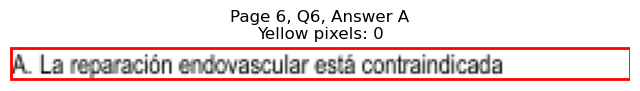

Page 6, Q6 - B: Detected box: x0=56.6, y0=430.2, x1=324.5, y1=442.9
Page 6, Q6, B: Yellow pixels: 0
Page 6, Q6, B: Total non-white pixels: 1611
Page 6, Q6, B: Yellow percentage: 0.0%


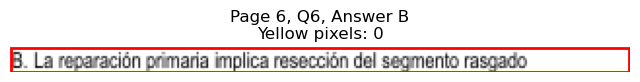

Page 6, Q6 - C: Detected box: x0=56.6, y0=442.8, x1=299.0, y1=455.5
Page 6, Q6, C: Yellow pixels: 2908
Page 6, Q6, C: Total non-white pixels: 4102
Page 6, Q6, C: Yellow percentage: 70.9%


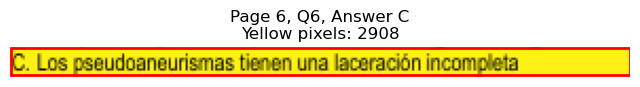

Page 6, Q6 - D: Detected box: x0=56.6, y0=455.5, x1=372.2, y1=468.1
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 1499
Page 6, Q6, D: Yellow percentage: 0.0%


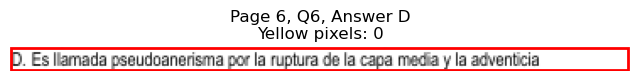


Page 6, Q6 - Selected Answer: C (based on yellow pixel count)
Page 6, Q7 - A: Detected box: x0=56.6, y0=493.4, x1=166.1, y1=506.0
Page 6, Q7, A: Yellow pixels: 1697
Page 6, Q7, A: Total non-white pixels: 2093
Page 6, Q7, A: Yellow percentage: 81.1%


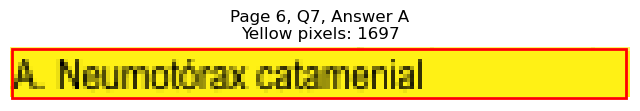

Page 6, Q7 - B: Detected box: x0=56.6, y0=506.0, x1=164.5, y1=518.6
Page 6, Q7, B: Yellow pixels: 159
Page 6, Q7, B: Total non-white pixels: 680
Page 6, Q7, B: Yellow percentage: 23.4%


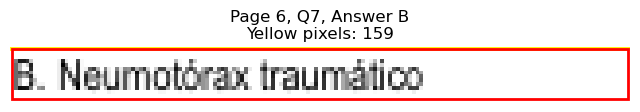

Page 6, Q7 - C: Detected box: x0=315.4, y0=493.4, x1=413.3, y1=506.0
Page 6, Q7, C: Yellow pixels: 0
Page 6, Q7, C: Total non-white pixels: 509
Page 6, Q7, C: Yellow percentage: 0.0%


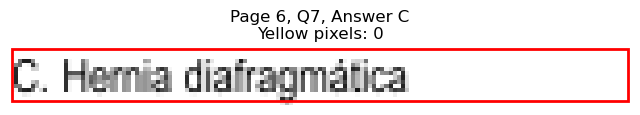

Page 6, Q7 - D: Detected box: x0=315.4, y0=506.0, x1=434.3, y1=518.6
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 622
Page 6, Q7, D: Yellow percentage: 0.0%


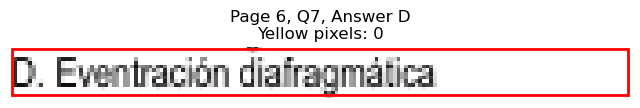


Page 6, Q7 - Selected Answer: A (based on yellow pixel count)
Page 6, Q8 - A: Detected box: x0=56.6, y0=569.1, x1=112.9, y1=581.7
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 249
Page 6, Q8, A: Yellow percentage: 0.0%


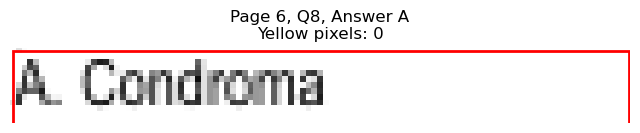

Page 6, Q8 - B: Detected box: x0=56.6, y0=581.7, x1=161.1, y1=594.3
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 528
Page 6, Q8, B: Yellow percentage: 0.0%


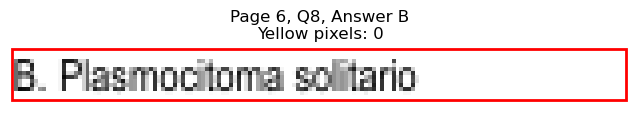

Page 6, Q8 - C: Detected box: x0=315.4, y0=569.1, x1=405.8, y1=581.7
Page 6, Q8, C: Yellow pixels: 1
Page 6, Q8, C: Total non-white pixels: 564
Page 6, Q8, C: Yellow percentage: 0.2%


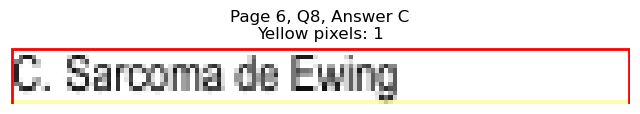

Page 6, Q8 - D: Detected box: x0=315.4, y0=581.7, x1=394.3, y1=594.3
Page 6, Q8, D: Yellow pixels: 1267
Page 6, Q8, D: Total non-white pixels: 1820
Page 6, Q8, D: Yellow percentage: 69.6%


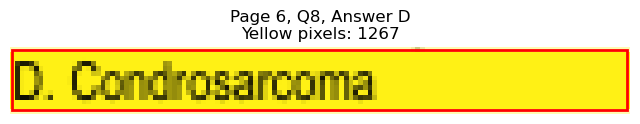


Page 6, Q8 - Selected Answer: D (based on yellow pixel count)
Page 6, Q9 - A: Detected box: x0=56.6, y0=632.2, x1=225.3, y1=644.9
Page 6, Q9, A: Yellow pixels: 0
Page 6, Q9, A: Total non-white pixels: 840
Page 6, Q9, A: Yellow percentage: 0.0%


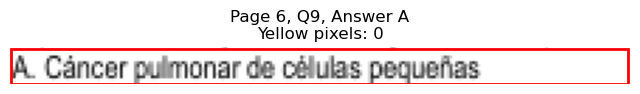

Page 6, Q9 - B: Detected box: x0=56.6, y0=644.8, x1=162.0, y1=657.5
Page 6, Q9, B: Yellow pixels: 0
Page 6, Q9, B: Total non-white pixels: 505
Page 6, Q9, B: Yellow percentage: 0.0%


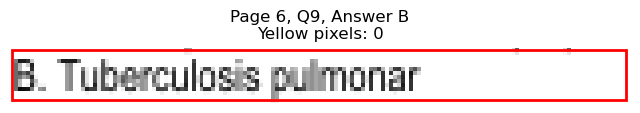

Page 6, Q9 - C: Detected box: x0=315.4, y0=632.2, x1=497.1, y1=644.9
Page 6, Q9, C: Yellow pixels: 2209
Page 6, Q9, C: Total non-white pixels: 2938
Page 6, Q9, C: Yellow percentage: 75.2%


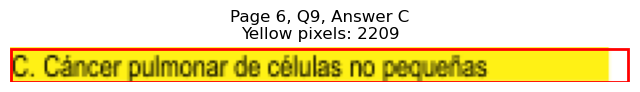

Page 6, Q9 - D: Detected box: x0=315.4, y0=644.8, x1=420.3, y1=657.5
Page 6, Q9, D: Yellow pixels: 0
Page 6, Q9, D: Total non-white pixels: 545
Page 6, Q9, D: Yellow percentage: 0.0%


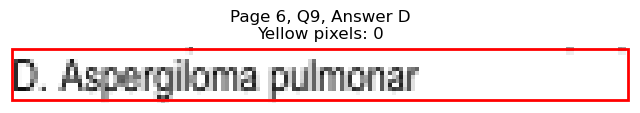


Page 6, Q9 - Selected Answer: C (based on yellow pixel count)
Page 6, Q10 - A: Detected box: x0=56.6, y0=695.4, x1=135.0, y1=708.0
Page 6, Q10, A: Yellow pixels: 0
Page 6, Q10, A: Total non-white pixels: 363
Page 6, Q10, A: Yellow percentage: 0.0%


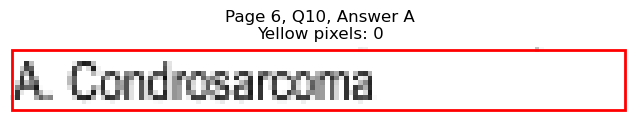

Page 6, Q10 - B: Detected box: x0=56.6, y0=581.7, x1=161.1, y1=594.3
Page 6, Q10, B: Yellow pixels: 0
Page 6, Q10, B: Total non-white pixels: 528
Page 6, Q10, B: Yellow percentage: 0.0%


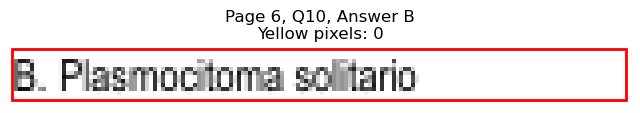

Page 6, Q10 - C: Detected box: x0=315.4, y0=695.4, x1=388.7, y1=708.0
Page 6, Q10, C: Yellow pixels: 124
Page 6, Q10, C: Total non-white pixels: 582
Page 6, Q10, C: Yellow percentage: 21.3%


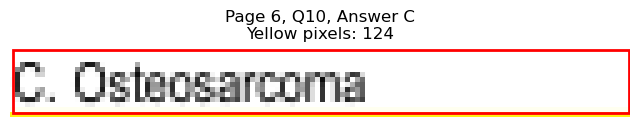

Page 6, Q10 - D: Detected box: x0=315.4, y0=708.0, x1=405.8, y1=720.6
Page 6, Q10, D: Yellow pixels: 1500
Page 6, Q10, D: Total non-white pixels: 1974
Page 6, Q10, D: Yellow percentage: 76.0%


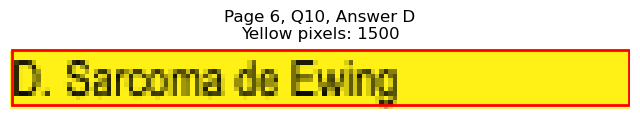


Page 6, Q10 - Selected Answer: D (based on yellow pixel count)
Page 6, Q11 - A: Detected box: x0=56.6, y0=745.8, x1=222.3, y1=758.4
Page 6, Q11, A: Yellow pixels: 0
Page 6, Q11, A: Total non-white pixels: 804
Page 6, Q11, A: Yellow percentage: 0.0%


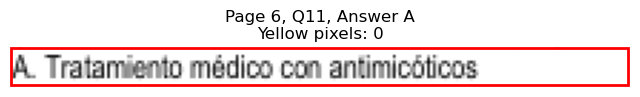

Page 6, Q11 - B: Detected box: x0=56.6, y0=758.5, x1=125.5, y1=771.1
Page 6, Q11, B: Yellow pixels: 0
Page 6, Q11, B: Total non-white pixels: 327
Page 6, Q11, B: Yellow percentage: 0.0%


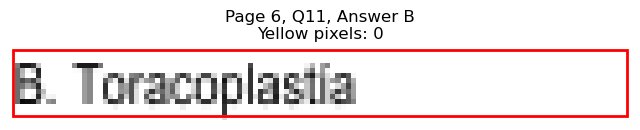

Page 6, Q11 - C: Detected box: x0=315.4, y0=745.8, x1=412.3, y1=758.4
Page 6, Q11, C: Yellow pixels: 1577
Page 6, Q11, C: Total non-white pixels: 2072
Page 6, Q11, C: Yellow percentage: 76.1%


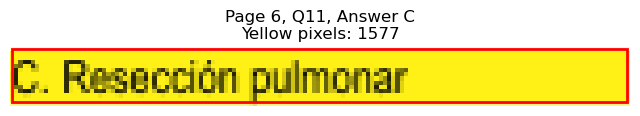

Page 6, Q11 - D: Detected box: x0=315.4, y0=758.5, x1=440.3, y1=771.1
Page 6, Q11, D: Yellow pixels: 176
Page 6, Q11, D: Total non-white pixels: 797
Page 6, Q11, D: Yellow percentage: 22.1%


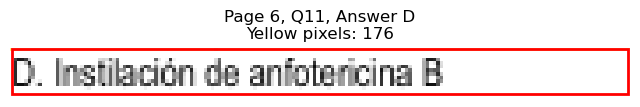


Page 6, Q11 - Selected Answer: C (based on yellow pixel count)

Page 7: Found 11 questions
Page 7, Q1 - A: Detected box: x0=56.6, y0=89.4, x1=205.7, y1=102.1
Page 7, Q1, A: Yellow pixels: 200
Page 7, Q1, A: Total non-white pixels: 950
Page 7, Q1, A: Yellow percentage: 21.1%


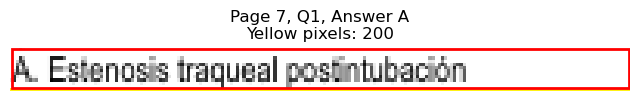

Page 7, Q1 - B: Detected box: x0=56.6, y0=102.0, x1=185.7, y1=114.7
Page 7, Q1, B: Yellow pixels: 1845
Page 7, Q1, B: Total non-white pixels: 2340
Page 7, Q1, B: Yellow percentage: 78.8%


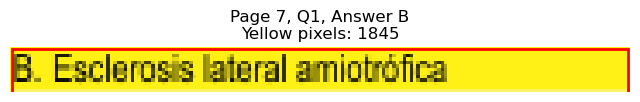

Page 7, Q1 - C: Detected box: x0=315.4, y0=89.4, x1=446.9, y1=102.1
Page 7, Q1, C: Yellow pixels: 0
Page 7, Q1, C: Total non-white pixels: 636
Page 7, Q1, C: Yellow percentage: 0.0%


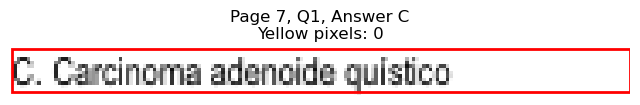

Page 7, Q1 - D: Detected box: x0=315.4, y0=102.0, x1=425.8, y1=114.7
Page 7, Q1, D: Yellow pixels: 0
Page 7, Q1, D: Total non-white pixels: 539
Page 7, Q1, D: Yellow percentage: 0.0%


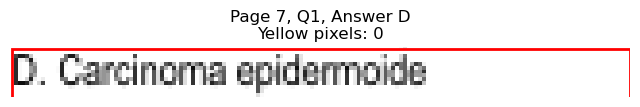


Page 7, Q1 - Selected Answer: B (based on yellow pixel count)
Page 7, Q2 - A: Detected box: x0=56.6, y0=139.9, x1=119.4, y1=152.6
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 344
Page 7, Q2, A: Yellow percentage: 0.0%


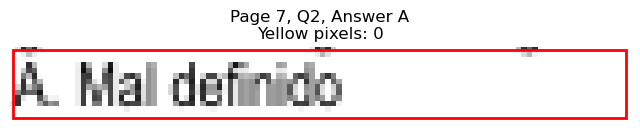

Page 7, Q2 - B: Detected box: x0=56.6, y0=152.5, x1=130.5, y1=165.2
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 370
Page 7, Q2, B: Yellow percentage: 0.0%


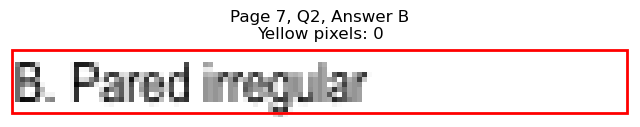

Page 7, Q2 - C: Detected box: x0=315.4, y0=139.9, x1=362.7, y1=152.6
Page 7, Q2, C: Yellow pixels: 98
Page 7, Q2, C: Total non-white pixels: 314
Page 7, Q2, C: Yellow percentage: 31.2%


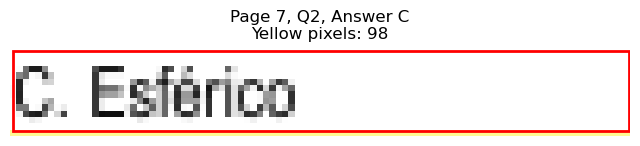

Page 7, Q2 - D: Detected box: x0=315.4, y0=152.5, x1=408.3, y1=165.2
Page 7, Q2, D: Yellow pixels: 1526
Page 7, Q2, D: Total non-white pixels: 2016
Page 7, Q2, D: Yellow percentage: 75.7%


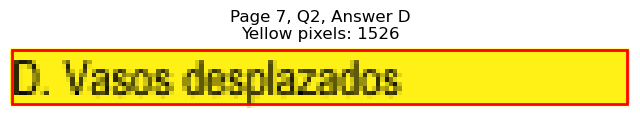


Page 7, Q2 - Selected Answer: D (based on yellow pixel count)
Page 7, Q3 - A: Detected box: x0=56.6, y0=215.6, x1=138.5, y1=228.3
Page 7, Q3, A: Yellow pixels: 133
Page 7, Q3, A: Total non-white pixels: 515
Page 7, Q3, A: Yellow percentage: 25.8%


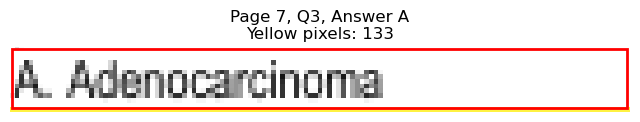

Page 7, Q3 - B: Detected box: x0=56.6, y0=228.2, x1=166.6, y1=240.9
Page 7, Q3, B: Yellow pixels: 1685
Page 7, Q3, B: Total non-white pixels: 2093
Page 7, Q3, B: Yellow percentage: 80.5%


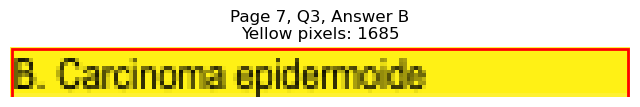

Page 7, Q3 - C: Detected box: x0=315.4, y0=215.6, x1=407.2, y1=228.3
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 452
Page 7, Q3, C: Yellow percentage: 0.0%


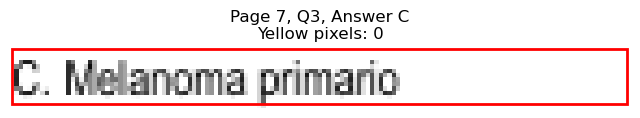

Page 7, Q3 - D: Detected box: x0=315.4, y0=228.2, x1=366.2, y1=240.9
Page 7, Q3, D: Yellow pixels: 0
Page 7, Q3, D: Total non-white pixels: 230
Page 7, Q3, D: Yellow percentage: 0.0%


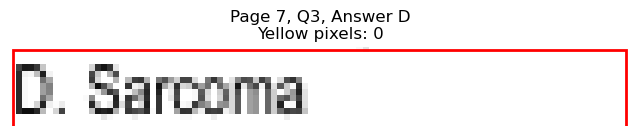


Page 7, Q3 - Selected Answer: B (based on yellow pixel count)
Page 7, Q4 - A: Detected box: x0=56.6, y0=278.8, x1=134.1, y1=291.4
Page 7, Q4, A: Yellow pixels: 129
Page 7, Q4, A: Total non-white pixels: 471
Page 7, Q4, A: Yellow percentage: 27.4%


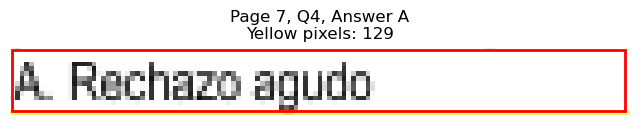

Page 7, Q4 - B: Detected box: x0=56.6, y0=291.4, x1=138.0, y1=304.0
Page 7, Q4, B: Yellow pixels: 1433
Page 7, Q4, B: Total non-white pixels: 1862
Page 7, Q4, B: Yellow percentage: 77.0%


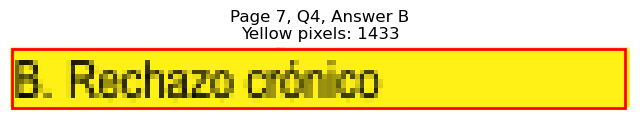

Page 7, Q4 - C: Detected box: x0=315.4, y0=278.8, x1=472.1, y1=291.4
Page 7, Q4, C: Yellow pixels: 0
Page 7, Q4, C: Total non-white pixels: 780
Page 7, Q4, C: Yellow percentage: 0.0%


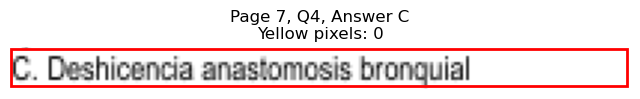

Page 7, Q4 - D: Detected box: x0=315.4, y0=291.4, x1=371.7, y1=304.0
Page 7, Q4, D: Yellow pixels: 0
Page 7, Q4, D: Total non-white pixels: 261
Page 7, Q4, D: Yellow percentage: 0.0%


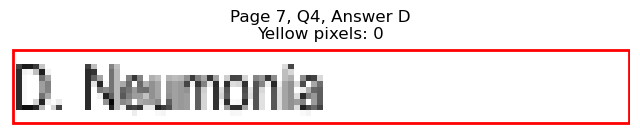


Page 7, Q4 - Selected Answer: B (based on yellow pixel count)
Page 7, Q5 - A: Detected box: x0=56.6, y0=354.5, x1=81.9, y1=367.2
Page 7, Q5, A: Yellow pixels: 76
Page 7, Q5, A: Total non-white pixels: 176
Page 7, Q5, A: Yellow percentage: 43.2%


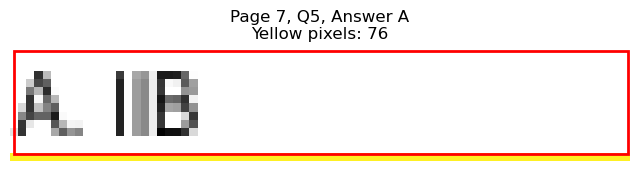

Page 7, Q5 - B: Detected box: x0=56.6, y0=367.1, x1=84.4, y1=379.8
Page 7, Q5, B: Yellow pixels: 932
Page 7, Q5, B: Total non-white pixels: 1027
Page 7, Q5, B: Yellow percentage: 90.7%


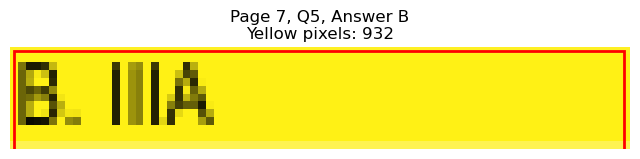

Page 7, Q5 - C: Detected box: x0=315.4, y0=354.5, x1=343.6, y1=367.2
Page 7, Q5, C: Yellow pixels: 0
Page 7, Q5, C: Total non-white pixels: 124
Page 7, Q5, C: Yellow percentage: 0.0%


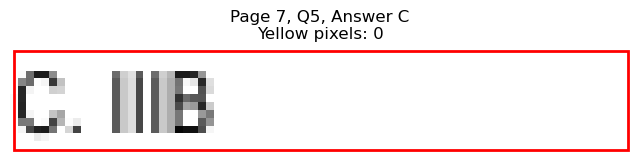

Page 7, Q5 - D: Detected box: x0=315.4, y0=367.1, x1=341.1, y1=379.8
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 103
Page 7, Q5, D: Yellow percentage: 0.0%


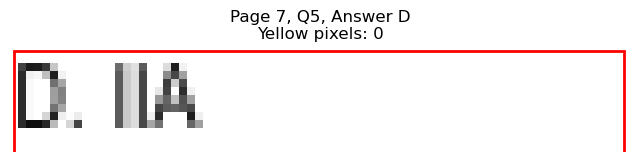


Page 7, Q5 - Selected Answer: B (based on yellow pixel count)
Page 7, Q6 - A: Detected box: x0=56.6, y0=430.2, x1=169.1, y1=442.9
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 507
Page 7, Q6, A: Yellow percentage: 0.0%


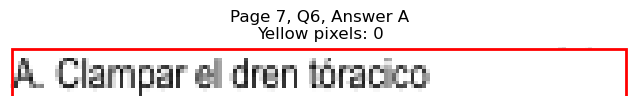

Page 7, Q6 - B: Detected box: x0=56.6, y0=682.6, x1=105.5, y1=695.3
Page 7, Q6, B: Yellow pixels: 100
Page 7, Q6, B: Total non-white pixels: 564
Page 7, Q6, B: Yellow percentage: 17.7%


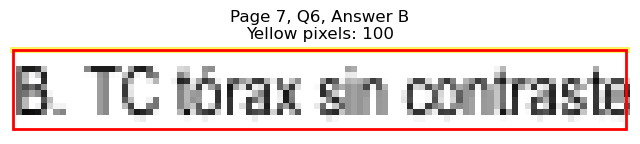

Page 7, Q6 - C: Detected box: x0=315.4, y0=430.2, x1=418.9, y1=442.9
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 648
Page 7, Q6, C: Yellow percentage: 0.0%


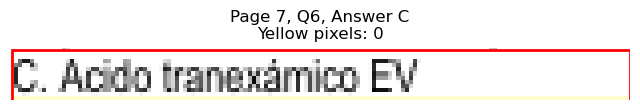

Page 7, Q6 - D: Detected box: x0=315.4, y0=442.8, x1=438.9, y1=455.5
Page 7, Q6, D: Yellow pixels: 1787
Page 7, Q6, D: Total non-white pixels: 2436
Page 7, Q6, D: Yellow percentage: 73.4%


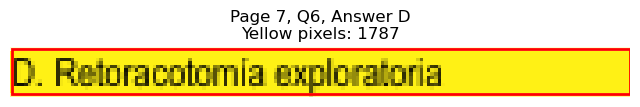


Page 7, Q6 - Selected Answer: D (based on yellow pixel count)
Page 7, Q7 - A: Detected box: x0=56.6, y0=493.4, x1=145.6, y1=506.0
Page 7, Q7, A: Yellow pixels: 1481
Page 7, Q7, A: Total non-white pixels: 1821
Page 7, Q7, A: Yellow percentage: 81.3%


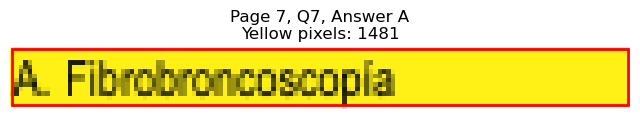

Page 7, Q7 - B: Detected box: x0=56.6, y0=506.0, x1=130.5, y1=518.6
Page 7, Q7, B: Yellow pixels: 124
Page 7, Q7, B: Total non-white pixels: 502
Page 7, Q7, B: Yellow percentage: 24.7%


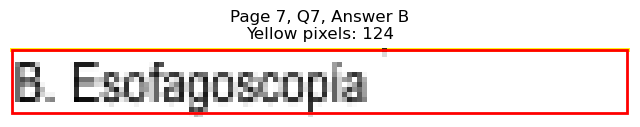

Page 7, Q7 - C: Detected box: x0=315.4, y0=670.0, x1=366.8, y1=682.7
Page 7, Q7, C: Yellow pixels: 0
Page 7, Q7, C: Total non-white pixels: 466
Page 7, Q7, C: Yellow percentage: 0.0%


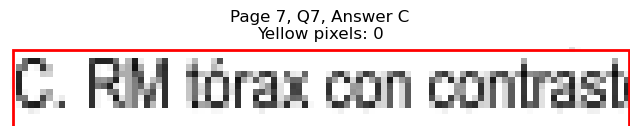

Page 7, Q7 - D: Detected box: x0=315.4, y0=506.0, x1=368.7, y1=518.6
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 260
Page 7, Q7, D: Yellow percentage: 0.0%


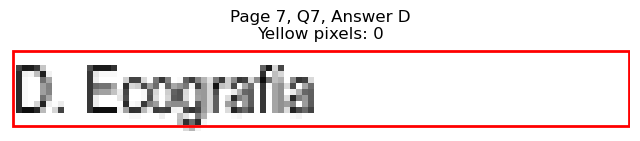


Page 7, Q7 - Selected Answer: A (based on yellow pixel count)
Page 7, Q8 - A: Detected box: x0=56.6, y0=543.8, x1=204.6, y1=556.4
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 705
Page 7, Q8, A: Yellow percentage: 0.0%


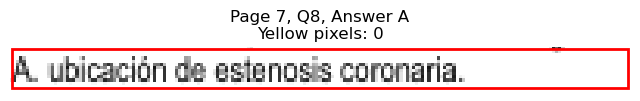

Page 7, Q8 - B: Detected box: x0=56.6, y0=556.5, x1=189.7, y1=569.1
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 643
Page 7, Q8, B: Yellow percentage: 0.0%


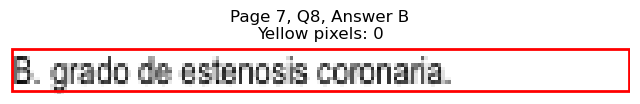

Page 7, Q8 - C: Detected box: x0=315.4, y0=543.8, x1=460.0, y1=556.4
Page 7, Q8, C: Yellow pixels: 2008
Page 7, Q8, C: Total non-white pixels: 2744
Page 7, Q8, C: Yellow percentage: 73.2%


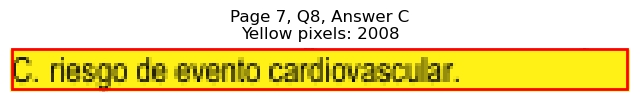

Page 7, Q8 - D: Detected box: x0=315.4, y0=556.5, x1=379.1, y1=569.1
Page 7, Q8, D: Yellow pixels: 114
Page 7, Q8, D: Total non-white pixels: 428
Page 7, Q8, D: Yellow percentage: 26.6%


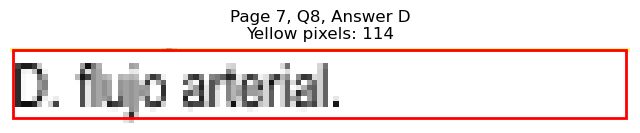


Page 7, Q8 - Selected Answer: C (based on yellow pixel count)
Page 7, Q9 - A: Detected box: x0=56.6, y0=594.3, x1=303.0, y1=606.9
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 1129
Page 7, Q9, A: Yellow percentage: 0.0%


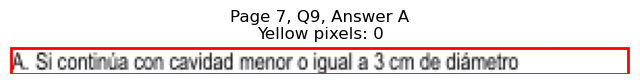

Page 7, Q9 - B: Detected box: x0=56.6, y0=606.9, x1=237.9, y1=619.5
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 853
Page 7, Q9, B: Yellow percentage: 0.0%


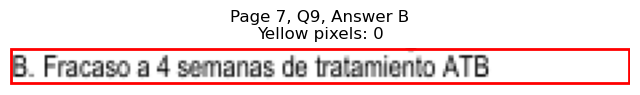

Page 7, Q9 - C: Detected box: x0=56.6, y0=619.6, x1=240.4, y1=632.3
Page 7, Q9, C: Yellow pixels: 2121
Page 7, Q9, C: Total non-white pixels: 3290
Page 7, Q9, C: Yellow percentage: 64.5%


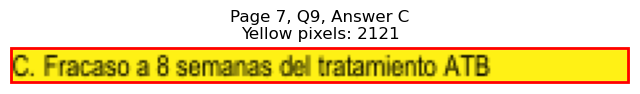

Page 7, Q9 - D: Detected box: x0=56.6, y0=632.2, x1=264.9, y1=644.9
Page 7, Q9, D: Yellow pixels: 0
Page 7, Q9, D: Total non-white pixels: 1260
Page 7, Q9, D: Yellow percentage: 0.0%


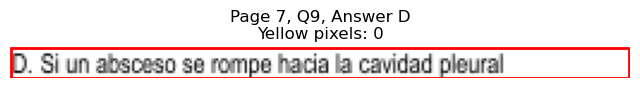


Page 7, Q9 - Selected Answer: C (based on yellow pixel count)
Page 7, Q10 - A: Detected box: x0=56.6, y0=670.0, x1=162.1, y1=682.7
Page 7, Q10, A: Yellow pixels: 1675
Page 7, Q10, A: Total non-white pixels: 2041
Page 7, Q10, A: Yellow percentage: 82.1%


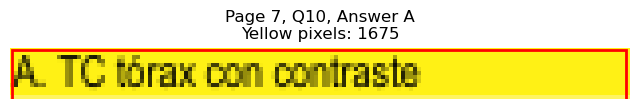

Page 7, Q10 - B: Detected box: x0=56.6, y0=682.6, x1=159.0, y1=695.3
Page 7, Q10, B: Yellow pixels: 154
Page 7, Q10, B: Total non-white pixels: 620
Page 7, Q10, B: Yellow percentage: 24.8%


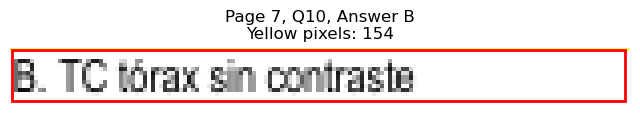

Page 7, Q10 - C: Detected box: x0=315.4, y0=670.0, x1=423.3, y1=682.7
Page 7, Q10, C: Yellow pixels: 0
Page 7, Q10, C: Total non-white pixels: 488
Page 7, Q10, C: Yellow percentage: 0.0%


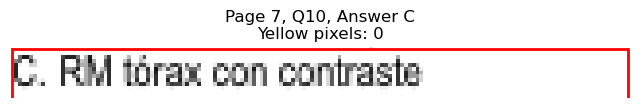

Page 7, Q10 - D: Detected box: x0=315.4, y0=682.6, x1=420.3, y1=695.3
Page 7, Q10, D: Yellow pixels: 0
Page 7, Q10, D: Total non-white pixels: 487
Page 7, Q10, D: Yellow percentage: 0.0%


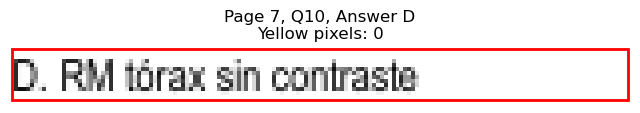


Page 7, Q10 - Selected Answer: A (based on yellow pixel count)
Page 7, Q11 - A: Detected box: x0=56.6, y0=745.8, x1=154.1, y1=758.4
Page 7, Q11, A: Yellow pixels: 0
Page 7, Q11, A: Total non-white pixels: 490
Page 7, Q11, A: Yellow percentage: 0.0%


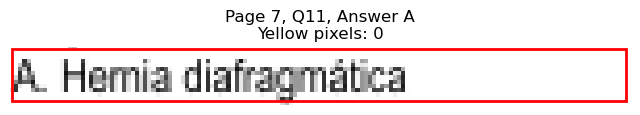

Page 7, Q11 - B: Detected box: x0=56.6, y0=758.5, x1=175.1, y1=771.1
Page 7, Q11, B: Yellow pixels: 1727
Page 7, Q11, B: Total non-white pixels: 2380
Page 7, Q11, B: Yellow percentage: 72.6%


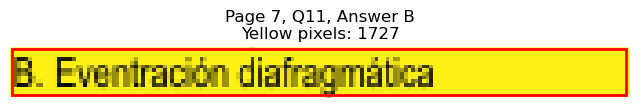

Page 7, Q11 - C: Detected box: x0=315.4, y0=745.8, x1=380.7, y1=758.4
Page 7, Q11, C: Yellow pixels: 0
Page 7, Q11, C: Total non-white pixels: 318
Page 7, Q11, C: Yellow percentage: 0.0%


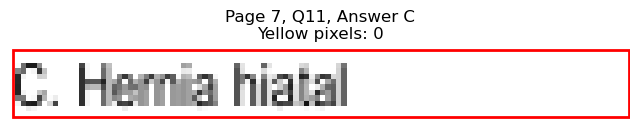

Page 7, Q11 - D: Detected box: x0=315.4, y0=758.5, x1=406.8, y1=771.1
Page 7, Q11, D: Yellow pixels: 0
Page 7, Q11, D: Total non-white pixels: 475
Page 7, Q11, D: Yellow percentage: 0.0%


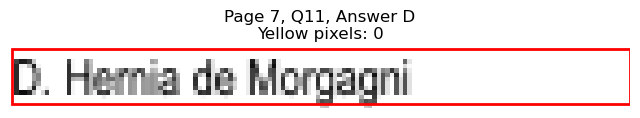


Page 7, Q11 - Selected Answer: B (based on yellow pixel count)

Page 8: Found 11 questions
Page 8, Q1 - A: Detected box: x0=56.6, y0=114.6, x1=152.5, y1=127.3
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 487
Page 8, Q1, A: Yellow percentage: 0.0%


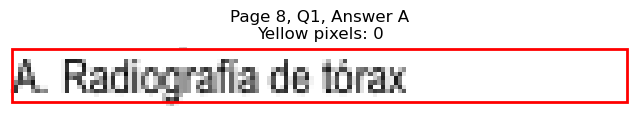

Page 8, Q1 - B: Detected box: x0=56.6, y0=127.2, x1=117.0, y1=139.9
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 276
Page 8, Q1, B: Yellow percentage: 0.0%


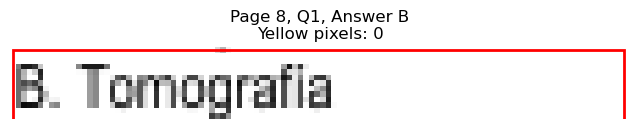

Page 8, Q1 - C: Detected box: x0=315.4, y0=114.6, x1=402.8, y1=127.3
Page 8, Q1, C: Yellow pixels: 138
Page 8, Q1, C: Total non-white pixels: 567
Page 8, Q1, C: Yellow percentage: 24.3%


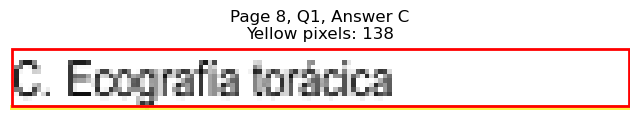

Page 8, Q1 - D: Detected box: x0=315.4, y0=127.2, x1=434.5, y1=139.9
Page 8, Q1, D: Yellow pixels: 1765
Page 8, Q1, D: Total non-white pixels: 2210
Page 8, Q1, D: Yellow percentage: 79.9%


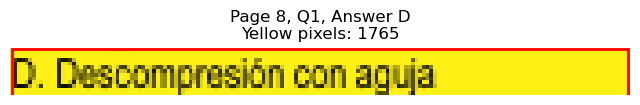


Page 8, Q1 - Selected Answer: D (based on yellow pixel count)
Page 8, Q2 - A: Detected box: x0=56.6, y0=177.7, x1=137.2, y1=190.4
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 389
Page 8, Q2, A: Yellow percentage: 0.0%


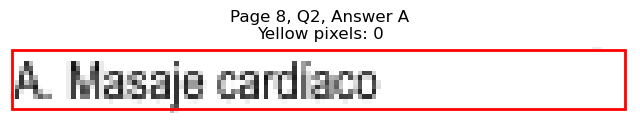

Page 8, Q2 - B: Detected box: x0=56.6, y0=190.3, x1=144.5, y1=203.0
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 447
Page 8, Q2, B: Yellow percentage: 0.0%


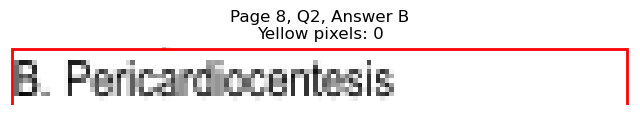

Page 8, Q2 - C: Detected box: x0=315.4, y0=177.7, x1=458.5, y1=190.4
Page 8, Q2, C: Yellow pixels: 194
Page 8, Q2, C: Total non-white pixels: 918
Page 8, Q2, C: Yellow percentage: 21.1%


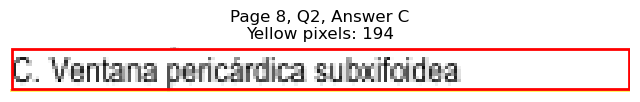

Page 8, Q2 - D: Detected box: x0=315.4, y0=190.3, x1=445.0, y1=203.0
Page 8, Q2, D: Yellow pixels: 1874
Page 8, Q2, D: Total non-white pixels: 2353
Page 8, Q2, D: Yellow percentage: 79.6%


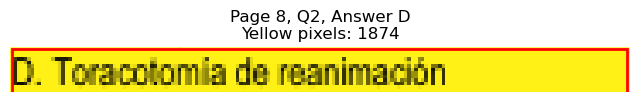


Page 8, Q2 - Selected Answer: D (based on yellow pixel count)
Page 8, Q3 - A: Detected box: x0=56.6, y0=240.8, x1=163.6, y1=253.5
Page 8, Q3, A: Yellow pixels: 1655
Page 8, Q3, A: Total non-white pixels: 2212
Page 8, Q3, A: Yellow percentage: 74.8%


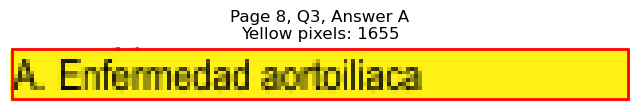

Page 8, Q3 - B: Detected box: x0=56.6, y0=253.4, x1=182.7, y1=266.1
Page 8, Q3, B: Yellow pixels: 177
Page 8, Q3, B: Total non-white pixels: 812
Page 8, Q3, B: Yellow percentage: 21.8%


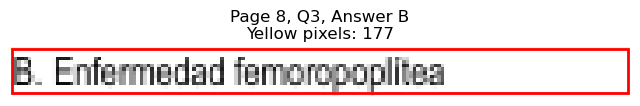

Page 8, Q3 - C: Detected box: x0=315.4, y0=240.8, x1=382.3, y1=253.5
Page 8, Q3, C: Yellow pixels: 0
Page 8, Q3, C: Total non-white pixels: 333
Page 8, Q3, C: Yellow percentage: 0.0%


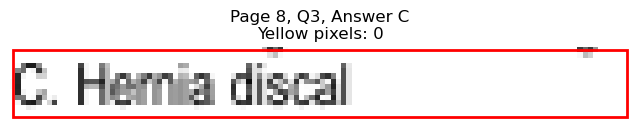

Page 8, Q3 - D: Detected box: x0=315.4, y0=253.4, x1=403.7, y1=266.1
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 407
Page 8, Q3, D: Yellow percentage: 0.0%


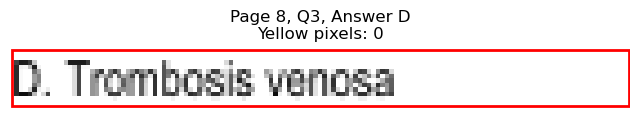


Page 8, Q3 - Selected Answer: A (based on yellow pixel count)
Page 8, Q4 - A: Detected box: x0=56.6, y0=291.4, x1=138.5, y1=304.0
Page 8, Q4, A: Yellow pixels: 1427
Page 8, Q4, A: Total non-white pixels: 1862
Page 8, Q4, A: Yellow percentage: 76.6%


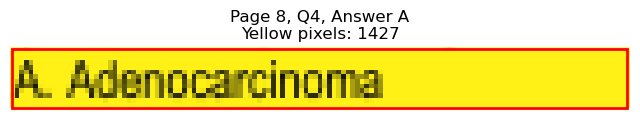

Page 8, Q4 - B: Detected box: x0=56.6, y0=304.0, x1=199.7, y1=316.6
Page 8, Q4, B: Yellow pixels: 194
Page 8, Q4, B: Total non-white pixels: 1063
Page 8, Q4, B: Yellow percentage: 18.3%


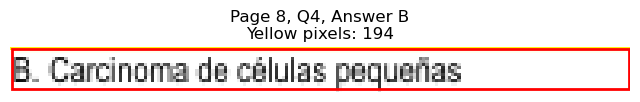

Page 8, Q4 - C: Detected box: x0=315.4, y0=291.4, x1=425.8, y1=304.0
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 533
Page 8, Q4, C: Yellow percentage: 0.0%


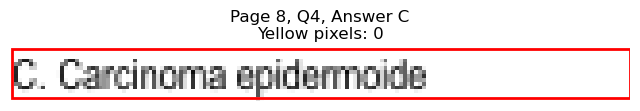

Page 8, Q4 - D: Detected box: x0=315.4, y0=304.0, x1=517.1, y1=316.6
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 1001
Page 8, Q4, D: Yellow percentage: 0.0%


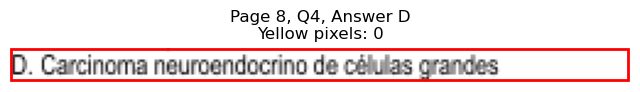


Page 8, Q4 - Selected Answer: A (based on yellow pixel count)
Page 8, Q5 - A: Detected box: x0=56.6, y0=341.9, x1=173.7, y1=354.6
Page 8, Q5, A: Yellow pixels: 168
Page 8, Q5, A: Total non-white pixels: 732
Page 8, Q5, A: Yellow percentage: 23.0%


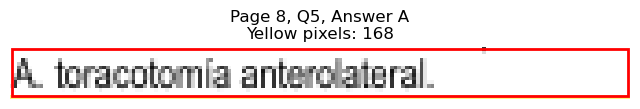

Page 8, Q5 - B: Detected box: x0=56.6, y0=354.5, x1=153.0, y1=367.2
Page 8, Q5, B: Yellow pixels: 1549
Page 8, Q5, B: Total non-white pixels: 2072
Page 8, Q5, B: Yellow percentage: 74.8%


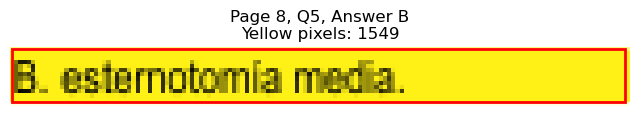

Page 8, Q5 - C: Detected box: x0=315.4, y0=341.9, x1=437.3, y1=354.6
Page 8, Q5, C: Yellow pixels: 0
Page 8, Q5, C: Total non-white pixels: 602
Page 8, Q5, C: Yellow percentage: 0.0%


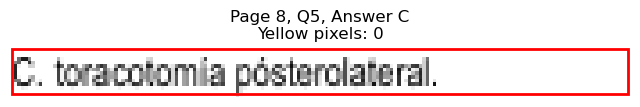

Page 8, Q5 - D: Detected box: x0=315.4, y0=354.5, x1=404.2, y1=367.2
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 426
Page 8, Q5, D: Yellow percentage: 0.0%


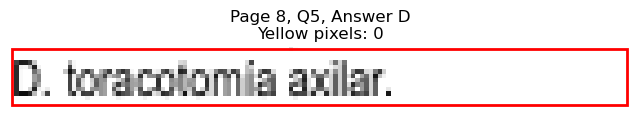


Page 8, Q5 - Selected Answer: B (based on yellow pixel count)
Page 8, Q6 - A: Detected box: x0=56.6, y0=404.9, x1=145.6, y1=417.6
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 421
Page 8, Q6, A: Yellow percentage: 0.0%


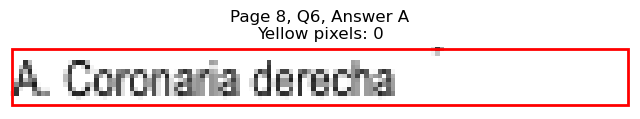

Page 8, Q6 - B: Detected box: x0=56.6, y0=417.6, x1=113.4, y1=430.3
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 270
Page 8, Q6, B: Yellow percentage: 0.0%


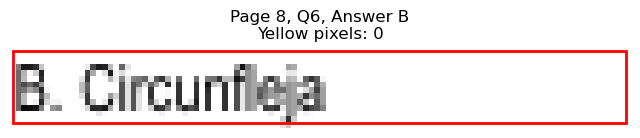

Page 8, Q6 - C: Detected box: x0=315.4, y0=404.9, x1=427.4, y1=417.6
Page 8, Q6, C: Yellow pixels: 0
Page 8, Q6, C: Total non-white pixels: 551
Page 8, Q6, C: Yellow percentage: 0.0%


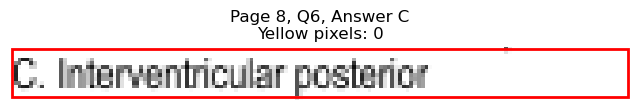

Page 8, Q6 - D: Detected box: x0=315.4, y0=417.6, x1=416.3, y1=430.3
Page 8, Q6, D: Yellow pixels: 1442
Page 8, Q6, D: Total non-white pixels: 2128
Page 8, Q6, D: Yellow percentage: 67.8%


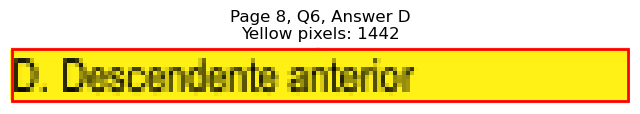


Page 8, Q6 - Selected Answer: D (based on yellow pixel count)
Page 8, Q7 - A: Detected box: x0=56.6, y0=455.5, x1=112.5, y1=468.1
Page 8, Q7, A: Yellow pixels: 107
Page 8, Q7, A: Total non-white pixels: 368
Page 8, Q7, A: Yellow percentage: 29.1%


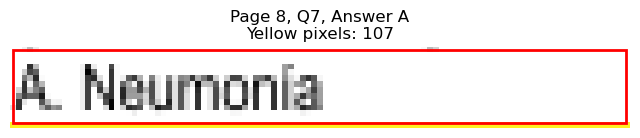

Page 8, Q7 - B: Detected box: x0=56.6, y0=468.1, x1=140.1, y1=480.7
Page 8, Q7, B: Yellow pixels: 1452
Page 8, Q7, B: Total non-white pixels: 1755
Page 8, Q7, B: Yellow percentage: 82.7%


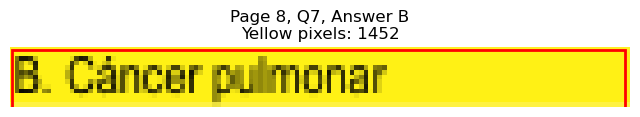

Page 8, Q7 - C: Detected box: x0=315.4, y0=455.5, x1=408.8, y1=468.1
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 459
Page 8, Q7, C: Yellow percentage: 0.0%


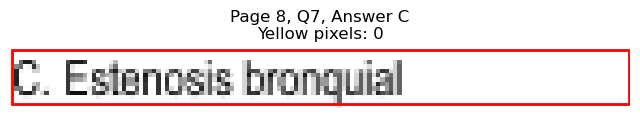

Page 8, Q7 - D: Detected box: x0=315.4, y0=468.1, x1=447.4, y1=480.7
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 641
Page 8, Q7, D: Yellow percentage: 0.0%


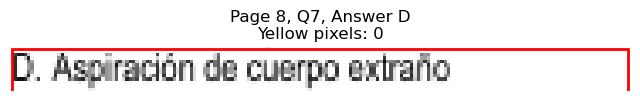


Page 8, Q7 - Selected Answer: B (based on yellow pixel count)
Page 8, Q8 - A: Detected box: x0=56.6, y0=518.6, x1=137.1, y1=531.2
Page 8, Q8, A: Yellow pixels: 1414
Page 8, Q8, A: Total non-white pixels: 1848
Page 8, Q8, A: Yellow percentage: 76.5%


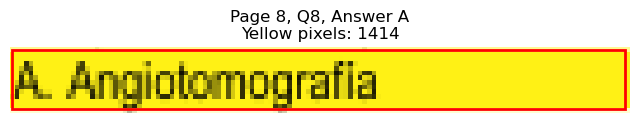

Page 8, Q8 - B: Detected box: x0=56.6, y0=531.2, x1=162.6, y1=543.8
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 675
Page 8, Q8, B: Yellow percentage: 0.0%


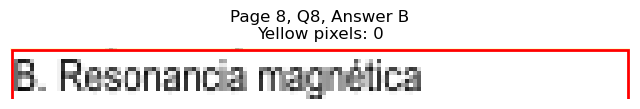

Page 8, Q8 - C: Detected box: x0=315.4, y0=518.6, x1=403.7, y1=531.2
Page 8, Q8, C: Yellow pixels: 0
Page 8, Q8, C: Total non-white pixels: 417
Page 8, Q8, C: Yellow percentage: 0.0%


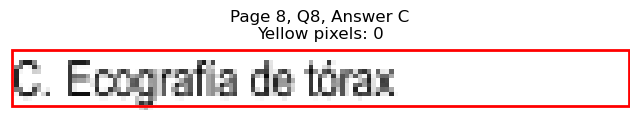

Page 8, Q8 - D: Detected box: x0=315.4, y0=531.2, x1=374.7, y1=543.8
Page 8, Q8, D: Yellow pixels: 0
Page 8, Q8, D: Total non-white pixels: 289
Page 8, Q8, D: Yellow percentage: 0.0%


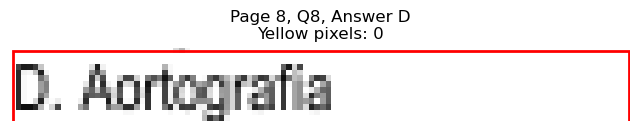


Page 8, Q8 - Selected Answer: A (based on yellow pixel count)
Page 8, Q9 - A: Detected box: x0=56.6, y0=581.7, x1=149.1, y1=594.3
Page 8, Q9, A: Yellow pixels: 0
Page 8, Q9, A: Total non-white pixels: 476
Page 8, Q9, A: Yellow percentage: 0.0%


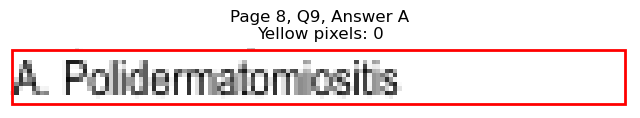

Page 8, Q9 - B: Detected box: x0=56.6, y0=594.3, x1=129.0, y1=606.9
Page 8, Q9, B: Yellow pixels: 0
Page 8, Q9, B: Total non-white pixels: 354
Page 8, Q9, B: Yellow percentage: 0.0%


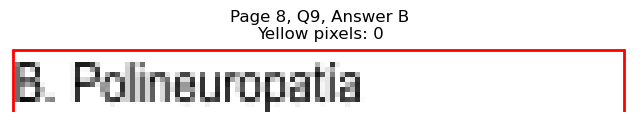

Page 8, Q9 - C: Detected box: x0=315.4, y0=581.7, x1=438.9, y1=594.3
Page 8, Q9, C: Yellow pixels: 174
Page 8, Q9, C: Total non-white pixels: 786
Page 8, Q9, C: Yellow percentage: 22.1%


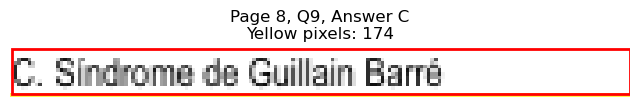

Page 8, Q9 - D: Detected box: x0=315.4, y0=594.3, x1=395.2, y1=606.9
Page 8, Q9, D: Yellow pixels: 1385
Page 8, Q9, D: Total non-white pixels: 1703
Page 8, Q9, D: Yellow percentage: 81.3%


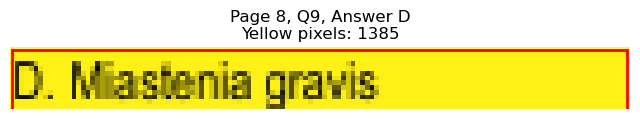


Page 8, Q9 - Selected Answer: D (based on yellow pixel count)
Page 8, Q10 - A: Detected box: x0=56.6, y0=644.8, x1=130.5, y1=657.5
Page 8, Q10, A: Yellow pixels: 0
Page 8, Q10, A: Total non-white pixels: 371
Page 8, Q10, A: Yellow percentage: 0.0%


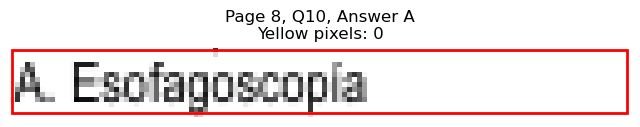

Page 8, Q10 - B: Detected box: x0=56.6, y0=657.4, x1=107.4, y1=670.1
Page 8, Q10, B: Yellow pixels: 0
Page 8, Q10, B: Total non-white pixels: 237
Page 8, Q10, B: Yellow percentage: 0.0%


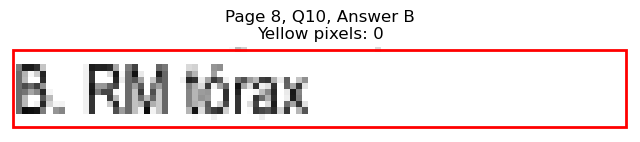

Page 8, Q10 - C: Detected box: x0=315.4, y0=644.8, x1=404.8, y1=657.5
Page 8, Q10, C: Yellow pixels: 1474
Page 8, Q10, C: Total non-white pixels: 1960
Page 8, Q10, C: Yellow percentage: 75.2%


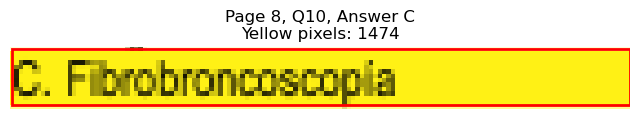

Page 8, Q10 - D: Detected box: x0=315.4, y0=720.6, x1=368.8, y1=733.2
Page 8, Q10, D: Yellow pixels: 104
Page 8, Q10, D: Total non-white pixels: 540
Page 8, Q10, D: Yellow percentage: 19.3%


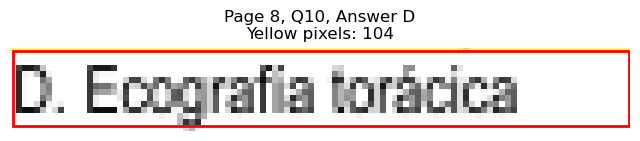


Page 8, Q10 - Selected Answer: C (based on yellow pixel count)
Page 8, Q11 - A: Detected box: x0=56.6, y0=708.0, x1=105.4, y1=720.6
Page 8, Q11, A: Yellow pixels: 0
Page 8, Q11, A: Total non-white pixels: 195
Page 8, Q11, A: Yellow percentage: 0.0%


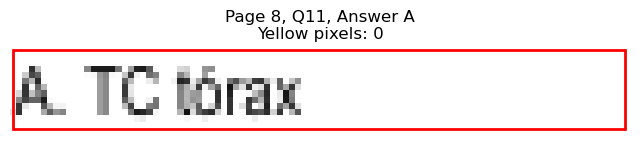

Page 8, Q11 - B: Detected box: x0=56.6, y0=720.6, x1=116.9, y1=733.2
Page 8, Q11, B: Yellow pixels: 0
Page 8, Q11, B: Total non-white pixels: 270
Page 8, Q11, B: Yellow percentage: 0.0%


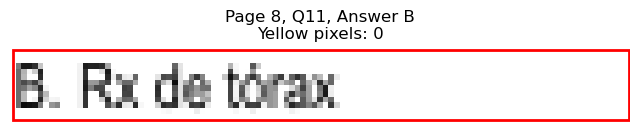

Page 8, Q11 - C: Detected box: x0=315.4, y0=708.0, x1=430.4, y1=720.6
Page 8, Q11, C: Yellow pixels: 1723
Page 8, Q11, C: Total non-white pixels: 2324
Page 8, Q11, C: Yellow percentage: 74.1%


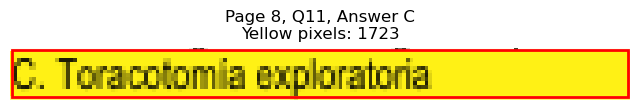

Page 8, Q11 - D: Detected box: x0=315.4, y0=720.6, x1=402.8, y1=733.2
Page 8, Q11, D: Yellow pixels: 138
Page 8, Q11, D: Total non-white pixels: 574
Page 8, Q11, D: Yellow percentage: 24.0%


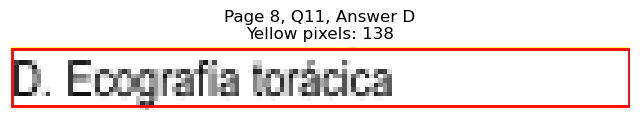


Page 8, Q11 - Selected Answer: C (based on yellow pixel count)

Page 9: Found 10 questions
Page 9, Q1 - A: Detected box: x0=56.6, y0=102.0, x1=115.0, y1=114.7
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 381
Page 9, Q1, A: Yellow percentage: 0.0%


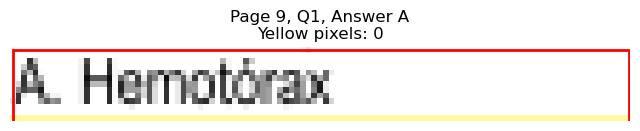

Page 9, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=164.5, y1=127.3
Page 9, Q1, B: Yellow pixels: 1506
Page 9, Q1, B: Total non-white pixels: 2226
Page 9, Q1, B: Yellow percentage: 67.7%


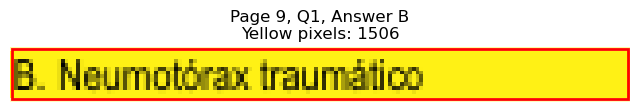

Page 9, Q1 - C: Detected box: x0=315.4, y0=102.0, x1=418.3, y1=114.7
Page 9, Q1, C: Yellow pixels: 0
Page 9, Q1, C: Total non-white pixels: 499
Page 9, Q1, C: Yellow percentage: 0.0%


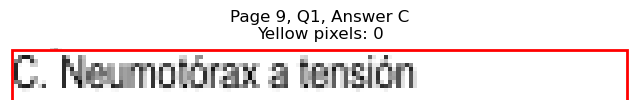

Page 9, Q1 - D: Detected box: x0=315.4, y0=114.6, x1=401.7, y1=127.3
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 396
Page 9, Q1, D: Yellow percentage: 0.0%


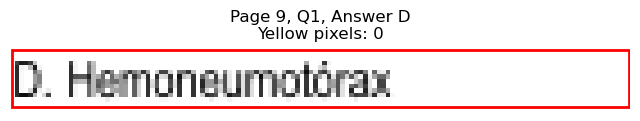


Page 9, Q1 - Selected Answer: B (based on yellow pixel count)
Page 9, Q2 - A: Detected box: x0=56.6, y0=165.1, x1=188.2, y1=177.8
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 675
Page 9, Q2, A: Yellow percentage: 0.0%


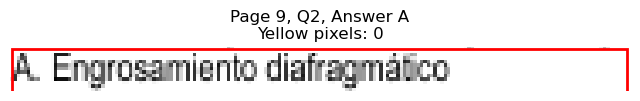

Page 9, Q2 - B: Detected box: x0=56.6, y0=114.6, x1=120.0, y1=127.3
Page 9, Q2, B: Yellow pixels: 978
Page 9, Q2, B: Total non-white pixels: 1610
Page 9, Q2, B: Yellow percentage: 60.7%


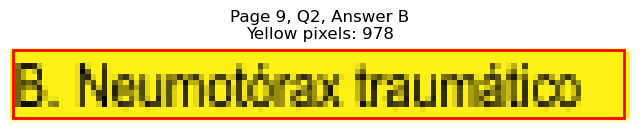

Page 9, Q2 - C: Detected box: x0=315.4, y0=165.1, x1=446.9, y1=177.8
Page 9, Q2, C: Yellow pixels: 1866
Page 9, Q2, C: Total non-white pixels: 2366
Page 9, Q2, C: Yellow percentage: 78.9%


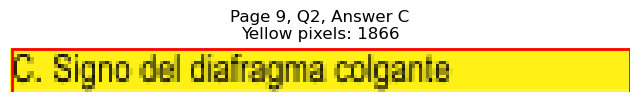

Page 9, Q2 - D: Detected box: x0=315.4, y0=177.7, x1=413.3, y1=190.4
Page 9, Q2, D: Yellow pixels: 144
Page 9, Q2, D: Total non-white pixels: 662
Page 9, Q2, D: Yellow percentage: 21.8%


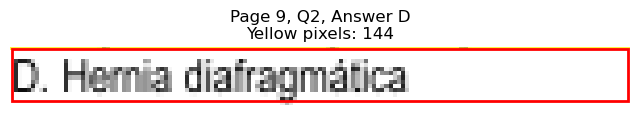


Page 9, Q2 - Selected Answer: C (based on yellow pixel count)
Page 9, Q3 - A: Detected box: x0=56.6, y0=215.6, x1=147.0, y1=228.3
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 441
Page 9, Q3, A: Yellow percentage: 0.0%


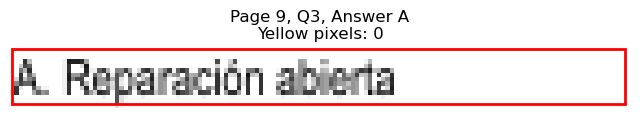

Page 9, Q3 - B: Detected box: x0=56.6, y0=228.2, x1=199.7, y1=240.9
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 701
Page 9, Q3, B: Yellow percentage: 0.0%


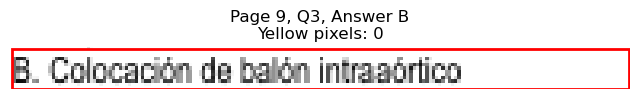

Page 9, Q3 - C: Detected box: x0=315.4, y0=215.6, x1=432.4, y1=228.3
Page 9, Q3, C: Yellow pixels: 1570
Page 9, Q3, C: Total non-white pixels: 2352
Page 9, Q3, C: Yellow percentage: 66.8%


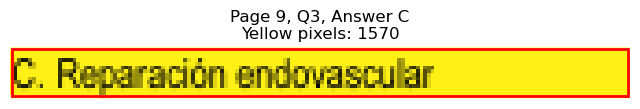

Page 9, Q3 - D: Detected box: x0=315.4, y0=228.2, x1=462.4, y1=240.9
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 887
Page 9, Q3, D: Yellow percentage: 0.0%


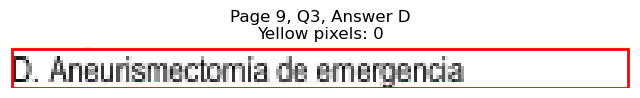


Page 9, Q3 - Selected Answer: C (based on yellow pixel count)
Page 9, Q4 - A: Detected box: x0=56.6, y0=278.8, x1=164.1, y1=291.4
Page 9, Q4, A: Yellow pixels: 1662
Page 9, Q4, A: Total non-white pixels: 2226
Page 9, Q4, A: Yellow percentage: 74.7%


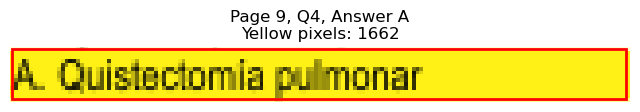

Page 9, Q4 - B: Detected box: x0=56.6, y0=291.4, x1=160.6, y1=304.0
Page 9, Q4, B: Yellow pixels: 155
Page 9, Q4, B: Total non-white pixels: 688
Page 9, Q4, B: Yellow percentage: 22.5%


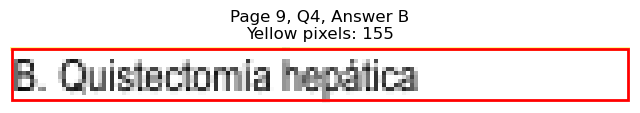

Page 9, Q4 - C: Detected box: x0=315.4, y0=278.8, x1=417.3, y1=291.4
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 467
Page 9, Q4, C: Yellow percentage: 0.0%


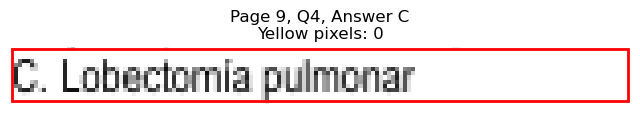

Page 9, Q4 - D: Detected box: x0=315.4, y0=291.4, x1=412.3, y1=304.0
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 475
Page 9, Q4, D: Yellow percentage: 0.0%


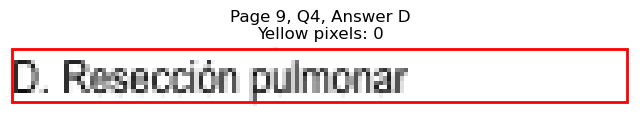


Page 9, Q4 - Selected Answer: A (based on yellow pixel count)
Page 9, Q5 - A: Detected box: x0=56.6, y0=341.9, x1=182.7, y1=354.6
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 602
Page 9, Q5, A: Yellow percentage: 0.0%


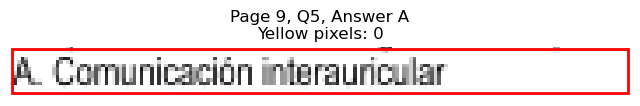

Page 9, Q5 - B: Detected box: x0=56.6, y0=354.5, x1=148.6, y1=367.2
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 432
Page 9, Q5, B: Yellow percentage: 0.0%


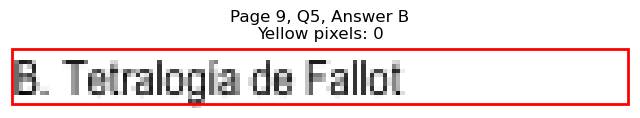

Page 9, Q5 - C: Detected box: x0=315.4, y0=341.9, x1=451.4, y1=354.6
Page 9, Q5, C: Yellow pixels: 1888
Page 9, Q5, C: Total non-white pixels: 2618
Page 9, Q5, C: Yellow percentage: 72.1%


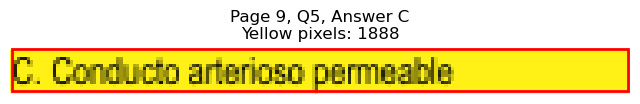

Page 9, Q5 - D: Detected box: x0=315.4, y0=354.5, x1=409.3, y1=367.2
Page 9, Q5, D: Yellow pixels: 145
Page 9, Q5, D: Total non-white pixels: 584
Page 9, Q5, D: Yellow percentage: 24.8%


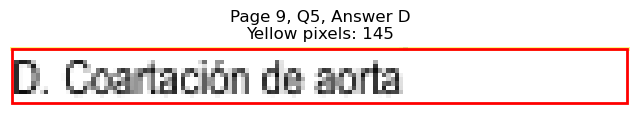


Page 9, Q5 - Selected Answer: C (based on yellow pixel count)
Page 9, Q6 - A: Detected box: x0=56.6, y0=404.9, x1=129.5, y1=417.6
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 352
Page 9, Q6, A: Yellow percentage: 0.0%


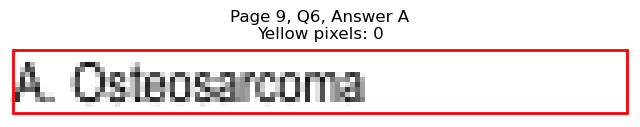

Page 9, Q6 - B: Detected box: x0=56.6, y0=417.6, x1=135.0, y1=430.3
Page 9, Q6, B: Yellow pixels: 1253
Page 9, Q6, B: Total non-white pixels: 1820
Page 9, Q6, B: Yellow percentage: 68.8%


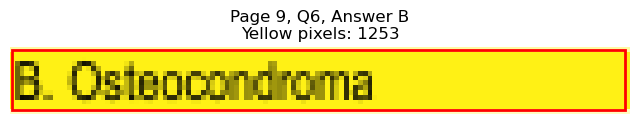

Page 9, Q6 - C: Detected box: x0=315.4, y0=404.9, x1=436.9, y1=417.6
Page 9, Q6, C: Yellow pixels: 0
Page 9, Q6, C: Total non-white pixels: 591
Page 9, Q6, C: Yellow percentage: 0.0%


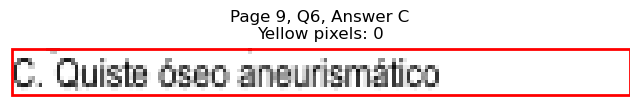

Page 9, Q6 - D: Detected box: x0=315.4, y0=417.6, x1=415.3, y1=430.3
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 477
Page 9, Q6, D: Yellow percentage: 0.0%


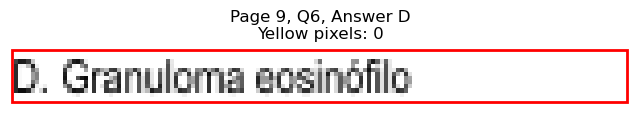


Page 9, Q6 - Selected Answer: B (based on yellow pixel count)
Page 9, Q7 - A: Detected box: x0=56.6, y0=480.8, x1=148.1, y1=493.4
Page 9, Q7, A: Yellow pixels: 1348
Page 9, Q7, A: Total non-white pixels: 2002
Page 9, Q7, A: Yellow percentage: 67.3%


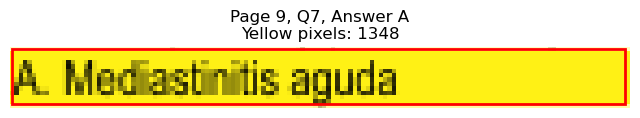

Page 9, Q7 - B: Detected box: x0=56.6, y0=493.4, x1=153.6, y1=506.0
Page 9, Q7, B: Yellow pixels: 1
Page 9, Q7, B: Total non-white pixels: 646
Page 9, Q7, B: Yellow percentage: 0.2%


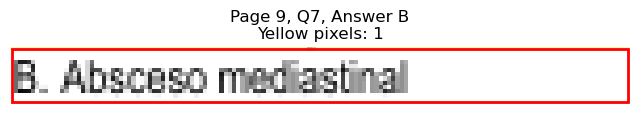

Page 9, Q7 - C: Detected box: x0=315.4, y0=480.8, x1=402.8, y1=493.4
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 435
Page 9, Q7, C: Yellow percentage: 0.0%


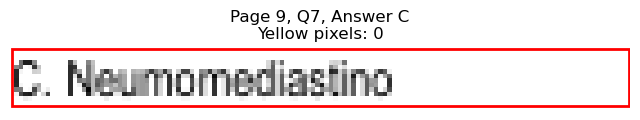

Page 9, Q7 - D: Detected box: x0=315.4, y0=493.4, x1=397.7, y1=506.0
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 412
Page 9, Q7, D: Yellow percentage: 0.0%


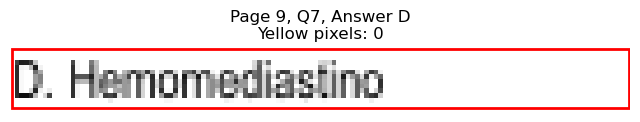


Page 9, Q7 - Selected Answer: A (based on yellow pixel count)
Page 9, Q8 - A: Detected box: x0=56.6, y0=543.8, x1=144.6, y1=556.4
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 454
Page 9, Q8, A: Yellow percentage: 0.0%


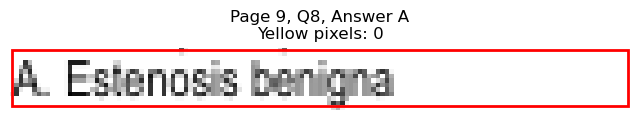

Page 9, Q8 - B: Detected box: x0=56.6, y0=556.5, x1=145.1, y1=569.1
Page 9, Q8, B: Yellow pixels: 1480
Page 9, Q8, B: Total non-white pixels: 1960
Page 9, Q8, B: Yellow percentage: 75.5%


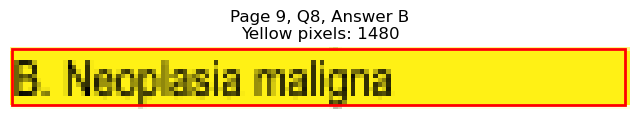

Page 9, Q8 - C: Detected box: x0=315.4, y0=543.8, x1=377.2, y1=556.4
Page 9, Q8, C: Yellow pixels: 0
Page 9, Q8, C: Total non-white pixels: 288
Page 9, Q8, C: Yellow percentage: 0.0%


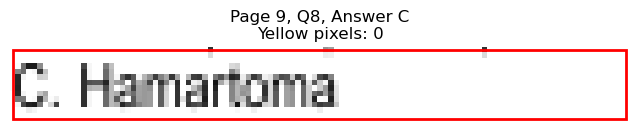

Page 9, Q8 - D: Detected box: x0=315.4, y0=556.5, x1=383.7, y1=569.1
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 316
Page 9, Q8, D: Yellow percentage: 0.0%


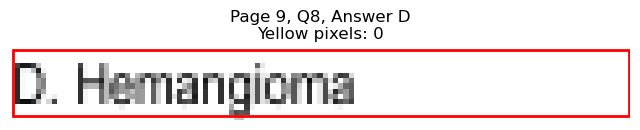


Page 9, Q8 - Selected Answer: B (based on yellow pixel count)
Page 9, Q9 - A: Detected box: x0=56.6, y0=594.3, x1=119.9, y1=606.9
Page 9, Q9, A: Yellow pixels: 0
Page 9, Q9, A: Total non-white pixels: 425
Page 9, Q9, A: Yellow percentage: 0.0%


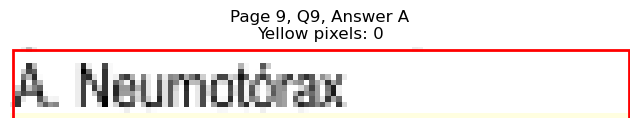

Page 9, Q9 - B: Detected box: x0=56.6, y0=606.9, x1=165.1, y1=619.5
Page 9, Q9, B: Yellow pixels: 1677
Page 9, Q9, B: Total non-white pixels: 2240
Page 9, Q9, B: Yellow percentage: 74.9%


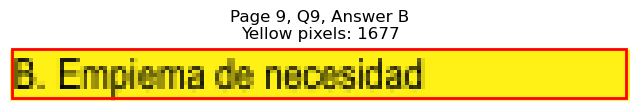

Page 9, Q9 - C: Detected box: x0=315.4, y0=594.3, x1=371.2, y1=606.9
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 259
Page 9, Q9, C: Yellow percentage: 0.0%


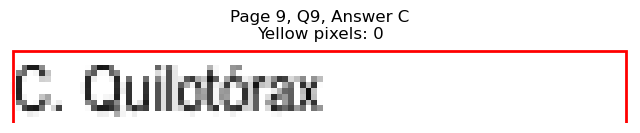

Page 9, Q9 - D: Detected box: x0=315.4, y0=606.9, x1=374.2, y1=619.5
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 273
Page 9, Q9, D: Yellow percentage: 0.0%


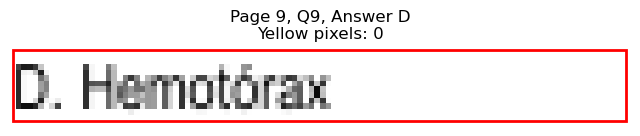


Page 9, Q9 - Selected Answer: B (based on yellow pixel count)
Page 9, Q10 - A: Detected box: x0=56.6, y0=657.4, x1=164.1, y1=670.1
Page 9, Q10, A: Yellow pixels: 1662
Page 9, Q10, A: Total non-white pixels: 2226
Page 9, Q10, A: Yellow percentage: 74.7%


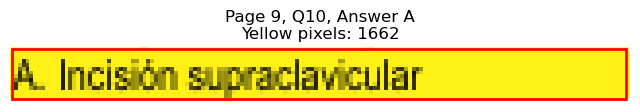

Page 9, Q10 - B: Detected box: x0=56.6, y0=670.0, x1=174.1, y1=682.7
Page 9, Q10, B: Yellow pixels: 0
Page 9, Q10, B: Total non-white pixels: 748
Page 9, Q10, B: Yellow percentage: 0.0%


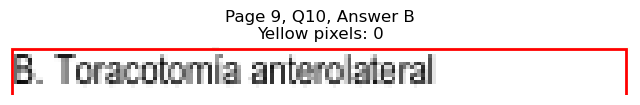

Page 9, Q10 - C: Detected box: x0=315.4, y0=657.4, x1=437.8, y1=670.1
Page 9, Q10, C: Yellow pixels: 0
Page 9, Q10, C: Total non-white pixels: 603
Page 9, Q10, C: Yellow percentage: 0.0%


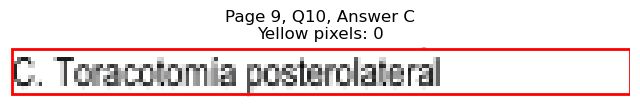

Page 9, Q10 - D: Detected box: x0=315.4, y0=670.0, x1=410.8, y1=682.7
Page 9, Q10, D: Yellow pixels: 0
Page 9, Q10, D: Total non-white pixels: 470
Page 9, Q10, D: Yellow percentage: 0.0%


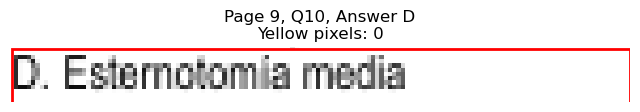


Page 9, Q10 - Selected Answer: A (based on yellow pixel count)


In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   ¿Cuál es la causa más frecuente de tratamiento...
1   Varón de 53 años, con traumatismo torácico cer...
2   ¿Cuál es el abordaje para el control proximal ...
3   Mujer de 65 años con antecedentes de tabaquism...
4   Mujer de 58 años. Antecedente: hace dos años t...
..                                                ...
95  Mujer 38 años con masa en región anterolateral...
96  Mujer de 65 años, obesa, con antecedente de ci...
97  Varón de 55 años, ingresa por presentar disnea...
98             ¿Cuál es una complicación del empiema?
99  Varón de 25 años que sufre herida por arma bla...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0   Intensa caseificación y cavitación   
1                      Neumonía severa   
2           Toracotomía posterolateral   
3                                    3   
4                       Asma bronquial   
..                                 ...   
95                        Osteosarcoma   
96                 Mediastinitis aguda   
97                   Estenosis benigna   
98                          Neumotórax   
99            Incisión supraclavicular   

                                     option_B  \
0    Hemoptisis masiva intratable médicamente   
1   Síndrome de dificultad respiratoria aguda   
2                          Toracotomía axilar   
3                                           4   
4                           Fibrosis pulmonar   
..                                        ...   
95                              Osteocondroma   
96                        Absceso mediastinal   
97                          Neoplasia maligna   
98                       Empiema de necesidad   
99                  Toracotomía anterolateral   

                                   option_C                           option_D  
0   Infección secundaria de bronquiectasias  Empiema más fístula broncopleural  
1                           Tórax inestable         Insuficiencia ventilatoria  
2                           Supraclavicular                       Esternotomía  
3                                         2                                  1  
4   Enfermedad pulmonar obstructiva crónica                 Estenosis traqueal  
..                                      ...                                ...  
95                Quiste óseo aneurismático               Granuloma eosinófilo  
96                          Neumomediastino                     Hemomediastino  
97                                Hamartoma                         Hemangioma  
98                               Quilotórax                          Hemotórax  
99               Toracotomía posterolateral                 Esternotomía media  

[100 rows x 4 columns]

In [9]:
correct_answers_df

correct_answer
0               B
1               B
2               A
3               A
4               D
..            ...
95              B
96              A
97              B
98              B
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "correct_answer"]
total_df

questions  \
0   ¿Cuál es la causa más frecuente de tratamiento...   
1   Varón de 53 años, con traumatismo torácico cer...   
2   ¿Cuál es el abordaje para el control proximal ...   
3   Mujer de 65 años con antecedentes de tabaquism...   
4   Mujer de 58 años. Antecedente: hace dos años t...   
..                                                ...   
95  Mujer 38 años con masa en región anterolateral...   
96  Mujer de 65 años, obesa, con antecedente de ci...   
97  Varón de 55 años, ingresa por presentar disnea...   
98             ¿Cuál es una complicación del empiema?   
99  Varón de 25 años que sufre herida por arma bla...   

                              option_A  \
0   Intensa caseificación y cavitación   
1                      Neumonía severa   
2           Toracotomía posterolateral   
3                                    3   
4                       Asma bronquial   
..                                 ...   
95                        Osteosarcoma   
96                 Mediastinitis aguda   
97                   Estenosis benigna   
98                          Neumotórax   
99            Incisión supraclavicular   

                                     option_B  \
0    Hemoptisis masiva intratable médicamente   
1   Síndrome de dificultad respiratoria aguda   
2                          Toracotomía axilar   
3                                           4   
4                           Fibrosis pulmonar   
..                                        ...   
95                              Osteocondroma   
96                        Absceso mediastinal   
97                          Neoplasia maligna   
98                       Empiema de necesidad   
99                  Toracotomía anterolateral   

                                   option_C  \
0   Infección secundaria de bronquiectasias   
1                           Tórax inestable   
2                           Supraclavicular   
3                                         2   
4   Enfermedad pulmonar obstructiva crónica   
..                                      ...   
95                Quiste óseo aneurismático   
96                          Neumomediastino   
97                                Hamartoma   
98                               Quilotórax   
99               Toracotomía posterolateral   

                             option_D correct_answer  
0   Empiema más fístula broncopleural              B  
1          Insuficiencia ventilatoria              B  
2                        Esternotomía              A  
3                                   1              A  
4                  Estenosis traqueal              D  
..                                ...            ...  
95               Granuloma eosinófilo              B  
96                     Hemomediastino              A  
97                         Hemangioma              B  
98                          Hemotórax              B  
99                 Esternotomía media              A  

[100 rows x 6 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/CIRUGÍA DE TORAX.csv
